In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk
import gdown

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
!unzip $'/content/drive/MyDrive/caption me if you can data/Flickr8k_text.zip' -d Flickr8k_text
!unzip $'/content/drive/MyDrive/caption me if you can data/Flickr8k_Dataset.zip' -d Flickr8k_Dataset

In [4]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [5]:
t=open(token)
print(t)

<_io.TextIOWrapper name='Flickr8k_text/Flickr8k.token.txt' mode='r' encoding='UTF-8'>


In [6]:
captions = []

for line in t:
  captions.append(line.strip())

In [7]:
captions[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [8]:
tags=[]
for string in captions:
  tags.append(string[28:])

In [9]:
tags[:6]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting']

In [10]:
images_name=[]
length_of_captions=len(captions)
for i in range(0,length_of_captions,5):
  images_name.append(captions[i][:25])

In [11]:
images_name[:5]

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg']

In [12]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [13]:
len(d)

8092

In [14]:
d

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

In [15]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [16]:
img = glob.glob(images+'*.jpg')
img=sorted(img)
img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1003163366_44323f5815.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1007129816_e794419615.jpg']

In [17]:
train_images_file ='/content/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images_file_obj=open(train_images_file)
train_images_file_obj

<_io.TextIOWrapper name='/content/Flickr8k_text/Flickr_8k.trainImages.txt' mode='r' encoding='UTF-8'>

In [18]:
train_images=set()

for line in train_images_file_obj:
  train_images.add(line.strip())
print(train_images)

{'3532412342_e0a004b404.jpg', '510197538_0a11b94460.jpg', '2949762776_52ece64d28.jpg', '3710176138_fbfe00bd35.jpg', '150582765_bad8dec237.jpg', '3439560988_f001f96fc9.jpg', '3087095548_6df7c2a8ed.jpg', '3516267455_ca17cc1323.jpg', '2070798293_6b9405e04d.jpg', '2451285022_59255e7fd9.jpg', '477204750_d04d111cd4.jpg', '3638992163_a085cc0c24.jpg', '2744705574_519c171ca0.jpg', '502884177_25939ac000.jpg', '2404488732_ca1bbdacc2.jpg', '1067180831_a59dc64344.jpg', '317641829_ab2607a6c0.jpg', '3728164558_52729baefa.jpg', '2567812221_30fb64f5e9.jpg', '3537474810_cf676b3259.jpg', '2139519215_8ca16dd192.jpg', '425706089_f138118e12.jpg', '2662570182_350baa020f.jpg', '965444691_fe7e85bf0e.jpg', '3105691757_817083b0a6.jpg', '3759492488_592cd78ed1.jpg', '543102698_38e7e38bbc.jpg', '3183060123_ea3af6278b.jpg', '2699426519_228719b1db.jpg', '3025546819_ce031d2fc3.jpg', '3151860914_46e30cd5ea.jpg', '3344798356_5cc41f7939.jpg', '397725001_e51f7c391c.jpg', '3700322513_50f0d45bfa.jpg', '3310551665_15b79ef4ea

In [19]:
len(train_images)

6000

In [20]:
val_images_file = '/content/Flickr8k_text/Flickr_8k.devImages.txt'
val_images_file_obj=open(val_images_file)
val_images=set()

for line in val_images_file_obj:
  val_images.add(line.strip())
print(val_images)

{'3098336319_a7e5b061d0.jpg', '587604325_af5d6df679.jpg', '415118186_64defc96f3.jpg', '2687672606_275169c35d.jpg', '2288530008_4ebcee2174.jpg', '693164706_9624582e69.jpg', '3662963630_8f097e38d4.jpg', '3393446245_37dd3f3b59.jpg', '3292277400_f95cdd13d1.jpg', '203114209_e4cd71a6b7.jpg', '481887827_f8975dabf1.jpg', '1580671272_3e99d94305.jpg', '2109370875_05241bdda7.jpg', '3223709894_97824ba76f.jpg', '1469000260_5d473c8283.jpg', '3420338549_bd78d35243.jpg', '3677964239_6406ed096f.jpg', '97577988_65e2eae14a.jpg', '3044745642_1d0784ff29.jpg', '282131366_5f9a39c43c.jpg', '3149804151_1cc8d10783.jpg', '3440952969_608eb5e42b.jpg', '3553476195_fb3747d7c1.jpg', '2648310638_d6c576b5e4.jpg', '2339573065_91f1e3be60.jpg', '3173157541_70b16b4318.jpg', '2635164923_2a774f7854.jpg', '3532782283_341f0381a3.jpg', '3625519177_4c2bb9e7f0.jpg', '397286183_745abbf40d.jpg', '3711826708_bba64fb1e1.jpg', '3458625738_297857369c.jpg', '3532098999_4e07a0a17e.jpg', '3711611500_ea47b58b6f.jpg', '1570723692_3a2b064d43

In [21]:
test_images_file = '/content/Flickr8k_text/Flickr_8k.devImages.txt'
test_images_file_obj=open(val_images_file)
test_images=set()

for line in test_images_file_obj:
  test_images.add(line.strip())
print(test_images)

{'3098336319_a7e5b061d0.jpg', '587604325_af5d6df679.jpg', '415118186_64defc96f3.jpg', '2687672606_275169c35d.jpg', '2288530008_4ebcee2174.jpg', '693164706_9624582e69.jpg', '3662963630_8f097e38d4.jpg', '3393446245_37dd3f3b59.jpg', '3292277400_f95cdd13d1.jpg', '203114209_e4cd71a6b7.jpg', '481887827_f8975dabf1.jpg', '1580671272_3e99d94305.jpg', '2109370875_05241bdda7.jpg', '3223709894_97824ba76f.jpg', '1469000260_5d473c8283.jpg', '3420338549_bd78d35243.jpg', '3677964239_6406ed096f.jpg', '97577988_65e2eae14a.jpg', '3044745642_1d0784ff29.jpg', '282131366_5f9a39c43c.jpg', '3149804151_1cc8d10783.jpg', '3440952969_608eb5e42b.jpg', '3553476195_fb3747d7c1.jpg', '2648310638_d6c576b5e4.jpg', '2339573065_91f1e3be60.jpg', '3173157541_70b16b4318.jpg', '2635164923_2a774f7854.jpg', '3532782283_341f0381a3.jpg', '3625519177_4c2bb9e7f0.jpg', '397286183_745abbf40d.jpg', '3711826708_bba64fb1e1.jpg', '3458625738_297857369c.jpg', '3532098999_4e07a0a17e.jpg', '3711611500_ea47b58b6f.jpg', '1570723692_3a2b064d43

In [22]:
def split_data(l):
  l=list(l)
  temp=[]
  for i in l:
    for j in img:
      if 'Flickr8k_Dataset/Flicker8k_Dataset/'+i==j:
        temp.append(j)
  return temp

In [23]:
train_img = split_data(train_images)
len(train_img)

6000

In [24]:
train_img[0]

'Flickr8k_Dataset/Flicker8k_Dataset/3532412342_e0a004b404.jpg'

In [25]:
val_img = split_data(val_images)
len(val_img)

1000

In [26]:
test_img = split_data(test_images)
len(test_img)

1000

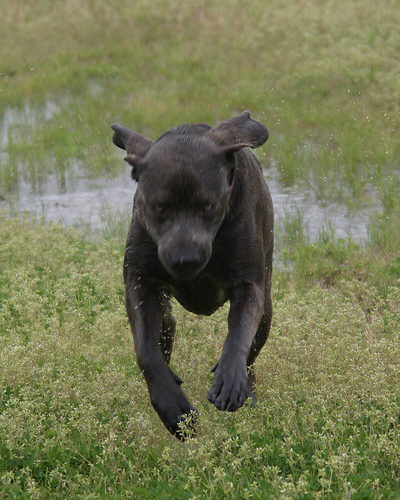

In [27]:
Image.open(train_img[5])

In [28]:
def preprocess_input(x):
  x=x/255.0
  x=x-0.5
  x=x*2
  return x

In [29]:
testing_preprocess_input=Image.open(train_img[5])
testing_preprocess_input_array=preprocess_input(np.array(testing_preprocess_input))
print(testing_preprocess_input_array)

[[[ 0.10588235  0.14509804 -0.17647059]
  [ 0.15294118  0.1372549  -0.16862745]
  [ 0.16078431  0.11372549 -0.16862745]
  ...
  [ 0.1372549   0.09803922 -0.23137255]
  [ 0.11372549  0.0745098  -0.25490196]
  [ 0.12941176  0.0745098  -0.27058824]]

 [[ 0.11372549  0.12941176 -0.18431373]
  [ 0.1372549   0.12156863 -0.18431373]
  [ 0.15294118  0.10588235 -0.17647059]
  ...
  [ 0.12941176  0.09803922 -0.27058824]
  [ 0.11372549  0.0745098  -0.25490196]
  [ 0.11372549  0.06666667 -0.21568627]]

 [[ 0.12156863  0.1372549  -0.17647059]
  [ 0.1372549   0.12156863 -0.18431373]
  [ 0.12941176  0.09803922 -0.19215686]
  ...
  [ 0.1372549   0.11372549 -0.23921569]
  [ 0.12941176  0.09019608 -0.22352941]
  [ 0.1372549   0.09019608 -0.17647059]]

 ...

 [[-0.18431373 -0.12156863 -0.50588235]
  [-0.17647059 -0.17647059 -0.45882353]
  [-0.23137255 -0.27058824 -0.58431373]
  ...
  [-0.27058824 -0.12941176 -0.61568627]
  [-0.18431373 -0.04313725 -0.49803922]
  [-0.19215686 -0.0745098  -0.52156863]]

 [

In [30]:
def preprocess(image_path):
  img = image.load_img(image_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

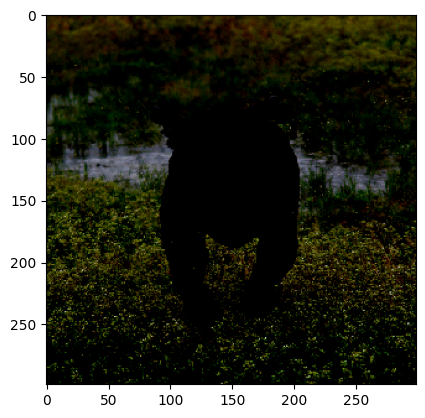

In [31]:
plt.imshow(np.squeeze(preprocess(train_img[5])))

In [32]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 0s 0us/step


In [33]:
from keras.models import Model
new_input=model.input
hidden_layer=model.layers[-2].output
model_new=Model(new_input,hidden_layer)

In [34]:
im = model_new.predict(preprocess(train_img[0]))
im

1/1 [==============================] - 4s 4s/step


array([[0.07512838, 0.2634731 , 0.3379881 , ..., 0.62087476, 0.12629114,
        0.6630243 ]], dtype=float32)

In [35]:
#just for testing
print(np.argmax(im))
print(im.shape)
im=im.reshape(2048,1)
print(im.shape)
im=np.squeeze(im)
print(im.shape)

1689
(1, 2048)
(2048, 1)
(2048,)


In [36]:
def encode(image):
  img=model_new.predict(preprocess(image))
  img=img.reshape(2048,1)
  img=np.squeeze(img)
  return img

In [37]:
encoding_train = {}

In [38]:

for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 2/6000 [00:00<08:28, 11.80it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 4/6000 [00:00<08:13, 12.16it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 6/6000 [00:00<08:15, 12.10it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 8/6000 [00:00<08:03, 12.39it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 10/6000 [00:00<08:07, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 12/6000 [00:00<08:01, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 14/6000 [00:01<08:00, 12.45it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 16/6000 [00:01<08:04, 12.35it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 18/6000 [00:01<08:07, 12.27it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 20/6000 [00:01<08:02, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 22/6000 [00:01<08:00, 12.45it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 24/6000 [00:01<08:06, 12.28it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 26/6000 [00:02<08:09, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 28/6000 [00:02<08:04, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 30/6000 [00:02<08:03, 12.36it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 32/6000 [00:02<08:03, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 34/6000 [00:02<08:03, 12.35it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 36/6000 [00:02<07:57, 12.49it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 38/6000 [00:03<07:52, 12.62it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 40/6000 [00:03<07:55, 12.54it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 42/6000 [00:03<08:15, 12.03it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 44/6000 [00:03<08:10, 12.13it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 46/6000 [00:03<08:07, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 48/6000 [00:03<07:59, 12.40it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 50/6000 [00:04<07:57, 12.46it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 52/6000 [00:04<08:06, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 54/6000 [00:04<08:00, 12.36it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 56/6000 [00:04<07:58, 12.41it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 58/6000 [00:04<07:55, 12.49it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 60/6000 [00:04<07:57, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 62/6000 [00:05<07:56, 12.46it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 64/6000 [00:05<08:33, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 66/6000 [00:05<08:18, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 68/6000 [00:05<08:16, 11.95it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 70/6000 [00:05<08:12, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 72/6000 [00:05<08:02, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 74/6000 [00:06<07:58, 12.39it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 76/6000 [00:06<07:49, 12.61it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 78/6000 [00:06<08:10, 12.07it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 80/6000 [00:06<08:46, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 82/6000 [00:06<10:29,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 84/6000 [00:07<11:06,  8.87it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 85/6000 [00:07<11:13,  8.78it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 86/6000 [00:07<11:13,  8.78it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 87/6000 [00:07<11:26,  8.61it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 88/6000 [00:07<11:19,  8.71it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 89/6000 [00:07<12:16,  8.03it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 90/6000 [00:07<12:46,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 91/6000 [00:07<12:14,  8.05it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 92/6000 [00:08<12:02,  8.18it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 93/6000 [00:08<12:43,  7.74it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 94/6000 [00:08<12:44,  7.73it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 95/6000 [00:08<12:31,  7.85it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 96/6000 [00:08<12:18,  8.00it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 97/6000 [00:08<12:25,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 98/6000 [00:08<13:12,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 99/6000 [00:09<12:41,  7.75it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 100/6000 [00:09<12:13,  8.04it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 102/6000 [00:09<10:32,  9.32it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 104/6000 [00:09<09:42, 10.12it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 106/6000 [00:09<09:03, 10.85it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 108/6000 [00:09<08:39, 11.34it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 110/6000 [00:09<08:26, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 112/6000 [00:10<08:10, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 114/6000 [00:10<07:58, 12.29it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 116/6000 [00:10<08:18, 11.79it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 118/6000 [00:10<08:14, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 120/6000 [00:10<08:07, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 122/6000 [00:10<08:03, 12.15it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 124/6000 [00:11<08:03, 12.15it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 126/6000 [00:11<07:57, 12.29it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 128/6000 [00:11<08:06, 12.06it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 130/6000 [00:11<08:02, 12.18it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 132/6000 [00:11<07:54, 12.35it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 134/6000 [00:11<07:56, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 136/6000 [00:12<07:52, 12.41it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 138/6000 [00:12<07:48, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 140/6000 [00:12<07:50, 12.46it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 142/6000 [00:12<07:59, 12.21it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 144/6000 [00:12<07:57, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 146/6000 [00:12<07:54, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 148/6000 [00:13<07:49, 12.46it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▎         | 150/6000 [00:13<08:02, 12.13it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 152/6000 [00:13<08:03, 12.10it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 154/6000 [00:13<08:08, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 156/6000 [00:13<08:04, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 158/6000 [00:13<08:04, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 160/6000 [00:14<08:13, 11.84it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 162/6000 [00:14<08:05, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 164/6000 [00:14<07:57, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 166/6000 [00:14<07:58, 12.18it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 168/6000 [00:14<07:52, 12.35it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 170/6000 [00:14<07:55, 12.26it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 172/6000 [00:15<07:53, 12.30it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 174/6000 [00:15<07:49, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 176/6000 [00:15<07:46, 12.47it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 178/6000 [00:15<07:59, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 180/6000 [00:15<07:53, 12.29it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 182/6000 [00:15<07:50, 12.37it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 184/6000 [00:16<07:52, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 186/6000 [00:16<07:46, 12.47it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 188/6000 [00:16<07:52, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 190/6000 [00:16<07:55, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 192/6000 [00:16<07:52, 12.30it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 194/6000 [00:16<07:52, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 196/6000 [00:16<07:48, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 198/6000 [00:17<07:53, 12.26it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 200/6000 [00:17<07:44, 12.48it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 202/6000 [00:17<07:39, 12.61it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 204/6000 [00:17<07:47, 12.41it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 206/6000 [00:17<07:49, 12.35it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 208/6000 [00:17<07:47, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 210/6000 [00:18<07:46, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 212/6000 [00:18<07:42, 12.53it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 214/6000 [00:18<07:46, 12.41it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 216/6000 [00:18<09:37, 10.02it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 218/6000 [00:19<11:35,  8.32it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 220/6000 [00:19<11:02,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 221/6000 [00:19<11:40,  8.26it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▎         | 222/6000 [00:19<14:30,  6.64it/s]

1/1 [==============================] - 0s 131ms/step


  4%|▎         | 223/6000 [00:20<21:39,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 224/6000 [00:20<19:10,  5.02it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 225/6000 [00:20<18:11,  5.29it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 226/6000 [00:20<16:10,  5.95it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 227/6000 [00:20<19:19,  4.98it/s]

1/1 [==============================] - 0s 139ms/step


  4%|▍         | 228/6000 [00:21<27:18,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 229/6000 [00:21<22:53,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 230/6000 [00:21<20:49,  4.62it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 231/6000 [00:21<18:43,  5.13it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 232/6000 [00:21<16:32,  5.81it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 233/6000 [00:21<15:11,  6.33it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 234/6000 [00:22<15:32,  6.18it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 235/6000 [00:22<14:29,  6.63it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 236/6000 [00:22<13:15,  7.24it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 238/6000 [00:22<10:45,  8.93it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 240/6000 [00:22<09:28, 10.13it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 242/6000 [00:22<08:57, 10.70it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 244/6000 [00:23<08:37, 11.13it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 246/6000 [00:23<08:12, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 248/6000 [00:23<08:01, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 250/6000 [00:23<07:55, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 252/6000 [00:23<07:57, 12.04it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 254/6000 [00:23<08:32, 11.21it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 256/6000 [00:24<08:14, 11.63it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 258/6000 [00:24<08:00, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 260/6000 [00:24<07:56, 12.06it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 262/6000 [00:24<08:00, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 264/6000 [00:24<07:55, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 266/6000 [00:24<08:23, 11.38it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 268/6000 [00:25<08:11, 11.65it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 270/6000 [00:25<08:21, 11.42it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 272/6000 [00:25<08:16, 11.55it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 274/6000 [00:25<08:13, 11.60it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 276/6000 [00:25<08:04, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 278/6000 [00:25<08:11, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 280/6000 [00:26<08:04, 11.81it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 282/6000 [00:26<07:56, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 284/6000 [00:26<07:54, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 286/6000 [00:26<07:47, 12.21it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 288/6000 [00:26<07:45, 12.27it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 290/6000 [00:26<07:50, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 292/6000 [00:27<07:41, 12.38it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 294/6000 [00:27<08:15, 11.51it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 296/6000 [00:27<07:59, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 298/6000 [00:27<07:56, 11.96it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 300/6000 [00:27<07:52, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 302/6000 [00:27<07:51, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 304/6000 [00:28<07:43, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 306/6000 [00:28<07:48, 12.16it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 308/6000 [00:28<07:44, 12.25it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 310/6000 [00:28<07:42, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 312/6000 [00:28<07:40, 12.36it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 314/6000 [00:28<07:37, 12.42it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 316/6000 [00:29<07:49, 12.11it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 318/6000 [00:29<07:44, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 320/6000 [00:29<07:40, 12.33it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 322/6000 [00:29<07:38, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 324/6000 [00:29<07:39, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 326/6000 [00:29<07:39, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 328/6000 [00:30<07:51, 12.03it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 330/6000 [00:30<07:44, 12.20it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 332/6000 [00:30<07:37, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 334/6000 [00:30<07:41, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 336/6000 [00:30<07:36, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 338/6000 [00:30<07:32, 12.50it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 340/6000 [00:31<07:39, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 342/6000 [00:31<07:42, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 344/6000 [00:31<07:35, 12.41it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 346/6000 [00:31<07:30, 12.54it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 348/6000 [00:31<07:33, 12.46it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 350/6000 [00:31<07:27, 12.63it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 352/6000 [00:32<08:10, 11.52it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 354/6000 [00:32<07:57, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 356/6000 [00:32<07:45, 12.12it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 358/6000 [00:32<08:26, 11.14it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 360/6000 [00:32<09:08, 10.29it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 362/6000 [00:33<09:57,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 363/6000 [00:33<10:03,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 364/6000 [00:33<10:49,  8.68it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 365/6000 [00:33<10:55,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 366/6000 [00:33<11:43,  8.01it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 367/6000 [00:33<11:38,  8.07it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 368/6000 [00:33<11:19,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 369/6000 [00:33<12:20,  7.60it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 370/6000 [00:34<11:53,  7.89it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 371/6000 [00:34<11:44,  7.99it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 372/6000 [00:34<11:26,  8.20it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 373/6000 [00:34<12:13,  7.67it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 374/6000 [00:34<11:58,  7.83it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 375/6000 [00:34<11:37,  8.07it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 376/6000 [00:34<12:19,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 377/6000 [00:34<12:58,  7.22it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▋         | 378/6000 [00:35<12:56,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 379/6000 [00:35<13:31,  6.93it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 381/6000 [00:35<10:52,  8.62it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 383/6000 [00:35<09:27,  9.90it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 385/6000 [00:35<08:45, 10.69it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 387/6000 [00:35<08:25, 11.11it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 389/6000 [00:36<08:08, 11.49it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 391/6000 [00:36<08:01, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 393/6000 [00:36<07:55, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 395/6000 [00:36<07:42, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 397/6000 [00:36<07:42, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 399/6000 [00:36<07:39, 12.19it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 401/6000 [00:37<07:33, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 403/6000 [00:37<07:38, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 405/6000 [00:37<07:39, 12.17it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 407/6000 [00:37<07:34, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 409/6000 [00:37<07:34, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 411/6000 [00:37<07:30, 12.41it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 413/6000 [00:38<07:32, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 415/6000 [00:38<07:42, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 417/6000 [00:38<07:36, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 419/6000 [00:38<07:37, 12.19it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 421/6000 [00:38<07:33, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 423/6000 [00:38<07:37, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 425/6000 [00:39<07:35, 12.23it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 427/6000 [00:39<07:39, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 429/6000 [00:39<07:38, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 431/6000 [00:39<07:33, 12.28it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 433/6000 [00:39<07:37, 12.17it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 435/6000 [00:39<07:31, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 437/6000 [00:39<07:31, 12.32it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 439/6000 [00:40<07:32, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 441/6000 [00:40<07:42, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 443/6000 [00:40<07:38, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 445/6000 [00:40<07:38, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 447/6000 [00:40<07:30, 12.32it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 449/6000 [00:40<07:29, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 451/6000 [00:41<07:31, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 453/6000 [00:41<07:37, 12.13it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 455/6000 [00:41<07:41, 12.01it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 457/6000 [00:41<07:36, 12.13it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 459/6000 [00:41<07:39, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 461/6000 [00:41<07:34, 12.20it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 463/6000 [00:42<07:31, 12.27it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 465/6000 [00:42<07:32, 12.24it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 467/6000 [00:42<07:28, 12.33it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 469/6000 [00:42<07:32, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 471/6000 [00:42<08:06, 11.36it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 473/6000 [00:42<07:52, 11.70it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 475/6000 [00:43<07:44, 11.88it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 477/6000 [00:43<08:08, 11.32it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 479/6000 [00:43<07:55, 11.61it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 481/6000 [00:43<07:47, 11.80it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 483/6000 [00:43<07:43, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 485/6000 [00:44<07:40, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 487/6000 [00:44<07:43, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 489/6000 [00:44<07:42, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 491/6000 [00:44<07:35, 12.08it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 493/6000 [00:44<07:32, 12.18it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 495/6000 [00:44<07:31, 12.20it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 497/6000 [00:45<11:17,  8.13it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 498/6000 [00:45<11:23,  8.05it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 499/6000 [00:45<11:29,  7.98it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 500/6000 [00:45<11:27,  8.00it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 501/6000 [00:45<11:24,  8.03it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 502/6000 [00:45<12:04,  7.59it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 503/6000 [00:46<12:30,  7.33it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 504/6000 [00:46<12:58,  7.06it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 505/6000 [00:46<12:38,  7.24it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 506/6000 [00:46<12:19,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 507/6000 [00:46<11:46,  7.78it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 508/6000 [00:46<11:23,  8.04it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 509/6000 [00:46<10:50,  8.44it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 510/6000 [00:46<11:50,  7.73it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 511/6000 [00:47<12:20,  7.42it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 512/6000 [00:47<12:38,  7.23it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▊         | 513/6000 [00:47<12:34,  7.27it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 514/6000 [00:47<12:33,  7.28it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▊         | 515/6000 [00:47<12:01,  7.60it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 516/6000 [00:47<11:47,  7.75it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 517/6000 [00:47<11:31,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 518/6000 [00:48<12:42,  7.19it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 519/6000 [00:48<13:29,  6.77it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 521/6000 [00:48<10:43,  8.51it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 522/6000 [00:48<10:21,  8.82it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 524/6000 [00:48<09:12,  9.91it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 526/6000 [00:48<08:38, 10.55it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 528/6000 [00:49<08:19, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 530/6000 [00:49<07:58, 11.42it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 532/6000 [00:49<07:56, 11.46it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 534/6000 [00:49<07:53, 11.55it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 536/6000 [00:49<07:50, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 538/6000 [00:49<07:38, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 540/6000 [00:50<07:41, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 542/6000 [00:50<07:47, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 544/6000 [00:50<07:59, 11.39it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 546/6000 [00:50<08:06, 11.21it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 548/6000 [00:50<08:02, 11.31it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 550/6000 [00:50<07:59, 11.36it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 552/6000 [00:51<07:48, 11.63it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 554/6000 [00:51<07:40, 11.82it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 556/6000 [00:51<07:35, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 558/6000 [00:51<07:44, 11.72it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 560/6000 [00:51<07:39, 11.84it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 562/6000 [00:51<07:37, 11.89it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 564/6000 [00:52<07:38, 11.86it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 566/6000 [00:52<07:32, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 568/6000 [00:52<07:40, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 570/6000 [00:52<07:46, 11.63it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 572/6000 [00:52<07:45, 11.67it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 574/6000 [00:52<07:36, 11.89it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 576/6000 [00:53<07:36, 11.87it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 578/6000 [00:53<07:29, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 580/6000 [00:53<07:27, 12.12it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 582/6000 [00:53<08:03, 11.20it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 584/6000 [00:53<08:25, 10.71it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 586/6000 [00:54<08:46, 10.29it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 588/6000 [00:54<08:25, 10.70it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 590/6000 [00:54<08:04, 11.17it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 592/6000 [00:54<07:50, 11.50it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 594/6000 [00:54<07:53, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 596/6000 [00:54<07:41, 11.70it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 598/6000 [00:55<07:36, 11.82it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 600/6000 [00:55<07:28, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 602/6000 [00:55<07:24, 12.16it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 604/6000 [00:55<07:30, 11.98it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 606/6000 [00:55<07:29, 11.99it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 608/6000 [00:55<07:32, 11.91it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 610/6000 [00:56<07:32, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 612/6000 [00:56<07:42, 11.66it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 614/6000 [00:56<07:40, 11.70it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 616/6000 [00:56<07:34, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 618/6000 [00:56<07:40, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 620/6000 [00:56<07:32, 11.88it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 622/6000 [00:57<07:34, 11.84it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 624/6000 [00:57<07:31, 11.91it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 626/6000 [00:57<07:28, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 628/6000 [00:57<07:24, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 630/6000 [00:57<07:32, 11.87it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 632/6000 [00:57<07:27, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 634/6000 [00:58<07:29, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 636/6000 [00:58<07:22, 12.11it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 638/6000 [00:58<08:11, 10.92it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 640/6000 [00:58<09:27,  9.44it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 641/6000 [00:58<09:29,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 642/6000 [00:58<10:27,  8.54it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 643/6000 [00:59<11:12,  7.97it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 644/6000 [00:59<10:49,  8.25it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 645/6000 [00:59<10:51,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 646/6000 [00:59<10:42,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 647/6000 [00:59<10:57,  8.15it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 648/6000 [00:59<11:00,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 649/6000 [00:59<11:48,  7.55it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 650/6000 [01:00<11:21,  7.85it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 651/6000 [01:00<11:09,  7.99it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 652/6000 [01:00<10:55,  8.16it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 653/6000 [01:00<10:53,  8.18it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 654/6000 [01:00<10:45,  8.28it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 655/6000 [01:00<10:30,  8.48it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 656/6000 [01:00<11:33,  7.70it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 657/6000 [01:00<11:19,  7.86it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 658/6000 [01:01<11:43,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 659/6000 [01:01<11:33,  7.70it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 660/6000 [01:01<11:06,  8.01it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 662/6000 [01:01<09:17,  9.57it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 664/6000 [01:01<08:31, 10.44it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 666/6000 [01:01<08:03, 11.04it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 668/6000 [01:01<08:03, 11.03it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 670/6000 [01:02<07:49, 11.36it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 672/6000 [01:02<07:44, 11.48it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 674/6000 [01:02<07:35, 11.70it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 676/6000 [01:02<07:32, 11.77it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 678/6000 [01:02<07:24, 11.96it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 680/6000 [01:02<07:31, 11.77it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 682/6000 [01:03<07:26, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 684/6000 [01:03<07:23, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 686/6000 [01:03<07:28, 11.84it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 688/6000 [01:03<07:27, 11.88it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 690/6000 [01:03<07:24, 11.95it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 692/6000 [01:03<07:31, 11.76it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 694/6000 [01:04<07:29, 11.80it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 696/6000 [01:04<07:23, 11.96it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 698/6000 [01:04<07:24, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 700/6000 [01:04<07:18, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 702/6000 [01:04<07:48, 11.31it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 704/6000 [01:04<07:48, 11.31it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 706/6000 [01:05<07:37, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 708/6000 [01:05<07:32, 11.70it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 710/6000 [01:05<07:28, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 712/6000 [01:05<07:24, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 714/6000 [01:05<07:30, 11.74it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 716/6000 [01:05<07:35, 11.61it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 718/6000 [01:06<07:26, 11.83it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 720/6000 [01:06<07:20, 11.99it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 722/6000 [01:06<07:37, 11.53it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 724/6000 [01:06<07:46, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 726/6000 [01:06<07:40, 11.46it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 728/6000 [01:07<07:37, 11.52it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 730/6000 [01:07<07:28, 11.74it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 732/6000 [01:07<07:30, 11.69it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 734/6000 [01:07<07:24, 11.86it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 736/6000 [01:07<07:20, 11.95it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 738/6000 [01:07<07:16, 12.06it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 740/6000 [01:08<08:00, 10.95it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 742/6000 [01:08<07:42, 11.37it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 744/6000 [01:08<07:33, 11.59it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 746/6000 [01:08<07:29, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 748/6000 [01:08<07:26, 11.77it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▎        | 750/6000 [01:08<07:30, 11.66it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 752/6000 [01:09<07:31, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 754/6000 [01:09<07:24, 11.79it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 756/6000 [01:09<07:22, 11.85it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 758/6000 [01:09<07:26, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 760/6000 [01:09<07:20, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 762/6000 [01:09<07:20, 11.90it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 764/6000 [01:10<07:22, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 766/6000 [01:10<07:17, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 768/6000 [01:10<07:16, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 770/6000 [01:10<07:27, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 772/6000 [01:10<07:34, 11.51it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 774/6000 [01:10<07:28, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 776/6000 [01:11<07:34, 11.49it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 778/6000 [01:11<07:56, 10.97it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 780/6000 [01:11<09:08,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 781/6000 [01:11<09:18,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 782/6000 [01:11<09:29,  9.16it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 783/6000 [01:11<09:53,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 784/6000 [01:12<10:35,  8.20it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 785/6000 [01:12<10:30,  8.27it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 786/6000 [01:12<10:31,  8.26it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 787/6000 [01:12<10:17,  8.44it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 788/6000 [01:12<10:19,  8.41it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 789/6000 [01:12<10:12,  8.51it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 790/6000 [01:12<11:09,  7.78it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 791/6000 [01:13<12:00,  7.23it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 792/6000 [01:13<11:31,  7.54it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 793/6000 [01:13<12:04,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 794/6000 [01:13<11:42,  7.41it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 795/6000 [01:13<11:51,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 796/6000 [01:13<12:14,  7.09it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 797/6000 [01:13<11:50,  7.32it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 798/6000 [01:13<11:40,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 799/6000 [01:14<11:19,  7.65it/s]

1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 800/6000 [01:14<12:24,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 801/6000 [01:14<11:19,  7.65it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 803/6000 [01:14<09:24,  9.21it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 805/6000 [01:14<08:38, 10.02it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 807/6000 [01:14<08:09, 10.61it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 809/6000 [01:15<07:52, 11.00it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 811/6000 [01:15<07:39, 11.29it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 813/6000 [01:15<07:47, 11.10it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 815/6000 [01:15<07:34, 11.40it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 817/6000 [01:15<07:27, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 819/6000 [01:15<07:17, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 821/6000 [01:16<07:26, 11.60it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 823/6000 [01:16<07:26, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 825/6000 [01:16<07:26, 11.60it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 827/6000 [01:16<07:19, 11.76it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 829/6000 [01:16<07:09, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 831/6000 [01:16<07:06, 12.11it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 833/6000 [01:17<07:11, 11.97it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 835/6000 [01:17<07:17, 11.81it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 837/6000 [01:17<07:23, 11.65it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 839/6000 [01:17<07:15, 11.86it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 841/6000 [01:17<07:17, 11.80it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 843/6000 [01:17<07:16, 11.81it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 845/6000 [01:18<07:14, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 847/6000 [01:18<07:12, 11.92it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 849/6000 [01:18<07:20, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 851/6000 [01:18<07:26, 11.52it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 853/6000 [01:18<07:21, 11.67it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 855/6000 [01:18<07:20, 11.67it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 857/6000 [01:19<07:16, 11.78it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 859/6000 [01:19<07:17, 11.74it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 861/6000 [01:19<07:25, 11.53it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 863/6000 [01:19<07:15, 11.79it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 865/6000 [01:19<07:11, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 867/6000 [01:19<07:17, 11.72it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 869/6000 [01:20<07:19, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 871/6000 [01:20<07:17, 11.72it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 873/6000 [01:20<07:20, 11.64it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 875/6000 [01:20<07:15, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 877/6000 [01:20<07:33, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 879/6000 [01:21<07:25, 11.49it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 881/6000 [01:21<07:18, 11.67it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 883/6000 [01:21<07:13, 11.80it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 885/6000 [01:21<07:17, 11.69it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 887/6000 [01:21<07:18, 11.67it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 889/6000 [01:21<07:12, 11.83it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 891/6000 [01:22<07:15, 11.74it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 893/6000 [01:22<07:08, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 895/6000 [01:22<07:07, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 897/6000 [01:22<07:19, 11.61it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 899/6000 [01:22<07:13, 11.78it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 901/6000 [01:22<07:09, 11.87it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 903/6000 [01:23<07:12, 11.79it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 905/6000 [01:23<07:13, 11.76it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 907/6000 [01:23<07:10, 11.84it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 909/6000 [01:23<07:14, 11.72it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 911/6000 [01:23<07:19, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 913/6000 [01:23<07:13, 11.73it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 915/6000 [01:24<07:24, 11.44it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 917/6000 [01:24<07:19, 11.55it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 919/6000 [01:24<07:35, 11.16it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 921/6000 [01:24<08:52,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 922/6000 [01:24<09:02,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 923/6000 [01:25<10:12,  8.29it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 924/6000 [01:25<10:04,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 925/6000 [01:25<09:54,  8.53it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 926/6000 [01:25<09:58,  8.48it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 927/6000 [01:25<10:15,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 928/6000 [01:25<11:27,  7.38it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 929/6000 [01:25<11:00,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 930/6000 [01:25<11:46,  7.17it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 931/6000 [01:26<11:59,  7.05it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 932/6000 [01:26<12:30,  6.75it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 933/6000 [01:26<11:41,  7.23it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 934/6000 [01:26<11:27,  7.37it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 935/6000 [01:26<12:09,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 936/6000 [01:26<12:21,  6.83it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 937/6000 [01:26<11:27,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 938/6000 [01:27<11:01,  7.65it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 939/6000 [01:27<10:48,  7.80it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 940/6000 [01:27<11:36,  7.26it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 941/6000 [01:27<11:00,  7.65it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 943/6000 [01:27<09:06,  9.26it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 945/6000 [01:27<08:39,  9.73it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 947/6000 [01:27<08:07, 10.36it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 949/6000 [01:28<07:43, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 951/6000 [01:28<07:36, 11.05it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 953/6000 [01:28<07:28, 11.24it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 955/6000 [01:28<07:23, 11.38it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 957/6000 [01:28<07:17, 11.54it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 959/6000 [01:28<07:10, 11.70it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 961/6000 [01:29<07:15, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 963/6000 [01:29<07:42, 10.90it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 965/6000 [01:29<07:28, 11.23it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 967/6000 [01:29<07:26, 11.26it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 969/6000 [01:29<07:19, 11.44it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 971/6000 [01:30<07:25, 11.28it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 973/6000 [01:30<07:15, 11.55it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 975/6000 [01:30<07:06, 11.77it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 977/6000 [01:30<07:05, 11.81it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 979/6000 [01:30<07:12, 11.61it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 981/6000 [01:30<07:42, 10.86it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 983/6000 [01:31<07:26, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 985/6000 [01:31<07:17, 11.48it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 987/6000 [01:31<07:15, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 989/6000 [01:31<07:11, 11.61it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 991/6000 [01:31<07:13, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 993/6000 [01:31<07:05, 11.76it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 995/6000 [01:32<07:08, 11.67it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 997/6000 [01:32<07:10, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 999/6000 [01:32<07:04, 11.77it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1001/6000 [01:32<07:00, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1003/6000 [01:32<07:01, 11.86it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1005/6000 [01:32<07:06, 11.72it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1007/6000 [01:33<07:01, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1009/6000 [01:33<06:58, 11.92it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1011/6000 [01:33<06:57, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1013/6000 [01:33<06:54, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1015/6000 [01:33<07:08, 11.64it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1017/6000 [01:33<07:05, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1019/6000 [01:34<07:02, 11.79it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1021/6000 [01:34<06:59, 11.86it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1023/6000 [01:34<07:01, 11.80it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1025/6000 [01:34<07:01, 11.82it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1027/6000 [01:34<07:07, 11.64it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1029/6000 [01:35<07:08, 11.61it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1031/6000 [01:35<07:06, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1033/6000 [01:35<07:09, 11.56it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1035/6000 [01:35<07:09, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1037/6000 [01:35<07:04, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1039/6000 [01:35<07:11, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1041/6000 [01:36<07:11, 11.50it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1043/6000 [01:36<07:06, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1045/6000 [01:36<07:03, 11.69it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1047/6000 [01:36<07:00, 11.79it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1049/6000 [01:36<06:56, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1051/6000 [01:36<07:13, 11.40it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1053/6000 [01:37<07:08, 11.53it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1055/6000 [01:37<07:07, 11.56it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1057/6000 [01:37<07:43, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1059/6000 [01:37<09:12,  8.94it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 1060/6000 [01:37<09:41,  8.50it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1061/6000 [01:38<10:25,  7.90it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1062/6000 [01:38<10:13,  8.05it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1063/6000 [01:38<10:41,  7.69it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1064/6000 [01:38<11:23,  7.22it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1065/6000 [01:38<11:06,  7.41it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1066/6000 [01:38<10:40,  7.71it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1067/6000 [01:38<10:06,  8.13it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1068/6000 [01:39<11:29,  7.15it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1069/6000 [01:39<11:06,  7.40it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1070/6000 [01:39<10:49,  7.60it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1071/6000 [01:39<10:34,  7.77it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1072/6000 [01:39<11:04,  7.41it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1073/6000 [01:39<11:47,  6.96it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 1074/6000 [01:39<11:20,  7.24it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1075/6000 [01:39<11:09,  7.35it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1076/6000 [01:40<11:55,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1077/6000 [01:40<11:13,  7.31it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1078/6000 [01:40<11:25,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1080/6000 [01:40<09:27,  8.67it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1082/6000 [01:40<08:29,  9.65it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1084/6000 [01:40<07:52, 10.40it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1086/6000 [01:41<07:35, 10.79it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1088/6000 [01:41<07:26, 11.00it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1090/6000 [01:41<07:16, 11.24it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1092/6000 [01:41<07:09, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1094/6000 [01:41<06:58, 11.72it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1096/6000 [01:41<07:02, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1098/6000 [01:42<07:04, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1100/6000 [01:42<06:56, 11.75it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1102/6000 [01:42<06:56, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1104/6000 [01:42<06:48, 11.99it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1106/6000 [01:42<06:51, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1108/6000 [01:42<06:49, 11.94it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1110/6000 [01:43<06:59, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1112/6000 [01:43<06:57, 11.70it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1114/6000 [01:43<07:18, 11.14it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1116/6000 [01:43<07:12, 11.28it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1118/6000 [01:43<07:05, 11.46it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1120/6000 [01:44<07:05, 11.48it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1122/6000 [01:44<07:05, 11.45it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1124/6000 [01:44<07:06, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1126/6000 [01:44<07:00, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1128/6000 [01:44<07:00, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1130/6000 [01:44<06:58, 11.63it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1132/6000 [01:45<07:00, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1134/6000 [01:45<07:03, 11.49it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1136/6000 [01:45<06:57, 11.64it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1138/6000 [01:45<06:59, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1140/6000 [01:45<06:54, 11.73it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1142/6000 [01:45<07:27, 10.85it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1144/6000 [01:46<07:15, 11.15it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1146/6000 [01:46<07:12, 11.22it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1148/6000 [01:46<07:05, 11.41it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1150/6000 [01:46<07:02, 11.48it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1152/6000 [01:46<06:59, 11.55it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1154/6000 [01:46<06:55, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1156/6000 [01:47<06:54, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1158/6000 [01:47<07:02, 11.47it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1160/6000 [01:47<07:00, 11.51it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1162/6000 [01:47<07:02, 11.45it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1164/6000 [01:47<06:54, 11.67it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1166/6000 [01:48<06:54, 11.66it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1168/6000 [01:48<06:55, 11.64it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1170/6000 [01:48<07:08, 11.28it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1172/6000 [01:48<07:05, 11.36it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1174/6000 [01:48<06:59, 11.51it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1176/6000 [01:48<07:08, 11.27it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1178/6000 [01:49<07:07, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1180/6000 [01:49<07:09, 11.22it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1182/6000 [01:49<07:10, 11.19it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1184/6000 [01:49<07:00, 11.45it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1186/6000 [01:49<06:57, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1188/6000 [01:49<07:04, 11.34it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1190/6000 [01:50<06:56, 11.56it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1192/6000 [01:50<06:56, 11.53it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1194/6000 [01:50<07:07, 11.24it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1196/6000 [01:50<08:47,  9.11it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1197/6000 [01:50<08:53,  9.00it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1198/6000 [01:51<09:03,  8.83it/s]

1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 1199/6000 [01:51<09:24,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1200/6000 [01:51<09:41,  8.26it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1201/6000 [01:51<09:47,  8.16it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1202/6000 [01:51<09:43,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1203/6000 [01:51<09:50,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1204/6000 [01:51<09:53,  8.08it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1205/6000 [01:51<10:01,  7.97it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1206/6000 [01:52<09:52,  8.09it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1207/6000 [01:52<09:50,  8.12it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1208/6000 [01:52<10:39,  7.49it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1209/6000 [01:52<10:25,  7.66it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1210/6000 [01:52<10:05,  7.91it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 1211/6000 [01:52<09:49,  8.12it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1212/6000 [01:52<10:45,  7.42it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1213/6000 [01:53<11:19,  7.04it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1214/6000 [01:53<11:56,  6.68it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1215/6000 [01:53<11:02,  7.22it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1216/6000 [01:53<11:32,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1217/6000 [01:53<10:49,  7.37it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 1218/6000 [01:53<10:53,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1219/6000 [01:53<10:41,  7.45it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1221/6000 [01:54<09:00,  8.84it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1223/6000 [01:54<08:18,  9.58it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1225/6000 [01:54<07:46, 10.24it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1227/6000 [01:54<07:30, 10.60it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1229/6000 [01:54<07:17, 10.90it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1231/6000 [01:54<07:04, 11.24it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1233/6000 [01:55<07:02, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1235/6000 [01:55<06:54, 11.49it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1237/6000 [01:55<06:49, 11.63it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1239/6000 [01:55<06:50, 11.58it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1241/6000 [01:55<06:54, 11.49it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1243/6000 [01:55<06:51, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1245/6000 [01:56<06:48, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1247/6000 [01:56<06:48, 11.63it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1249/6000 [01:56<06:47, 11.67it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1251/6000 [01:56<07:14, 10.94it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1253/6000 [01:56<07:06, 11.13it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1255/6000 [01:56<06:59, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1257/6000 [01:57<06:52, 11.49it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1259/6000 [01:57<06:56, 11.38it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1261/6000 [01:57<06:51, 11.52it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1263/6000 [01:57<06:54, 11.44it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1265/6000 [01:57<06:47, 11.62it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1267/6000 [01:58<06:49, 11.55it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1269/6000 [01:58<06:52, 11.47it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1271/6000 [01:58<06:52, 11.46it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1273/6000 [01:58<06:47, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1275/6000 [01:58<06:51, 11.49it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 1277/6000 [01:58<06:52, 11.44it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1279/6000 [01:59<06:50, 11.50it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 1281/6000 [01:59<06:47, 11.58it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1283/6000 [01:59<06:45, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 1285/6000 [01:59<06:52, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 1287/6000 [01:59<07:07, 11.02it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1289/6000 [01:59<07:02, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1291/6000 [02:00<06:55, 11.33it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1293/6000 [02:00<06:55, 11.32it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1295/6000 [02:00<06:57, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1297/6000 [02:00<06:57, 11.27it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1299/6000 [02:00<06:54, 11.35it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1301/6000 [02:00<06:47, 11.52it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1303/6000 [02:01<06:43, 11.64it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1305/6000 [02:01<06:45, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1307/6000 [02:01<06:41, 11.69it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1309/6000 [02:01<06:44, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1311/6000 [02:01<06:46, 11.55it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1313/6000 [02:02<07:14, 10.78it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1315/6000 [02:02<07:04, 11.05it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1317/6000 [02:02<07:00, 11.14it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1319/6000 [02:02<06:52, 11.35it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1321/6000 [02:02<06:55, 11.25it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1323/6000 [02:02<06:56, 11.24it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1325/6000 [02:03<06:48, 11.45it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1327/6000 [02:03<06:42, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1329/6000 [02:03<06:43, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1331/6000 [02:03<06:43, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1333/6000 [02:03<06:51, 11.35it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1335/6000 [02:04<07:43, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1337/6000 [02:04<08:37,  9.01it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1338/6000 [02:04<08:36,  9.02it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1339/6000 [02:04<08:32,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1340/6000 [02:04<08:43,  8.90it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1341/6000 [02:04<09:09,  8.49it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1342/6000 [02:04<09:15,  8.39it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 1343/6000 [02:05<09:12,  8.42it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1344/6000 [02:05<09:15,  8.39it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1345/6000 [02:05<09:19,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1346/6000 [02:05<09:26,  8.21it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1347/6000 [02:05<09:26,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1348/6000 [02:05<09:25,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1349/6000 [02:05<09:48,  7.90it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▎       | 1350/6000 [02:05<09:51,  7.86it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1351/6000 [02:06<09:35,  8.08it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1352/6000 [02:06<09:39,  8.02it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1353/6000 [02:06<10:11,  7.60it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1354/6000 [02:06<10:48,  7.17it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1355/6000 [02:06<10:24,  7.44it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1356/6000 [02:06<10:21,  7.47it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1357/6000 [02:06<09:58,  7.75it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 1358/6000 [02:07<11:15,  6.88it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1359/6000 [02:07<10:40,  7.24it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1360/6000 [02:07<10:26,  7.41it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1361/6000 [02:07<09:41,  7.98it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1363/6000 [02:07<08:16,  9.35it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1365/6000 [02:07<07:34, 10.19it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1367/6000 [02:07<07:23, 10.44it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1369/6000 [02:08<07:10, 10.75it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1371/6000 [02:08<06:57, 11.10it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1373/6000 [02:08<06:52, 11.21it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1375/6000 [02:08<06:45, 11.41it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1377/6000 [02:08<06:50, 11.25it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1379/6000 [02:08<06:47, 11.35it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1381/6000 [02:09<06:50, 11.26it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1383/6000 [02:09<06:42, 11.47it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1385/6000 [02:09<06:43, 11.45it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1387/6000 [02:09<06:43, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1389/6000 [02:09<06:45, 11.38it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1391/6000 [02:10<06:46, 11.35it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1393/6000 [02:10<06:48, 11.28it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1395/6000 [02:10<06:53, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1397/6000 [02:10<06:58, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1399/6000 [02:10<07:09, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1401/6000 [02:10<07:35, 10.10it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1403/6000 [02:11<07:23, 10.36it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1405/6000 [02:11<07:12, 10.62it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1407/6000 [02:11<07:01, 10.89it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1409/6000 [02:11<07:20, 10.41it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1411/6000 [02:11<07:07, 10.72it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1413/6000 [02:12<07:10, 10.65it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1415/6000 [02:12<07:02, 10.85it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1417/6000 [02:12<06:55, 11.02it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1419/6000 [02:12<06:47, 11.24it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 1421/6000 [02:12<06:45, 11.28it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1423/6000 [02:12<06:45, 11.29it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1425/6000 [02:13<06:45, 11.29it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1427/6000 [02:13<06:38, 11.49it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1429/6000 [02:13<06:49, 11.16it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1431/6000 [02:13<07:15, 10.50it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1433/6000 [02:13<07:07, 10.69it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1435/6000 [02:14<06:57, 10.93it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1437/6000 [02:14<06:58, 10.90it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1439/6000 [02:14<06:51, 11.09it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1441/6000 [02:14<06:49, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1443/6000 [02:14<06:46, 11.20it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1445/6000 [02:14<06:41, 11.35it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1447/6000 [02:15<06:41, 11.35it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1449/6000 [02:15<06:43, 11.29it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1451/6000 [02:15<06:38, 11.41it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1453/6000 [02:15<06:35, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1455/6000 [02:15<06:35, 11.48it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1457/6000 [02:16<06:59, 10.84it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1459/6000 [02:16<07:01, 10.76it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1461/6000 [02:16<06:54, 10.96it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1463/6000 [02:16<06:44, 11.23it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1465/6000 [02:16<06:39, 11.34it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1467/6000 [02:16<06:38, 11.37it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1469/6000 [02:17<06:36, 11.42it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 1471/6000 [02:17<06:43, 11.21it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 1473/6000 [02:17<07:41,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1475/6000 [02:17<08:22,  9.01it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1476/6000 [02:17<09:08,  8.25it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1477/6000 [02:18<09:37,  7.83it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 1478/6000 [02:18<09:36,  7.84it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 1479/6000 [02:18<09:46,  7.70it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1480/6000 [02:18<09:36,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1481/6000 [02:18<10:21,  7.27it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1482/6000 [02:18<09:48,  7.67it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1483/6000 [02:18<09:35,  7.84it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1484/6000 [02:19<10:07,  7.43it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 1485/6000 [02:19<10:01,  7.50it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 1486/6000 [02:19<09:39,  7.79it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 1487/6000 [02:19<10:25,  7.21it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1488/6000 [02:19<10:01,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1489/6000 [02:19<09:42,  7.74it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1490/6000 [02:19<10:08,  7.41it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1491/6000 [02:19<09:55,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1492/6000 [02:20<10:25,  7.21it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 1493/6000 [02:20<10:27,  7.18it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 1494/6000 [02:20<10:47,  6.96it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 1495/6000 [02:20<10:49,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 1496/6000 [02:20<09:56,  7.55it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 1498/6000 [02:20<08:17,  9.05it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1500/6000 [02:21<07:34,  9.91it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1502/6000 [02:21<07:07, 10.53it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1504/6000 [02:21<06:58, 10.73it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1506/6000 [02:21<07:14, 10.33it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1508/6000 [02:21<07:10, 10.43it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1510/6000 [02:21<07:04, 10.57it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1512/6000 [02:22<06:57, 10.76it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1514/6000 [02:22<06:53, 10.85it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1516/6000 [02:22<06:58, 10.71it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1518/6000 [02:22<06:56, 10.76it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1520/6000 [02:22<06:45, 11.06it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1522/6000 [02:23<06:47, 11.00it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1524/6000 [02:23<06:44, 11.08it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1526/6000 [02:23<06:41, 11.15it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1528/6000 [02:23<07:03, 10.56it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1530/6000 [02:23<06:57, 10.71it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1532/6000 [02:23<06:53, 10.81it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1534/6000 [02:24<06:44, 11.03it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1536/6000 [02:24<06:38, 11.20it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1538/6000 [02:24<06:34, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1540/6000 [02:24<06:45, 10.99it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1542/6000 [02:24<06:41, 11.11it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1544/6000 [02:25<06:37, 11.20it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1546/6000 [02:25<06:34, 11.29it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1548/6000 [02:25<06:35, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1550/6000 [02:25<07:02, 10.53it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1552/6000 [02:25<06:47, 10.92it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1554/6000 [02:25<06:45, 10.97it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1556/6000 [02:26<06:37, 11.19it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1558/6000 [02:26<10:24,  7.12it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1560/6000 [02:26<09:19,  7.93it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1562/6000 [02:26<08:28,  8.73it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1564/6000 [02:27<07:50,  9.44it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1566/6000 [02:27<07:41,  9.62it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1568/6000 [02:27<07:29,  9.87it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1570/6000 [02:27<07:20, 10.05it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1572/6000 [02:27<07:06, 10.38it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1574/6000 [02:28<06:53, 10.71it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 1576/6000 [02:28<06:53, 10.70it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 1578/6000 [02:28<06:45, 10.90it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 1580/6000 [02:28<07:15, 10.16it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 1582/6000 [02:28<06:59, 10.54it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 1584/6000 [02:29<07:00, 10.49it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 1586/6000 [02:29<06:51, 10.74it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 1588/6000 [02:29<07:08, 10.30it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 1590/6000 [02:29<06:53, 10.66it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1592/6000 [02:29<06:50, 10.74it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1594/6000 [02:29<06:49, 10.76it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1596/6000 [02:30<06:46, 10.84it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1598/6000 [02:30<06:40, 11.00it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1600/6000 [02:30<06:33, 11.17it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1602/6000 [02:30<07:08, 10.25it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1604/6000 [02:31<07:56,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1605/6000 [02:31<08:12,  8.92it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 1606/6000 [02:31<08:34,  8.55it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 1607/6000 [02:31<09:12,  7.95it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1608/6000 [02:31<09:52,  7.41it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 1609/6000 [02:31<09:46,  7.49it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1610/6000 [02:31<09:47,  7.47it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1611/6000 [02:32<10:46,  6.79it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1612/6000 [02:32<10:09,  7.20it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1613/6000 [02:32<09:47,  7.47it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 1614/6000 [02:32<10:02,  7.28it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 1615/6000 [02:32<10:05,  7.24it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 1616/6000 [02:32<10:00,  7.30it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1617/6000 [02:32<09:50,  7.42it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1618/6000 [02:32<09:28,  7.71it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 1619/6000 [02:33<09:36,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1620/6000 [02:33<09:54,  7.37it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 1621/6000 [02:33<10:02,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1622/6000 [02:33<09:47,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1623/6000 [02:33<10:32,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1624/6000 [02:33<10:01,  7.27it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1625/6000 [02:33<10:29,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1626/6000 [02:34<09:42,  7.51it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1628/6000 [02:34<08:13,  8.86it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1629/6000 [02:34<08:01,  9.07it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1631/6000 [02:34<07:25,  9.80it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1633/6000 [02:34<07:07, 10.22it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1635/6000 [02:34<07:24,  9.82it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1637/6000 [02:35<07:00, 10.38it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1639/6000 [02:35<06:59, 10.40it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1641/6000 [02:35<06:49, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1643/6000 [02:35<06:40, 10.89it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1645/6000 [02:35<06:35, 11.00it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1647/6000 [02:36<06:48, 10.66it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1649/6000 [02:36<06:41, 10.84it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1651/6000 [02:36<06:33, 11.06it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1653/6000 [02:36<06:29, 11.16it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1655/6000 [02:36<06:31, 11.09it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1657/6000 [02:36<06:37, 10.94it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1659/6000 [02:37<06:41, 10.81it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1661/6000 [02:37<06:35, 10.97it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1663/6000 [02:37<06:30, 11.09it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1665/6000 [02:37<06:33, 11.00it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1667/6000 [02:37<06:36, 10.93it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1669/6000 [02:38<06:39, 10.83it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1671/6000 [02:38<06:32, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1673/6000 [02:38<06:29, 11.12it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1675/6000 [02:38<06:30, 11.07it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1677/6000 [02:38<06:57, 10.35it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1679/6000 [02:38<06:51, 10.51it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1681/6000 [02:39<06:50, 10.53it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1683/6000 [02:39<06:50, 10.52it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1685/6000 [02:39<06:41, 10.75it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1687/6000 [02:39<06:33, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1689/6000 [02:39<06:29, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1691/6000 [02:40<06:35, 10.90it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1693/6000 [02:40<06:36, 10.87it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1695/6000 [02:40<06:32, 10.97it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1697/6000 [02:40<06:25, 11.16it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1699/6000 [02:40<06:23, 11.22it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1701/6000 [02:40<06:30, 11.01it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1703/6000 [02:41<06:51, 10.44it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1705/6000 [02:41<06:47, 10.54it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1707/6000 [02:41<06:42, 10.66it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1709/6000 [02:41<06:36, 10.82it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1711/6000 [02:41<06:35, 10.85it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 1713/6000 [02:42<06:57, 10.26it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1715/6000 [02:42<06:43, 10.61it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1717/6000 [02:42<06:36, 10.79it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1719/6000 [02:42<06:34, 10.85it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1721/6000 [02:42<06:28, 11.01it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 1723/6000 [02:42<06:24, 11.14it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1725/6000 [02:43<06:46, 10.51it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1727/6000 [02:43<06:39, 10.70it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1729/6000 [02:43<06:51, 10.38it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1731/6000 [02:43<06:43, 10.58it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1733/6000 [02:43<06:36, 10.76it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1735/6000 [02:44<07:34,  9.39it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1736/6000 [02:44<08:14,  8.63it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1737/6000 [02:44<08:28,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1738/6000 [02:44<08:43,  8.15it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1739/6000 [02:44<08:45,  8.11it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1740/6000 [02:44<08:44,  8.12it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1741/6000 [02:45<08:42,  8.14it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1742/6000 [02:45<09:32,  7.44it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1743/6000 [02:45<09:18,  7.62it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 1744/6000 [02:45<09:51,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1745/6000 [02:45<10:17,  6.89it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1746/6000 [02:45<09:56,  7.13it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1747/6000 [02:45<09:47,  7.24it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1748/6000 [02:46<09:42,  7.31it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1749/6000 [02:46<10:12,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1750/6000 [02:46<09:39,  7.34it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 1751/6000 [02:46<09:35,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 1752/6000 [02:46<09:16,  7.64it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 1753/6000 [02:46<09:21,  7.57it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 1754/6000 [02:46<09:30,  7.45it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1755/6000 [02:46<09:44,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1756/6000 [02:47<09:22,  7.55it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 1757/6000 [02:47<09:39,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1758/6000 [02:47<09:43,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1759/6000 [02:47<09:25,  7.50it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1761/6000 [02:47<08:05,  8.72it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1763/6000 [02:47<07:21,  9.60it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1764/6000 [02:47<07:18,  9.66it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1766/6000 [02:48<06:49, 10.34it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1768/6000 [02:48<06:42, 10.51it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1770/6000 [02:48<06:35, 10.68it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 1772/6000 [02:48<06:28, 10.89it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1774/6000 [02:48<06:29, 10.86it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1776/6000 [02:49<06:23, 11.03it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1778/6000 [02:49<06:18, 11.16it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1780/6000 [02:49<06:26, 10.93it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 1782/6000 [02:49<06:24, 10.96it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1784/6000 [02:49<06:20, 11.08it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1786/6000 [02:49<06:42, 10.47it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1788/6000 [02:50<06:29, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 1790/6000 [02:50<06:31, 10.76it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1792/6000 [02:50<06:32, 10.71it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1794/6000 [02:50<06:26, 10.88it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1796/6000 [02:50<06:25, 10.89it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 1798/6000 [02:51<06:25, 10.89it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1800/6000 [02:51<06:25, 10.88it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1802/6000 [02:51<06:30, 10.76it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1804/6000 [02:51<06:22, 10.98it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 1806/6000 [02:51<06:23, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 1808/6000 [02:52<06:36, 10.57it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1810/6000 [02:52<06:49, 10.24it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1812/6000 [02:52<06:45, 10.33it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1814/6000 [02:52<06:36, 10.56it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 1816/6000 [02:52<06:37, 10.52it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1818/6000 [02:52<06:36, 10.54it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1820/6000 [02:53<06:32, 10.64it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1822/6000 [02:53<06:28, 10.76it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1824/6000 [02:53<06:26, 10.80it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 1826/6000 [02:53<06:26, 10.81it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1828/6000 [02:53<06:24, 10.85it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1830/6000 [02:54<06:21, 10.93it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1832/6000 [02:54<06:14, 11.12it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 1834/6000 [02:54<06:19, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1836/6000 [02:54<06:21, 10.90it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1838/6000 [02:54<06:19, 10.97it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1840/6000 [02:54<06:14, 11.10it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1842/6000 [02:55<06:13, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1844/6000 [02:55<06:15, 11.08it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1846/6000 [02:55<06:24, 10.81it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1848/6000 [02:55<06:21, 10.90it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1850/6000 [02:55<06:18, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1852/6000 [02:56<06:22, 10.86it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1854/6000 [02:56<06:22, 10.83it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1856/6000 [02:56<06:21, 10.87it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1858/6000 [02:56<06:21, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1860/6000 [02:56<06:19, 10.90it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1862/6000 [02:56<06:19, 10.92it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1864/6000 [02:57<06:18, 10.92it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1866/6000 [02:57<06:17, 10.94it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 1868/6000 [02:57<06:20, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1870/6000 [02:57<06:59,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 1872/6000 [02:58<07:27,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1873/6000 [02:58<07:37,  9.01it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1874/6000 [02:58<07:36,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1875/6000 [02:58<07:44,  8.88it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 1876/6000 [02:58<08:31,  8.06it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 1877/6000 [02:58<08:25,  8.16it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███▏      | 1878/6000 [02:58<08:44,  7.86it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 1879/6000 [02:58<08:53,  7.73it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███▏      | 1880/6000 [02:59<08:55,  7.69it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1881/6000 [02:59<08:45,  7.84it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 1882/6000 [02:59<08:50,  7.77it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 1883/6000 [02:59<08:41,  7.90it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███▏      | 1884/6000 [02:59<08:39,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 1885/6000 [02:59<08:39,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 1886/6000 [02:59<09:21,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 1887/6000 [02:59<09:05,  7.54it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1888/6000 [03:00<08:53,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1889/6000 [03:00<08:33,  8.01it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 1890/6000 [03:00<09:24,  7.28it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1891/6000 [03:00<09:59,  6.86it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1892/6000 [03:00<09:31,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1893/6000 [03:00<09:22,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1894/6000 [03:00<10:08,  6.75it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 1895/6000 [03:01<10:34,  6.47it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1897/6000 [03:01<08:38,  7.91it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1899/6000 [03:01<07:35,  9.00it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1901/6000 [03:01<07:08,  9.58it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1903/6000 [03:01<06:45, 10.10it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1905/6000 [03:02<06:31, 10.46it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1907/6000 [03:02<06:23, 10.67it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1909/6000 [03:02<06:22, 10.68it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1911/6000 [03:02<06:17, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 1913/6000 [03:02<06:18, 10.81it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1915/6000 [03:02<06:23, 10.66it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1917/6000 [03:03<06:15, 10.88it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1919/6000 [03:03<06:16, 10.83it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1921/6000 [03:03<06:16, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1923/6000 [03:03<06:13, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1925/6000 [03:03<06:12, 10.94it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1927/6000 [03:04<06:12, 10.92it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1929/6000 [03:04<06:10, 10.98it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1931/6000 [03:04<06:08, 11.03it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1933/6000 [03:04<06:03, 11.20it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1935/6000 [03:04<06:04, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1937/6000 [03:04<06:10, 10.98it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1939/6000 [03:05<06:07, 11.06it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1941/6000 [03:05<06:05, 11.11it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1943/6000 [03:05<06:13, 10.88it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1945/6000 [03:05<06:11, 10.91it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1947/6000 [03:05<06:14, 10.81it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1949/6000 [03:06<06:13, 10.86it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1951/6000 [03:06<06:08, 11.00it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1953/6000 [03:06<06:09, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1955/6000 [03:06<06:10, 10.91it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1957/6000 [03:06<06:13, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1959/6000 [03:06<06:07, 10.98it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1961/6000 [03:07<06:07, 10.99it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1963/6000 [03:07<06:11, 10.87it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1965/6000 [03:07<06:10, 10.90it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1967/6000 [03:07<06:30, 10.34it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1969/6000 [03:07<06:51,  9.80it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1971/6000 [03:08<06:34, 10.22it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1973/6000 [03:08<06:29, 10.33it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1975/6000 [03:08<06:22, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1977/6000 [03:08<06:37, 10.13it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1979/6000 [03:08<06:31, 10.26it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1981/6000 [03:09<06:24, 10.45it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1983/6000 [03:09<06:15, 10.71it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1985/6000 [03:09<06:11, 10.81it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1987/6000 [03:09<06:06, 10.95it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1989/6000 [03:09<06:05, 10.98it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1991/6000 [03:10<06:14, 10.72it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1993/6000 [03:10<06:09, 10.85it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1995/6000 [03:10<06:06, 10.92it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1997/6000 [03:10<06:06, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1999/6000 [03:10<06:11, 10.77it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2001/6000 [03:10<06:19, 10.53it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2003/6000 [03:11<06:11, 10.77it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2005/6000 [03:11<06:41,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2007/6000 [03:11<06:57,  9.56it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2008/6000 [03:11<07:57,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2009/6000 [03:11<08:29,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 2010/6000 [03:12<09:07,  7.29it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 2011/6000 [03:12<09:25,  7.06it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 2012/6000 [03:12<09:07,  7.28it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 2013/6000 [03:12<09:38,  6.89it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 2014/6000 [03:12<09:12,  7.22it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 2015/6000 [03:12<09:12,  7.21it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 2016/6000 [03:12<08:49,  7.53it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 2017/6000 [03:13<09:42,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 2018/6000 [03:13<09:40,  6.85it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 2019/6000 [03:13<09:19,  7.11it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 2020/6000 [03:13<09:16,  7.15it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 2021/6000 [03:13<10:06,  6.56it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 2022/6000 [03:13<09:26,  7.02it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 2023/6000 [03:13<09:39,  6.86it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 2024/6000 [03:14<10:06,  6.55it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 2025/6000 [03:14<09:24,  7.04it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2026/6000 [03:14<10:05,  6.57it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 2027/6000 [03:14<09:43,  6.81it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2028/6000 [03:14<08:58,  7.37it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2030/6000 [03:14<07:34,  8.73it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2032/6000 [03:15<06:52,  9.61it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2033/6000 [03:15<06:51,  9.64it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2035/6000 [03:15<06:34, 10.05it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2037/6000 [03:15<06:47,  9.72it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2039/6000 [03:15<06:28, 10.20it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2041/6000 [03:15<06:19, 10.43it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2043/6000 [03:16<06:38,  9.93it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2045/6000 [03:16<06:24, 10.28it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2047/6000 [03:16<06:12, 10.61it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2049/6000 [03:16<06:05, 10.81it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2051/6000 [03:16<05:59, 10.99it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2053/6000 [03:17<06:03, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2055/6000 [03:17<06:19, 10.39it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2057/6000 [03:17<06:15, 10.50it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2059/6000 [03:17<06:08, 10.68it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2061/6000 [03:17<06:02, 10.86it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2063/6000 [03:17<06:02, 10.85it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2065/6000 [03:18<06:05, 10.75it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2067/6000 [03:18<06:05, 10.75it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2069/6000 [03:18<06:05, 10.75it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2071/6000 [03:18<06:10, 10.61it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 2073/6000 [03:18<06:08, 10.65it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2075/6000 [03:19<06:03, 10.79it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2077/6000 [03:19<06:03, 10.80it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2079/6000 [03:19<06:04, 10.75it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2081/6000 [03:19<06:04, 10.76it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2083/6000 [03:19<06:01, 10.85it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2085/6000 [03:20<05:59, 10.88it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2087/6000 [03:20<06:18, 10.33it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2089/6000 [03:20<06:07, 10.64it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2091/6000 [03:20<06:09, 10.58it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2093/6000 [03:20<06:06, 10.67it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2095/6000 [03:20<05:59, 10.85it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2097/6000 [03:21<05:55, 10.97it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2099/6000 [03:21<06:03, 10.74it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2101/6000 [03:21<05:56, 10.95it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2103/6000 [03:21<05:52, 11.06it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2105/6000 [03:21<05:53, 11.03it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2107/6000 [03:22<05:54, 11.00it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2109/6000 [03:22<05:58, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2111/6000 [03:22<06:04, 10.67it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2113/6000 [03:22<06:04, 10.65it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2115/6000 [03:22<06:13, 10.39it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2117/6000 [03:23<06:17, 10.30it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2119/6000 [03:23<06:14, 10.38it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2121/6000 [03:23<06:12, 10.41it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2123/6000 [03:23<06:06, 10.58it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2125/6000 [03:23<06:25, 10.04it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2127/6000 [03:23<06:18, 10.24it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2129/6000 [03:24<06:10, 10.44it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 2131/6000 [03:24<06:13, 10.37it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 2133/6000 [03:24<06:08, 10.50it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2135/6000 [03:24<06:33,  9.82it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2136/6000 [03:24<06:44,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2137/6000 [03:25<07:07,  9.03it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2138/6000 [03:25<07:14,  8.89it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███▌      | 2139/6000 [03:25<07:40,  8.38it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2140/6000 [03:25<07:57,  8.08it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 2141/6000 [03:25<08:00,  8.04it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 2142/6000 [03:25<08:19,  7.73it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2143/6000 [03:25<07:54,  8.12it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 2144/6000 [03:25<08:38,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2145/6000 [03:26<08:37,  7.44it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 2146/6000 [03:26<08:55,  7.20it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 2147/6000 [03:26<08:51,  7.25it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2148/6000 [03:26<08:35,  7.47it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 2149/6000 [03:26<09:31,  6.74it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2150/6000 [03:26<08:56,  7.18it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 2151/6000 [03:26<08:34,  7.48it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2152/6000 [03:27<08:15,  7.76it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2153/6000 [03:27<08:13,  7.79it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2154/6000 [03:27<08:03,  7.95it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 2155/6000 [03:27<08:23,  7.64it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2156/6000 [03:27<09:10,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2157/6000 [03:27<09:26,  6.78it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2158/6000 [03:27<09:40,  6.62it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2159/6000 [03:28<09:04,  7.06it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2160/6000 [03:28<08:44,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2161/6000 [03:28<09:37,  6.65it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2162/6000 [03:28<09:04,  7.05it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2164/6000 [03:28<07:41,  8.31it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 2166/6000 [03:28<06:58,  9.16it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 2168/6000 [03:29<06:34,  9.72it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 2170/6000 [03:29<06:17, 10.14it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 2172/6000 [03:29<06:16, 10.17it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 2174/6000 [03:29<06:20, 10.06it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2176/6000 [03:29<06:08, 10.36it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2178/6000 [03:30<06:25,  9.90it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 2180/6000 [03:30<06:18, 10.09it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 2182/6000 [03:30<06:31,  9.74it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2183/6000 [03:30<06:35,  9.66it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 2185/6000 [03:30<06:22,  9.98it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2186/6000 [03:30<06:22,  9.98it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 2188/6000 [03:31<06:11, 10.25it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 2190/6000 [03:31<06:08, 10.35it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2192/6000 [03:31<06:05, 10.41it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2194/6000 [03:31<06:07, 10.36it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2196/6000 [03:31<06:01, 10.52it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2198/6000 [03:31<06:02, 10.49it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2200/6000 [03:32<05:58, 10.60it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2202/6000 [03:32<05:54, 10.71it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2204/6000 [03:32<05:50, 10.82it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2206/6000 [03:32<05:54, 10.71it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2208/6000 [03:32<06:18, 10.01it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2210/6000 [03:33<06:05, 10.37it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2212/6000 [03:33<05:59, 10.54it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2214/6000 [03:33<06:06, 10.33it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2216/6000 [03:33<06:04, 10.37it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2218/6000 [03:33<06:05, 10.36it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2220/6000 [03:34<06:01, 10.46it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2222/6000 [03:34<05:54, 10.66it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2224/6000 [03:34<05:54, 10.66it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 2226/6000 [03:34<06:04, 10.34it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2228/6000 [03:34<05:59, 10.49it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2230/6000 [03:35<05:53, 10.66it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2232/6000 [03:35<05:52, 10.69it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2234/6000 [03:35<05:53, 10.65it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2236/6000 [03:35<05:56, 10.54it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2238/6000 [03:35<06:01, 10.40it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2240/6000 [03:35<05:59, 10.47it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2242/6000 [03:36<05:53, 10.65it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2244/6000 [03:36<05:55, 10.57it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2246/6000 [03:36<05:54, 10.60it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2248/6000 [03:36<05:56, 10.53it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2250/6000 [03:36<05:50, 10.69it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2252/6000 [03:37<05:46, 10.81it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2254/6000 [03:37<05:52, 10.63it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2256/6000 [03:37<05:58, 10.45it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2258/6000 [03:37<05:52, 10.62it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2260/6000 [03:37<05:57, 10.47it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2262/6000 [03:38<06:01, 10.34it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2264/6000 [03:38<05:56, 10.48it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2266/6000 [03:38<06:09, 10.11it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2268/6000 [03:38<06:31,  9.53it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 2269/6000 [03:38<06:59,  8.89it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 2270/6000 [03:38<07:14,  8.59it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 2271/6000 [03:39<07:37,  8.14it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 2272/6000 [03:39<07:40,  8.10it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2273/6000 [03:39<08:11,  7.59it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 2274/6000 [03:39<07:51,  7.90it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 2275/6000 [03:39<07:55,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2276/6000 [03:39<08:08,  7.63it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 2277/6000 [03:39<08:17,  7.48it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2278/6000 [03:40<08:17,  7.49it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2279/6000 [03:40<08:13,  7.54it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 2280/6000 [03:40<08:14,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2281/6000 [03:40<08:09,  7.60it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 2282/6000 [03:40<08:00,  7.74it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 2283/6000 [03:40<08:09,  7.59it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 2284/6000 [03:40<07:57,  7.79it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2285/6000 [03:41<08:57,  6.91it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2286/6000 [03:41<08:19,  7.44it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2287/6000 [03:41<08:47,  7.04it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 2288/6000 [03:41<08:30,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2289/6000 [03:41<08:28,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2290/6000 [03:41<08:32,  7.24it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 2291/6000 [03:41<09:07,  6.78it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2292/6000 [03:41<08:54,  6.94it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2293/6000 [03:42<09:08,  6.75it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2294/6000 [03:42<08:59,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2295/6000 [03:42<08:37,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2297/6000 [03:42<07:19,  8.43it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2299/6000 [03:42<06:43,  9.18it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2301/6000 [03:42<06:23,  9.64it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2302/6000 [03:43<06:21,  9.69it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2304/6000 [03:43<06:04, 10.14it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2306/6000 [03:43<05:55, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2308/6000 [03:43<06:04, 10.12it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2310/6000 [03:43<06:04, 10.13it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 2312/6000 [03:44<05:59, 10.26it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 2314/6000 [03:44<05:55, 10.36it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 2316/6000 [03:44<05:48, 10.58it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 2318/6000 [03:44<05:50, 10.51it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 2320/6000 [03:44<05:47, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 2322/6000 [03:44<05:48, 10.54it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 2324/6000 [03:45<05:44, 10.69it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2326/6000 [03:45<05:53, 10.40it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2328/6000 [03:45<05:54, 10.36it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2330/6000 [03:45<05:48, 10.52it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2332/6000 [03:45<06:13,  9.83it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2334/6000 [03:46<06:03, 10.09it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2336/6000 [03:46<06:03, 10.09it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2338/6000 [03:46<05:54, 10.34it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2340/6000 [03:46<05:49, 10.49it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2342/6000 [03:46<05:45, 10.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2344/6000 [03:47<05:53, 10.35it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2346/6000 [03:47<05:46, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2348/6000 [03:47<05:46, 10.55it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2350/6000 [03:47<05:45, 10.55it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2352/6000 [03:47<05:44, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2354/6000 [03:48<06:11,  9.81it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2356/6000 [03:48<06:01, 10.07it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2358/6000 [03:48<06:09,  9.85it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2359/6000 [03:48<06:10,  9.82it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2361/6000 [03:48<05:58, 10.14it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2363/6000 [03:48<06:00, 10.10it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2365/6000 [03:49<05:58, 10.15it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2367/6000 [03:49<05:52, 10.30it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2369/6000 [03:49<05:45, 10.50it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 2371/6000 [03:49<05:42, 10.60it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 2373/6000 [03:49<05:40, 10.67it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 2375/6000 [03:50<05:39, 10.67it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 2377/6000 [03:50<05:44, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 2379/6000 [03:50<05:40, 10.64it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2381/6000 [03:50<05:46, 10.45it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 2383/6000 [03:50<05:42, 10.57it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 2385/6000 [03:51<05:46, 10.43it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 2387/6000 [03:51<05:46, 10.43it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 2389/6000 [03:51<05:41, 10.56it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2391/6000 [03:51<05:42, 10.53it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 2393/6000 [03:51<05:39, 10.64it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 2395/6000 [03:52<05:40, 10.60it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2397/6000 [03:52<05:40, 10.58it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2399/6000 [03:52<05:51, 10.24it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 2401/6000 [03:52<06:22,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2402/6000 [03:52<06:41,  8.96it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 2403/6000 [03:52<07:27,  8.04it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 2404/6000 [03:53<08:16,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2405/6000 [03:53<08:50,  6.78it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2406/6000 [03:53<09:18,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2407/6000 [03:53<08:49,  6.79it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 2408/6000 [03:53<08:56,  6.70it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 2409/6000 [03:53<09:12,  6.50it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2410/6000 [03:54<08:38,  6.92it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 2411/6000 [03:54<08:41,  6.88it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 2412/6000 [03:54<09:16,  6.45it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 2413/6000 [03:54<09:16,  6.45it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2414/6000 [03:54<08:42,  6.87it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 2415/6000 [03:54<08:32,  6.99it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2416/6000 [03:54<08:17,  7.20it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 2417/6000 [03:55<08:31,  7.00it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 2418/6000 [03:55<08:25,  7.08it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 2419/6000 [03:55<08:31,  7.01it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 2420/6000 [03:55<08:27,  7.06it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2421/6000 [03:55<08:08,  7.33it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 2422/6000 [03:55<08:14,  7.23it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 2423/6000 [03:55<08:29,  7.02it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 2424/6000 [03:56<09:04,  6.57it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 2425/6000 [03:56<08:42,  6.84it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 2426/6000 [03:56<08:12,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 2427/6000 [03:56<07:46,  7.66it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 2429/6000 [03:56<06:40,  8.91it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2431/6000 [03:56<06:15,  9.52it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2433/6000 [03:57<05:58,  9.95it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2434/6000 [03:57<05:58,  9.95it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2436/6000 [03:57<05:51, 10.14it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2438/6000 [03:57<05:49, 10.18it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2440/6000 [03:57<06:07,  9.68it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2442/6000 [03:57<06:01,  9.85it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2443/6000 [03:58<06:03,  9.77it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2444/6000 [03:58<06:11,  9.57it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2445/6000 [03:58<06:18,  9.40it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2446/6000 [03:58<06:14,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2447/6000 [03:58<06:14,  9.49it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2449/6000 [03:58<05:54, 10.02it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2451/6000 [03:58<05:45, 10.27it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2453/6000 [03:59<06:05,  9.70it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2455/6000 [03:59<05:54, 10.00it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2456/6000 [03:59<05:56,  9.95it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2458/6000 [03:59<05:51, 10.08it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2460/6000 [03:59<05:42, 10.32it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2462/6000 [03:59<05:39, 10.42it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2464/6000 [04:00<05:40, 10.39it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2466/6000 [04:00<05:37, 10.48it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2468/6000 [04:00<05:36, 10.50it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2470/6000 [04:00<05:37, 10.47it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2472/6000 [04:00<05:38, 10.42it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2474/6000 [04:01<06:11,  9.49it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2476/6000 [04:01<05:57,  9.86it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 2478/6000 [04:01<05:47, 10.14it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 2480/6000 [04:01<05:47, 10.14it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2482/6000 [04:01<05:45, 10.18it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 2484/6000 [04:02<05:59,  9.77it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 2486/6000 [04:02<05:43, 10.22it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 2488/6000 [04:02<05:37, 10.39it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2490/6000 [04:02<06:00,  9.74it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2492/6000 [04:02<05:49, 10.03it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2494/6000 [04:03<05:42, 10.24it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2496/6000 [04:03<05:39, 10.31it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2498/6000 [04:03<05:46, 10.11it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2500/6000 [04:03<05:53,  9.90it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2501/6000 [04:03<05:54,  9.88it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2502/6000 [04:03<05:54,  9.87it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2504/6000 [04:04<05:44, 10.15it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2506/6000 [04:04<05:43, 10.16it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2508/6000 [04:04<05:42, 10.20it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2510/6000 [04:04<05:45, 10.11it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2512/6000 [04:04<05:38, 10.30it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2514/6000 [04:05<05:36, 10.35it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2516/6000 [04:05<05:32, 10.48it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2518/6000 [04:05<05:36, 10.34it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2520/6000 [04:05<05:34, 10.42it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2522/6000 [04:05<05:36, 10.34it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2524/6000 [04:06<05:36, 10.34it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2526/6000 [04:06<05:33, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2528/6000 [04:06<05:48,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2530/6000 [04:06<06:16,  9.22it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2531/6000 [04:06<06:27,  8.96it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 2532/6000 [04:06<06:39,  8.67it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2533/6000 [04:07<06:41,  8.65it/s]

1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 2534/6000 [04:07<07:13,  8.00it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 2535/6000 [04:07<07:37,  7.58it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2536/6000 [04:07<07:31,  7.67it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2537/6000 [04:07<08:04,  7.15it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2538/6000 [04:07<07:49,  7.37it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 2539/6000 [04:07<08:40,  6.65it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2540/6000 [04:08<08:46,  6.57it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2541/6000 [04:08<08:08,  7.08it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2542/6000 [04:08<07:45,  7.42it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 2543/6000 [04:08<08:00,  7.20it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 2544/6000 [04:08<08:31,  6.76it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2545/6000 [04:08<08:46,  6.56it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2546/6000 [04:08<08:24,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2547/6000 [04:09<08:06,  7.10it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2548/6000 [04:09<08:03,  7.15it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2549/6000 [04:09<08:38,  6.65it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▎     | 2550/6000 [04:09<08:19,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2551/6000 [04:09<08:50,  6.50it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 2552/6000 [04:09<08:32,  6.72it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2553/6000 [04:10<08:41,  6.61it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2554/6000 [04:10<08:20,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2555/6000 [04:10<08:01,  7.16it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2557/6000 [04:10<06:48,  8.43it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2559/6000 [04:10<06:10,  9.28it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2561/6000 [04:10<05:56,  9.65it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2562/6000 [04:10<06:04,  9.44it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2563/6000 [04:11<06:04,  9.42it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2565/6000 [04:11<05:45,  9.94it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2566/6000 [04:11<05:45,  9.94it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2568/6000 [04:11<05:35, 10.23it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2570/6000 [04:11<05:32, 10.32it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2572/6000 [04:11<05:34, 10.24it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2574/6000 [04:12<05:31, 10.32it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2576/6000 [04:12<05:27, 10.46it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2578/6000 [04:12<05:23, 10.57it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2580/6000 [04:12<05:20, 10.68it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2582/6000 [04:12<05:19, 10.71it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2584/6000 [04:13<05:24, 10.51it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2586/6000 [04:13<05:21, 10.62it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2588/6000 [04:13<05:22, 10.58it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2590/6000 [04:13<05:26, 10.45it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2592/6000 [04:13<05:37, 10.11it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2594/6000 [04:14<05:38, 10.07it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2596/6000 [04:14<05:32, 10.24it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2598/6000 [04:14<05:27, 10.38it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2600/6000 [04:14<05:28, 10.34it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2602/6000 [04:14<05:25, 10.45it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2604/6000 [04:14<05:23, 10.51it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2606/6000 [04:15<05:27, 10.37it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2608/6000 [04:15<05:29, 10.31it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 2610/6000 [04:15<05:24, 10.43it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 2612/6000 [04:15<05:23, 10.47it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 2614/6000 [04:15<05:22, 10.49it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 2616/6000 [04:16<05:29, 10.28it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 2618/6000 [04:16<05:31, 10.19it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 2620/6000 [04:16<05:29, 10.27it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 2622/6000 [04:16<05:26, 10.35it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 2624/6000 [04:16<05:22, 10.45it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2626/6000 [04:17<05:20, 10.51it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2628/6000 [04:17<08:27,  6.64it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2629/6000 [04:17<07:59,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2631/6000 [04:17<07:08,  7.87it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2632/6000 [04:18<06:52,  8.16it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2634/6000 [04:18<06:22,  8.80it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2635/6000 [04:18<06:14,  8.98it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2636/6000 [04:18<06:12,  9.02it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2637/6000 [04:18<06:38,  8.44it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2639/6000 [04:18<06:02,  9.27it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2641/6000 [04:18<05:44,  9.75it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2642/6000 [04:19<05:44,  9.76it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2643/6000 [04:19<06:16,  8.91it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2645/6000 [04:19<06:02,  9.27it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2647/6000 [04:19<05:46,  9.67it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2648/6000 [04:19<05:46,  9.67it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2650/6000 [04:19<05:36,  9.96it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2652/6000 [04:20<05:31, 10.11it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 2654/6000 [04:20<05:56,  9.38it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 2655/6000 [04:20<06:40,  8.35it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2656/6000 [04:20<06:44,  8.27it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 2657/6000 [04:20<06:53,  8.09it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 2658/6000 [04:20<07:17,  7.64it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 2659/6000 [04:21<07:31,  7.40it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 2660/6000 [04:21<07:53,  7.05it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2661/6000 [04:21<07:37,  7.29it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 2662/6000 [04:21<08:26,  6.59it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2663/6000 [04:21<07:51,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2664/6000 [04:21<08:26,  6.58it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2665/6000 [04:22<08:47,  6.33it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2666/6000 [04:22<09:00,  6.17it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 2667/6000 [04:22<08:38,  6.43it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 2668/6000 [04:22<08:39,  6.42it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 2669/6000 [04:22<08:12,  6.76it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 2670/6000 [04:22<08:14,  6.73it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 2671/6000 [04:22<07:45,  7.16it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▍     | 2672/6000 [04:23<08:27,  6.55it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▍     | 2673/6000 [04:23<08:29,  6.53it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 2674/6000 [04:23<08:20,  6.64it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 2675/6000 [04:23<08:02,  6.89it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 2676/6000 [04:23<08:38,  6.41it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 2677/6000 [04:23<08:42,  6.36it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 2678/6000 [04:24<09:12,  6.01it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2679/6000 [04:24<08:13,  6.73it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2680/6000 [04:24<07:31,  7.35it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2681/6000 [04:24<07:10,  7.70it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2682/6000 [04:24<06:57,  7.94it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2683/6000 [04:24<06:36,  8.36it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2684/6000 [04:24<06:24,  8.63it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2685/6000 [04:24<06:11,  8.92it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2686/6000 [04:24<06:06,  9.04it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2687/6000 [04:25<06:01,  9.17it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2688/6000 [04:25<05:53,  9.36it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2689/6000 [04:25<05:47,  9.52it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2690/6000 [04:25<05:53,  9.36it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2691/6000 [04:25<05:47,  9.53it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2692/6000 [04:25<05:55,  9.31it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2693/6000 [04:25<05:48,  9.49it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2694/6000 [04:25<05:48,  9.50it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2696/6000 [04:25<05:33,  9.91it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2697/6000 [04:26<05:35,  9.84it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2698/6000 [04:26<05:40,  9.71it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2699/6000 [04:26<05:46,  9.52it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2700/6000 [04:26<05:47,  9.50it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2701/6000 [04:26<05:46,  9.53it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 2702/6000 [04:26<05:53,  9.32it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2703/6000 [04:26<05:49,  9.43it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2704/6000 [04:26<05:44,  9.58it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 2705/6000 [04:26<05:45,  9.55it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 2706/6000 [04:27<05:44,  9.55it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2707/6000 [04:27<05:45,  9.54it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2708/6000 [04:27<05:52,  9.35it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 2709/6000 [04:27<05:47,  9.48it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2710/6000 [04:27<05:44,  9.54it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2711/6000 [04:27<05:44,  9.55it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2712/6000 [04:27<05:52,  9.33it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2714/6000 [04:27<05:33,  9.85it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2715/6000 [04:27<05:33,  9.86it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2717/6000 [04:28<05:29,  9.95it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 2718/6000 [04:28<06:12,  8.81it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2720/6000 [04:28<05:44,  9.51it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2722/6000 [04:28<05:39,  9.66it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2723/6000 [04:28<05:39,  9.65it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2724/6000 [04:28<05:37,  9.70it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2725/6000 [04:28<05:37,  9.72it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2726/6000 [04:29<05:47,  9.41it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2727/6000 [04:29<05:47,  9.42it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 2728/6000 [04:29<06:28,  8.43it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2730/6000 [04:29<05:51,  9.31it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2731/6000 [04:29<05:46,  9.43it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2732/6000 [04:29<05:46,  9.42it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2734/6000 [04:29<05:38,  9.66it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2735/6000 [04:30<05:40,  9.60it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2736/6000 [04:30<05:39,  9.62it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2737/6000 [04:30<05:38,  9.64it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2738/6000 [04:30<05:35,  9.71it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2740/6000 [04:30<05:25, 10.02it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2741/6000 [04:30<05:26,  9.99it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 2742/6000 [04:30<05:42,  9.52it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2743/6000 [04:30<05:46,  9.41it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 2744/6000 [04:31<05:51,  9.26it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2745/6000 [04:31<06:22,  8.50it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2747/6000 [04:31<05:46,  9.39it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2748/6000 [04:31<05:43,  9.48it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2750/6000 [04:31<05:25,  9.98it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2752/6000 [04:31<05:24, 10.02it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 2753/6000 [04:31<05:27,  9.90it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2754/6000 [04:32<05:27,  9.91it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2756/6000 [04:32<05:17, 10.22it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2758/6000 [04:32<05:18, 10.18it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2760/6000 [04:32<05:37,  9.59it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2762/6000 [04:32<05:30,  9.80it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2763/6000 [04:32<05:29,  9.82it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 2764/6000 [04:33<05:31,  9.76it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 2766/6000 [04:33<05:20, 10.08it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2768/6000 [04:33<05:14, 10.28it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2770/6000 [04:33<05:15, 10.22it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2772/6000 [04:33<05:36,  9.59it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2774/6000 [04:34<05:23,  9.98it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 2776/6000 [04:34<05:45,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 2777/6000 [04:34<05:55,  9.06it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▋     | 2778/6000 [04:34<06:12,  8.66it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 2779/6000 [04:34<06:26,  8.33it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▋     | 2780/6000 [04:34<06:55,  7.76it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 2781/6000 [04:34<07:03,  7.60it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▋     | 2782/6000 [04:35<07:43,  6.95it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▋     | 2783/6000 [04:35<07:39,  7.00it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▋     | 2784/6000 [04:35<07:31,  7.12it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 2785/6000 [04:35<07:28,  7.17it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 2786/6000 [04:35<07:41,  6.96it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 2787/6000 [04:35<07:42,  6.94it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▋     | 2788/6000 [04:36<08:00,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 2789/6000 [04:36<07:46,  6.88it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████▋     | 2790/6000 [04:36<07:54,  6.77it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2791/6000 [04:36<07:28,  7.15it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2792/6000 [04:36<07:05,  7.54it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2793/6000 [04:36<06:56,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2794/6000 [04:36<06:42,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2795/6000 [04:36<06:32,  8.17it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 2796/6000 [04:37<07:31,  7.10it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 2797/6000 [04:37<07:37,  7.00it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 2798/6000 [04:37<08:07,  6.57it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 2799/6000 [04:37<08:14,  6.47it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 2800/6000 [04:37<08:05,  6.59it/s]

1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 2801/6000 [04:37<08:33,  6.23it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 2802/6000 [04:38<08:21,  6.38it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2803/6000 [04:38<07:38,  6.97it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2805/6000 [04:38<06:27,  8.24it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2806/6000 [04:38<06:10,  8.61it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2807/6000 [04:38<05:58,  8.90it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2808/6000 [04:38<05:57,  8.92it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2809/6000 [04:38<05:55,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 2810/6000 [04:38<06:05,  8.74it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2811/6000 [04:39<06:10,  8.60it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2812/6000 [04:39<06:26,  8.24it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2813/6000 [04:39<06:18,  8.43it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2814/6000 [04:39<06:14,  8.51it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2815/6000 [04:39<06:12,  8.55it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2816/6000 [04:39<06:08,  8.64it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2817/6000 [04:39<06:12,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2818/6000 [04:39<06:10,  8.58it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2819/6000 [04:39<06:08,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2820/6000 [04:40<06:17,  8.43it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2821/6000 [04:40<06:21,  8.34it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2822/6000 [04:40<06:02,  8.76it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2823/6000 [04:40<06:00,  8.82it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2824/6000 [04:40<05:52,  9.01it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2825/6000 [04:40<05:42,  9.26it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2826/6000 [04:40<05:42,  9.26it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2827/6000 [04:40<05:35,  9.47it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2828/6000 [04:40<06:05,  8.68it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2830/6000 [04:41<05:37,  9.40it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2831/6000 [04:41<05:32,  9.54it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2833/6000 [04:41<05:22,  9.82it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2834/6000 [04:41<05:26,  9.69it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2835/6000 [04:41<05:33,  9.49it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2836/6000 [04:41<05:29,  9.59it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2837/6000 [04:41<05:26,  9.70it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2838/6000 [04:41<05:25,  9.73it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2839/6000 [04:42<05:57,  8.84it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2841/6000 [04:42<05:32,  9.49it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2842/6000 [04:42<05:58,  8.80it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2844/6000 [04:42<05:34,  9.45it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2845/6000 [04:42<05:31,  9.51it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2847/6000 [04:42<05:18,  9.91it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2848/6000 [04:43<05:18,  9.91it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2849/6000 [04:43<05:17,  9.92it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 2850/6000 [04:43<05:25,  9.66it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 2851/6000 [04:43<05:24,  9.71it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 2852/6000 [04:43<05:22,  9.77it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 2853/6000 [04:43<06:05,  8.62it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2855/6000 [04:43<05:37,  9.31it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 2856/6000 [04:43<05:35,  9.37it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2858/6000 [04:44<05:43,  9.14it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2860/6000 [04:44<05:27,  9.59it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 2862/6000 [04:44<05:22,  9.74it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2864/6000 [04:44<05:12, 10.05it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2866/6000 [04:44<05:06, 10.23it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2868/6000 [04:45<05:04, 10.29it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 2870/6000 [04:45<05:24,  9.64it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 2871/6000 [04:45<05:24,  9.64it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2872/6000 [04:45<05:22,  9.71it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 2873/6000 [04:45<05:23,  9.68it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2874/6000 [04:45<05:21,  9.71it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2876/6000 [04:45<05:09, 10.10it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2878/6000 [04:46<05:09, 10.07it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2880/6000 [04:46<05:14,  9.93it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 2881/6000 [04:46<05:43,  9.09it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2883/6000 [04:46<05:23,  9.63it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2885/6000 [04:46<05:13,  9.95it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 2886/6000 [04:46<05:14,  9.90it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2888/6000 [04:47<05:05, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2890/6000 [04:47<05:07, 10.11it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2892/6000 [04:47<05:08, 10.07it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2894/6000 [04:47<05:08, 10.08it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 2896/6000 [04:47<05:05, 10.18it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 2898/6000 [04:48<05:32,  9.34it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 2899/6000 [04:48<06:03,  8.54it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 2900/6000 [04:48<06:15,  8.25it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 2901/6000 [04:48<06:15,  8.26it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2902/6000 [04:48<06:21,  8.11it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 2903/6000 [04:48<06:12,  8.32it/s]

1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 2904/6000 [04:48<06:57,  7.42it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 2905/6000 [04:49<06:42,  7.69it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 2906/6000 [04:49<06:55,  7.45it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 2907/6000 [04:49<07:23,  6.97it/s]

1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 2908/6000 [04:49<07:46,  6.63it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 2909/6000 [04:49<07:23,  6.97it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 2910/6000 [04:49<07:33,  6.82it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▊     | 2911/6000 [04:50<07:19,  7.04it/s]

1/1 [==============================] - 0s 69ms/step


 49%|████▊     | 2912/6000 [04:50<07:19,  7.03it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▊     | 2913/6000 [04:50<07:09,  7.19it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▊     | 2914/6000 [04:50<07:03,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 2915/6000 [04:50<07:02,  7.31it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▊     | 2916/6000 [04:50<07:12,  7.12it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▊     | 2917/6000 [04:50<07:17,  7.05it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▊     | 2918/6000 [04:50<07:13,  7.11it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▊     | 2919/6000 [04:51<07:15,  7.08it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 2920/6000 [04:51<07:09,  7.17it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▊     | 2921/6000 [04:51<07:39,  6.70it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▊     | 2922/6000 [04:51<07:29,  6.84it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 2923/6000 [04:51<07:10,  7.15it/s]

1/1 [==============================] - 0s 68ms/step


 49%|████▊     | 2924/6000 [04:51<07:22,  6.95it/s]

1/1 [==============================] - 0s 81ms/step


 49%|████▉     | 2925/6000 [04:52<08:24,  6.10it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 2926/6000 [04:52<08:58,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2928/6000 [04:52<07:00,  7.31it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2929/6000 [04:52<06:32,  7.83it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2930/6000 [04:52<06:25,  7.96it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2931/6000 [04:52<06:05,  8.40it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2932/6000 [04:52<05:51,  8.74it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2933/6000 [04:53<06:17,  8.13it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2935/6000 [04:53<05:38,  9.07it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2937/6000 [04:53<05:44,  8.89it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2939/6000 [04:53<05:22,  9.50it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2940/6000 [04:53<05:29,  9.29it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2941/6000 [04:53<05:26,  9.36it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 2942/6000 [04:53<06:04,  8.40it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2944/6000 [04:54<05:40,  8.97it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2946/6000 [04:54<05:20,  9.51it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2947/6000 [04:54<05:19,  9.56it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2948/6000 [04:54<05:18,  9.58it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2949/6000 [04:54<05:27,  9.31it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2950/6000 [04:54<05:23,  9.42it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2951/6000 [04:54<05:18,  9.56it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2953/6000 [04:55<05:39,  8.98it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2955/6000 [04:55<05:16,  9.63it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2956/6000 [04:55<05:16,  9.63it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2957/6000 [04:55<05:14,  9.68it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2958/6000 [04:55<05:18,  9.55it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2959/6000 [04:55<05:25,  9.36it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2960/6000 [04:55<05:51,  8.66it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2962/6000 [04:56<05:23,  9.39it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2963/6000 [04:56<05:19,  9.51it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2964/6000 [04:56<05:16,  9.58it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2965/6000 [04:56<05:14,  9.65it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2966/6000 [04:56<05:12,  9.71it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2967/6000 [04:56<05:14,  9.64it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2968/6000 [04:56<05:16,  9.59it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2969/6000 [04:56<05:20,  9.47it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2971/6000 [04:57<05:06,  9.87it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2972/6000 [04:57<05:07,  9.85it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2973/6000 [04:57<05:06,  9.88it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2975/6000 [04:57<04:58, 10.13it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2977/6000 [04:57<04:56, 10.18it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 2979/6000 [04:57<05:19,  9.45it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2981/6000 [04:58<05:06,  9.85it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2983/6000 [04:58<05:01, 10.00it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2985/6000 [04:58<05:00, 10.02it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2987/6000 [04:58<04:57, 10.14it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2989/6000 [04:58<05:01,  9.98it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2991/6000 [04:59<05:01,  9.97it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2992/6000 [04:59<05:02,  9.94it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2993/6000 [04:59<05:02,  9.93it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 2994/6000 [04:59<05:05,  9.86it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 2995/6000 [04:59<05:08,  9.75it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2997/6000 [04:59<04:55, 10.16it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2999/6000 [04:59<04:56, 10.13it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 3001/6000 [05:00<05:02,  9.90it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3002/6000 [05:00<05:05,  9.80it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 3003/6000 [05:00<05:06,  9.78it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3004/6000 [05:00<05:35,  8.93it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 3006/6000 [05:00<05:06,  9.76it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 3007/6000 [05:00<05:07,  9.74it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3008/6000 [05:00<05:06,  9.77it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 3009/6000 [05:00<05:05,  9.79it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3010/6000 [05:00<05:18,  9.39it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3011/6000 [05:01<05:12,  9.55it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3013/6000 [05:01<04:59,  9.96it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3014/6000 [05:01<05:01,  9.91it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3015/6000 [05:01<05:02,  9.85it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3016/6000 [05:01<05:08,  9.68it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3017/6000 [05:01<05:05,  9.75it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3018/6000 [05:01<05:06,  9.73it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3019/6000 [05:01<05:39,  8.78it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3021/6000 [05:02<05:13,  9.50it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3022/6000 [05:02<05:10,  9.60it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3023/6000 [05:02<05:48,  8.55it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 3024/6000 [05:02<05:52,  8.43it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3025/6000 [05:02<06:23,  7.77it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 3026/6000 [05:02<06:24,  7.73it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 3027/6000 [05:02<06:08,  8.06it/s]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 3028/6000 [05:03<06:07,  8.09it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 3029/6000 [05:03<06:13,  7.96it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3030/6000 [05:03<06:11,  7.99it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3031/6000 [05:03<05:58,  8.27it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 3032/6000 [05:03<06:12,  7.96it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████     | 3033/6000 [05:03<06:27,  7.66it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 3034/6000 [05:03<07:18,  6.77it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3035/6000 [05:03<07:11,  6.87it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 3036/6000 [05:04<06:53,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 3037/6000 [05:04<06:45,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 3038/6000 [05:04<06:21,  7.77it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3039/6000 [05:04<06:03,  8.13it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3040/6000 [05:04<05:48,  8.50it/s]

1/1 [==============================] - 0s 67ms/step


 51%|█████     | 3041/6000 [05:04<06:31,  7.56it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 3042/6000 [05:04<06:35,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3043/6000 [05:05<06:44,  7.32it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 3044/6000 [05:05<06:22,  7.73it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 3045/6000 [05:05<06:24,  7.69it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3046/6000 [05:05<06:35,  7.47it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 3047/6000 [05:05<06:54,  7.13it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 3048/6000 [05:05<07:02,  6.99it/s]

1/1 [==============================] - 0s 77ms/step


 51%|█████     | 3049/6000 [05:05<07:57,  6.17it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 3050/6000 [05:06<07:54,  6.22it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 3051/6000 [05:06<07:46,  6.32it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 3052/6000 [05:06<07:53,  6.22it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████     | 3053/6000 [05:06<07:58,  6.16it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 3054/6000 [05:06<07:37,  6.44it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3055/6000 [05:06<07:03,  6.95it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3056/6000 [05:06<07:12,  6.80it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3058/6000 [05:07<05:53,  8.32it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3059/6000 [05:07<05:41,  8.62it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 3060/6000 [05:07<05:37,  8.72it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3061/6000 [05:07<05:32,  8.84it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3062/6000 [05:07<05:23,  9.07it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3063/6000 [05:07<05:17,  9.26it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3065/6000 [05:07<05:02,  9.72it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3066/6000 [05:07<05:03,  9.68it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3067/6000 [05:08<05:02,  9.69it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3068/6000 [05:08<05:01,  9.74it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3069/6000 [05:08<05:02,  9.70it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 3070/6000 [05:08<05:15,  9.28it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3071/6000 [05:08<05:11,  9.40it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3072/6000 [05:08<05:11,  9.41it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3073/6000 [05:08<05:06,  9.56it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 3075/6000 [05:08<04:50, 10.06it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3076/6000 [05:08<04:54,  9.94it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 3077/6000 [05:09<04:56,  9.85it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 3079/6000 [05:09<04:53,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 3080/6000 [05:09<05:29,  8.87it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 3082/6000 [05:09<05:05,  9.54it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 3083/6000 [05:09<05:07,  9.48it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 3084/6000 [05:09<05:03,  9.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3085/6000 [05:09<05:03,  9.60it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3086/6000 [05:10<05:01,  9.65it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 3087/6000 [05:10<05:07,  9.46it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 3088/6000 [05:10<05:14,  9.26it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 3089/6000 [05:10<05:11,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3090/6000 [05:10<05:34,  8.69it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3091/6000 [05:10<06:03,  8.00it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3093/6000 [05:10<05:50,  8.30it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3094/6000 [05:10<05:39,  8.56it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3095/6000 [05:11<05:31,  8.76it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3096/6000 [05:11<05:22,  9.01it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3097/6000 [05:11<05:25,  8.92it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3098/6000 [05:11<05:25,  8.92it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3099/6000 [05:11<05:27,  8.85it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3100/6000 [05:11<05:21,  9.01it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3101/6000 [05:11<05:12,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 3102/6000 [05:11<05:13,  9.24it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3103/6000 [05:12<05:53,  8.20it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3105/6000 [05:12<05:14,  9.20it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3106/6000 [05:12<05:51,  8.24it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3108/6000 [05:12<05:27,  8.83it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3109/6000 [05:12<05:22,  8.97it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3110/6000 [05:12<05:23,  8.92it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3111/6000 [05:12<05:25,  8.87it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3112/6000 [05:13<05:19,  9.03it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3113/6000 [05:13<05:13,  9.21it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3114/6000 [05:13<05:16,  9.13it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3115/6000 [05:13<05:30,  8.74it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3116/6000 [05:13<05:26,  8.82it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 3117/6000 [05:13<05:31,  8.70it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3118/6000 [05:13<05:28,  8.78it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3119/6000 [05:13<05:25,  8.86it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3120/6000 [05:13<05:32,  8.66it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3121/6000 [05:14<05:21,  8.95it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3122/6000 [05:14<05:14,  9.16it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3123/6000 [05:14<05:07,  9.35it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3124/6000 [05:14<05:44,  8.35it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3126/6000 [05:14<05:10,  9.25it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3127/6000 [05:14<05:10,  9.26it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3128/6000 [05:14<05:08,  9.32it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3129/6000 [05:14<05:05,  9.39it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3130/6000 [05:14<05:09,  9.28it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3131/6000 [05:15<05:05,  9.38it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3132/6000 [05:15<05:01,  9.51it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3133/6000 [05:15<05:07,  9.31it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3134/6000 [05:15<05:08,  9.29it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3135/6000 [05:15<05:04,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 3136/6000 [05:15<05:12,  9.16it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3137/6000 [05:15<05:19,  8.95it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3138/6000 [05:15<05:14,  9.11it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3139/6000 [05:15<05:15,  9.07it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3140/6000 [05:16<05:07,  9.30it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3141/6000 [05:16<05:07,  9.31it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3142/6000 [05:16<05:44,  8.29it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3143/6000 [05:16<05:30,  8.64it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3144/6000 [05:16<05:34,  8.55it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 3145/6000 [05:16<06:22,  7.47it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3146/6000 [05:16<06:18,  7.55it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3147/6000 [05:16<06:11,  7.67it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3148/6000 [05:17<06:20,  7.49it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3149/6000 [05:17<06:25,  7.40it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▎    | 3150/6000 [05:17<06:18,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3151/6000 [05:17<06:11,  7.67it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3152/6000 [05:17<06:05,  7.78it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 3153/6000 [05:17<06:13,  7.63it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3154/6000 [05:17<06:05,  7.79it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 3155/6000 [05:18<06:09,  7.69it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 3156/6000 [05:18<06:24,  7.39it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 3157/6000 [05:18<07:00,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3158/6000 [05:18<07:18,  6.49it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3159/6000 [05:18<06:45,  7.00it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 3160/6000 [05:18<06:26,  7.36it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3161/6000 [05:18<06:15,  7.55it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 3162/6000 [05:19<06:14,  7.57it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 3163/6000 [05:19<06:33,  7.22it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 3164/6000 [05:19<06:59,  6.76it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 3165/6000 [05:19<07:14,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3166/6000 [05:19<07:36,  6.21it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 3167/6000 [05:19<07:22,  6.40it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 3168/6000 [05:20<07:50,  6.03it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 3169/6000 [05:20<07:49,  6.03it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3170/6000 [05:20<07:48,  6.04it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 3171/6000 [05:20<07:49,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3172/6000 [05:20<07:28,  6.30it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 3173/6000 [05:20<07:12,  6.54it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 3174/6000 [05:20<07:20,  6.42it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3175/6000 [05:21<07:00,  6.71it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3176/6000 [05:21<06:35,  7.14it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3177/6000 [05:21<06:25,  7.32it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3178/6000 [05:21<06:08,  7.66it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3179/6000 [05:21<05:51,  8.03it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3180/6000 [05:21<05:34,  8.43it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3181/6000 [05:21<05:23,  8.71it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 3182/6000 [05:21<05:17,  8.88it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3183/6000 [05:22<05:28,  8.59it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3184/6000 [05:22<05:18,  8.85it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3185/6000 [05:22<05:12,  9.02it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3186/6000 [05:22<05:05,  9.22it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3187/6000 [05:22<05:11,  9.02it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3188/6000 [05:22<05:05,  9.21it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3190/6000 [05:22<04:48,  9.74it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3192/6000 [05:22<04:41,  9.97it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 3193/6000 [05:23<05:17,  8.84it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3195/6000 [05:23<04:52,  9.58it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3196/6000 [05:23<04:55,  9.47it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3197/6000 [05:23<04:53,  9.55it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3198/6000 [05:23<04:53,  9.55it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3199/6000 [05:23<04:54,  9.52it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3200/6000 [05:23<04:50,  9.65it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3201/6000 [05:23<04:52,  9.55it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3202/6000 [05:24<04:52,  9.57it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3203/6000 [05:24<05:07,  9.11it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3204/6000 [05:24<05:02,  9.24it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3205/6000 [05:24<05:08,  9.06it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3206/6000 [05:24<05:47,  8.05it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3207/6000 [05:24<05:27,  8.54it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3208/6000 [05:24<05:24,  8.61it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3209/6000 [05:24<05:52,  7.92it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 3211/6000 [05:25<05:15,  8.84it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 3212/6000 [05:25<05:19,  8.72it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 3213/6000 [05:25<05:20,  8.69it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 3214/6000 [05:25<05:26,  8.54it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3215/6000 [05:25<05:18,  8.75it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 3216/6000 [05:25<05:11,  8.95it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3217/6000 [05:25<05:10,  8.95it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 3218/6000 [05:25<05:08,  9.01it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3219/6000 [05:25<05:07,  9.05it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 3220/6000 [05:26<05:00,  9.24it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 3221/6000 [05:26<05:02,  9.19it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 3222/6000 [05:26<05:01,  9.20it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 3223/6000 [05:26<05:03,  9.14it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3224/6000 [05:26<04:56,  9.37it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 3225/6000 [05:26<04:54,  9.42it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3226/6000 [05:26<04:53,  9.45it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3227/6000 [05:26<04:51,  9.50it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 3228/6000 [05:26<04:54,  9.41it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3229/6000 [05:27<04:52,  9.48it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3230/6000 [05:27<04:49,  9.56it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3231/6000 [05:27<04:56,  9.32it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3232/6000 [05:27<04:59,  9.25it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3233/6000 [05:27<04:59,  9.25it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3234/6000 [05:27<04:56,  9.33it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3236/6000 [05:27<04:40,  9.86it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3237/6000 [05:27<04:41,  9.82it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3238/6000 [05:27<04:44,  9.70it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3239/6000 [05:28<04:47,  9.62it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3240/6000 [05:28<05:17,  8.69it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3241/6000 [05:28<05:08,  8.95it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3242/6000 [05:28<05:01,  9.14it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3243/6000 [05:28<05:00,  9.17it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3244/6000 [05:28<04:56,  9.29it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3245/6000 [05:28<04:51,  9.47it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3246/6000 [05:28<05:18,  8.65it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3248/6000 [05:29<04:48,  9.54it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3250/6000 [05:29<04:46,  9.60it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 3251/6000 [05:29<04:47,  9.55it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3252/6000 [05:29<04:45,  9.61it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3253/6000 [05:29<04:44,  9.65it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3254/6000 [05:29<04:45,  9.61it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3255/6000 [05:29<04:43,  9.68it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3257/6000 [05:29<04:35,  9.95it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3259/6000 [05:30<04:33, 10.02it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 3260/6000 [05:30<04:45,  9.61it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3261/6000 [05:30<04:45,  9.59it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3262/6000 [05:30<05:12,  8.75it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3264/6000 [05:30<04:44,  9.62it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3265/6000 [05:30<05:10,  8.82it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3267/6000 [05:31<04:44,  9.61it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3268/6000 [05:31<04:47,  9.50it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████▍    | 3269/6000 [05:31<05:11,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 3270/6000 [05:31<05:24,  8.42it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 3271/6000 [05:31<05:45,  7.91it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 3272/6000 [05:31<05:53,  7.72it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 3273/6000 [05:31<05:56,  7.66it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 3274/6000 [05:31<05:55,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 3275/6000 [05:32<05:53,  7.71it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 3276/6000 [05:32<06:04,  7.46it/s]

1/1 [==============================] - 0s 64ms/step


 55%|█████▍    | 3277/6000 [05:32<06:24,  7.08it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 3278/6000 [05:32<06:21,  7.13it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 3279/6000 [05:32<06:28,  7.00it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 3280/6000 [05:32<06:27,  7.02it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 3281/6000 [05:32<06:09,  7.36it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 3282/6000 [05:33<05:55,  7.66it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 3283/6000 [05:33<05:48,  7.80it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▍    | 3284/6000 [05:33<06:17,  7.20it/s]

1/1 [==============================] - 0s 68ms/step


 55%|█████▍    | 3285/6000 [05:33<06:40,  6.78it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 3286/6000 [05:33<06:43,  6.72it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 3287/6000 [05:33<06:41,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 3288/6000 [05:33<06:30,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 3289/6000 [05:34<06:07,  7.38it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 3290/6000 [05:34<06:18,  7.17it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 3291/6000 [05:34<06:36,  6.83it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 3292/6000 [05:34<06:26,  7.00it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 3293/6000 [05:34<06:21,  7.09it/s]

1/1 [==============================] - 0s 73ms/step


 55%|█████▍    | 3294/6000 [05:34<06:57,  6.48it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▍    | 3295/6000 [05:35<07:13,  6.24it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 3296/6000 [05:35<06:54,  6.52it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 3297/6000 [05:35<06:42,  6.71it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▍    | 3298/6000 [05:35<06:48,  6.62it/s]

1/1 [==============================] - 0s 82ms/step


 55%|█████▍    | 3299/6000 [05:35<07:08,  6.30it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 3300/6000 [05:35<07:32,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3302/6000 [05:36<05:57,  7.55it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3303/6000 [05:36<05:36,  8.02it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3304/6000 [05:36<05:22,  8.35it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3306/6000 [05:36<05:02,  8.90it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3307/6000 [05:36<04:57,  9.05it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3308/6000 [05:36<05:00,  8.97it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3309/6000 [05:36<04:55,  9.12it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 3310/6000 [05:36<04:54,  9.14it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 3311/6000 [05:36<04:55,  9.09it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3312/6000 [05:37<04:50,  9.27it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3313/6000 [05:37<04:47,  9.35it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3314/6000 [05:37<04:43,  9.47it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3315/6000 [05:37<05:19,  8.40it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3317/6000 [05:37<04:47,  9.32it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3318/6000 [05:37<04:51,  9.20it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3320/6000 [05:37<04:38,  9.64it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 3321/6000 [05:38<05:04,  8.80it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3323/6000 [05:38<04:41,  9.51it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3324/6000 [05:38<04:44,  9.39it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 3325/6000 [05:38<04:45,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 3326/6000 [05:38<04:47,  9.30it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 3327/6000 [05:38<04:52,  9.13it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 3328/6000 [05:38<04:49,  9.23it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3329/6000 [05:38<04:43,  9.43it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3330/6000 [05:38<04:43,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 3331/6000 [05:39<04:42,  9.44it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3332/6000 [05:39<05:10,  8.58it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3334/6000 [05:39<04:44,  9.37it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3335/6000 [05:39<04:41,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 3336/6000 [05:39<04:44,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 3337/6000 [05:39<04:53,  9.06it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 3338/6000 [05:39<04:49,  9.20it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 3339/6000 [05:39<04:45,  9.31it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3340/6000 [05:40<04:44,  9.34it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3341/6000 [05:40<04:39,  9.51it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3342/6000 [05:40<04:44,  9.36it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3343/6000 [05:40<04:42,  9.39it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3344/6000 [05:40<04:45,  9.29it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3345/6000 [05:40<04:45,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 3346/6000 [05:40<04:48,  9.20it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3347/6000 [05:40<04:43,  9.36it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3348/6000 [05:40<04:43,  9.36it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3349/6000 [05:41<04:38,  9.51it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3350/6000 [05:41<04:36,  9.57it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 3351/6000 [05:41<04:37,  9.55it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3352/6000 [05:41<04:37,  9.54it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3353/6000 [05:41<04:36,  9.57it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3354/6000 [05:41<05:06,  8.63it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 3356/6000 [05:41<04:41,  9.40it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3357/6000 [05:41<04:40,  9.41it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3358/6000 [05:42<04:39,  9.47it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3359/6000 [05:42<04:37,  9.51it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3360/6000 [05:42<04:41,  9.38it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3361/6000 [05:42<04:43,  9.32it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3362/6000 [05:42<04:43,  9.31it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3363/6000 [05:42<04:52,  9.00it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3364/6000 [05:42<04:49,  9.12it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3365/6000 [05:42<04:44,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 3366/6000 [05:42<04:49,  9.09it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 3367/6000 [05:42<04:50,  9.07it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3368/6000 [05:43<04:43,  9.28it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3369/6000 [05:43<04:43,  9.28it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3370/6000 [05:43<04:44,  9.25it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3371/6000 [05:43<04:48,  9.11it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3372/6000 [05:43<04:44,  9.24it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 3373/6000 [05:43<04:44,  9.24it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3374/6000 [05:43<05:10,  8.45it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 3375/6000 [05:43<05:07,  8.53it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 3376/6000 [05:43<05:02,  8.67it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 3377/6000 [05:44<04:56,  8.86it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 3378/6000 [05:44<04:51,  9.01it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 3380/6000 [05:44<04:34,  9.55it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 3381/6000 [05:44<04:33,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 3382/6000 [05:44<05:01,  8.67it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 3384/6000 [05:44<04:33,  9.56it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 3385/6000 [05:44<04:42,  9.27it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 3386/6000 [05:45<04:41,  9.30it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 3387/6000 [05:45<04:40,  9.30it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 3388/6000 [05:45<04:40,  9.31it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 3389/6000 [05:45<04:37,  9.40it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 3390/6000 [05:45<04:34,  9.50it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3391/6000 [05:45<04:32,  9.58it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3392/6000 [05:45<04:31,  9.60it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3393/6000 [05:45<04:31,  9.61it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 3394/6000 [05:45<05:11,  8.37it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 3395/6000 [05:46<05:15,  8.25it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 3396/6000 [05:46<06:17,  6.89it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 3397/6000 [05:46<06:17,  6.90it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 3398/6000 [05:46<06:08,  7.07it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 3399/6000 [05:46<06:22,  6.80it/s]

1/1 [==============================] - 0s 73ms/step


 57%|█████▋    | 3400/6000 [05:46<06:41,  6.47it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 3401/6000 [05:47<06:41,  6.47it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 3402/6000 [05:47<06:21,  6.81it/s]

1/1 [==============================] - 0s 67ms/step


 57%|█████▋    | 3403/6000 [05:47<06:21,  6.81it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 3404/6000 [05:47<06:23,  6.77it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3405/6000 [05:47<06:16,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 3406/6000 [05:47<06:16,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3407/6000 [05:47<06:01,  7.17it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 3408/6000 [05:47<05:45,  7.50it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 3409/6000 [05:48<05:40,  7.61it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 3410/6000 [05:48<05:31,  7.80it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 3411/6000 [05:48<05:40,  7.59it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 3412/6000 [05:48<05:52,  7.34it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3413/6000 [05:48<05:37,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 3414/6000 [05:48<05:30,  7.83it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 3415/6000 [05:48<05:52,  7.33it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 3416/6000 [05:49<06:30,  6.62it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 3417/6000 [05:49<06:17,  6.84it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 3418/6000 [05:49<06:17,  6.83it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 3419/6000 [05:49<06:22,  6.75it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 3420/6000 [05:49<06:29,  6.63it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 3421/6000 [05:49<06:23,  6.72it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 3422/6000 [05:49<06:21,  6.76it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 3423/6000 [05:50<06:37,  6.48it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 3424/6000 [05:50<06:48,  6.30it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 3425/6000 [05:50<06:51,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3427/6000 [05:50<05:32,  7.74it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3428/6000 [05:50<05:18,  8.07it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3429/6000 [05:50<05:05,  8.40it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3430/6000 [05:50<04:57,  8.65it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3431/6000 [05:51<05:19,  8.05it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3432/6000 [05:51<05:04,  8.43it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3433/6000 [05:51<04:58,  8.59it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3434/6000 [05:51<04:51,  8.81it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3435/6000 [05:51<04:44,  9.03it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3436/6000 [05:51<04:40,  9.14it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3437/6000 [05:51<04:41,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 3438/6000 [05:51<05:10,  8.24it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3440/6000 [05:52<04:35,  9.30it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 3441/6000 [05:52<05:03,  8.45it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3442/6000 [05:52<04:50,  8.80it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3443/6000 [05:52<04:43,  9.01it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3444/6000 [05:52<04:37,  9.21it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3445/6000 [05:52<04:32,  9.36it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3446/6000 [05:52<04:30,  9.43it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3447/6000 [05:52<04:28,  9.50it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 3448/6000 [05:52<04:31,  9.40it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3449/6000 [05:53<04:27,  9.54it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 3450/6000 [05:53<04:28,  9.49it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3451/6000 [05:53<04:46,  8.89it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3452/6000 [05:53<04:43,  8.98it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3453/6000 [05:53<04:37,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3454/6000 [05:53<04:41,  9.06it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3455/6000 [05:53<04:37,  9.16it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3456/6000 [05:53<04:35,  9.23it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 3457/6000 [05:53<04:38,  9.12it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3458/6000 [05:54<04:31,  9.35it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3459/6000 [05:54<04:29,  9.42it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3460/6000 [05:54<04:40,  9.07it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 3461/6000 [05:54<04:38,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3462/6000 [05:54<04:34,  9.23it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3463/6000 [05:54<04:30,  9.39it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3464/6000 [05:54<04:28,  9.43it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3465/6000 [05:54<04:25,  9.55it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3466/6000 [05:54<04:27,  9.47it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3467/6000 [05:55<04:25,  9.52it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3468/6000 [05:55<04:24,  9.58it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3469/6000 [05:55<04:31,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3470/6000 [05:55<04:37,  9.13it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3471/6000 [05:55<04:39,  9.05it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3472/6000 [05:55<04:39,  9.04it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3473/6000 [05:55<04:34,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3474/6000 [05:55<04:33,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3475/6000 [05:55<05:03,  8.31it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3477/6000 [05:56<04:33,  9.22it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3478/6000 [05:56<04:34,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 3479/6000 [05:56<04:41,  8.94it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3480/6000 [05:56<04:38,  9.06it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3481/6000 [05:56<04:31,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3482/6000 [05:56<04:29,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3483/6000 [05:56<04:59,  8.41it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3485/6000 [05:57<04:30,  9.31it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3486/6000 [05:57<04:26,  9.43it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3487/6000 [05:57<04:29,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3488/6000 [05:57<04:31,  9.27it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 3489/6000 [05:57<04:47,  8.73it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 3490/6000 [05:57<04:51,  8.60it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3491/6000 [05:57<04:54,  8.53it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3492/6000 [05:57<04:46,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 3493/6000 [05:57<04:48,  8.70it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3494/6000 [05:58<04:40,  8.93it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3496/6000 [05:58<04:24,  9.45it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3497/6000 [05:58<04:23,  9.51it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 3498/6000 [05:58<04:34,  9.11it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3499/6000 [05:58<04:34,  9.12it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3500/6000 [05:58<04:29,  9.29it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3501/6000 [05:58<04:25,  9.41it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3502/6000 [05:58<04:27,  9.34it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3503/6000 [05:59<04:28,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3504/6000 [05:59<04:25,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3505/6000 [05:59<04:53,  8.51it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3507/6000 [05:59<04:29,  9.26it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3508/6000 [05:59<04:36,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3509/6000 [05:59<04:32,  9.13it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3510/6000 [05:59<04:29,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 3511/6000 [05:59<04:29,  9.24it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 3512/6000 [05:59<04:31,  9.16it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 3513/6000 [06:00<04:27,  9.28it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 3514/6000 [06:00<04:24,  9.39it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 3515/6000 [06:00<04:24,  9.40it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▊    | 3516/6000 [06:00<05:05,  8.13it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▊    | 3517/6000 [06:00<05:26,  7.60it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▊    | 3518/6000 [06:00<06:04,  6.81it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 3519/6000 [06:00<06:20,  6.52it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 3520/6000 [06:01<05:54,  7.00it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 3521/6000 [06:01<05:34,  7.41it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▊    | 3522/6000 [06:01<05:32,  7.44it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 3523/6000 [06:01<05:19,  7.75it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▊    | 3524/6000 [06:01<06:28,  6.37it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 3525/6000 [06:01<06:14,  6.60it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 3526/6000 [06:01<06:06,  6.76it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 3527/6000 [06:02<05:52,  7.02it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 3528/6000 [06:02<05:48,  7.09it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 3529/6000 [06:02<05:43,  7.19it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 3530/6000 [06:02<05:55,  6.95it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3531/6000 [06:02<05:52,  7.01it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 3532/6000 [06:02<05:45,  7.15it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 3533/6000 [06:02<05:43,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 3534/6000 [06:03<05:32,  7.42it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3535/6000 [06:03<05:20,  7.68it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 3536/6000 [06:03<05:34,  7.36it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 3537/6000 [06:03<05:47,  7.09it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 3538/6000 [06:03<05:42,  7.19it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 3539/6000 [06:03<05:48,  7.07it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 3540/6000 [06:03<05:54,  6.94it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 3541/6000 [06:04<05:51,  6.99it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 3542/6000 [06:04<06:11,  6.61it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 3543/6000 [06:04<06:30,  6.29it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 3544/6000 [06:04<06:21,  6.44it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 3545/6000 [06:04<06:47,  6.02it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████▉    | 3546/6000 [06:04<06:53,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3547/6000 [06:05<06:12,  6.59it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 3548/6000 [06:05<05:39,  7.23it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3549/6000 [06:05<05:19,  7.66it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3550/6000 [06:05<05:03,  8.07it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3551/6000 [06:05<04:56,  8.26it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3552/6000 [06:05<05:25,  7.53it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 3553/6000 [06:05<05:44,  7.10it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3554/6000 [06:05<05:22,  7.58it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3555/6000 [06:06<05:10,  7.88it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3556/6000 [06:06<04:54,  8.30it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3557/6000 [06:06<04:40,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 3558/6000 [06:06<04:47,  8.50it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3559/6000 [06:06<04:45,  8.55it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 3560/6000 [06:06<04:37,  8.78it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 3561/6000 [06:06<04:37,  8.79it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 3562/6000 [06:06<04:37,  8.78it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 3563/6000 [06:06<04:40,  8.67it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3564/6000 [06:07<04:36,  8.80it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 3565/6000 [06:07<04:32,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 3566/6000 [06:07<04:26,  9.13it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3567/6000 [06:07<04:24,  9.19it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3568/6000 [06:07<04:24,  9.20it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3569/6000 [06:07<04:20,  9.32it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3570/6000 [06:07<04:26,  9.10it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 3571/6000 [06:07<04:51,  8.32it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3573/6000 [06:08<04:31,  8.93it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3574/6000 [06:08<04:28,  9.05it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3575/6000 [06:08<04:26,  9.10it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3576/6000 [06:08<04:22,  9.22it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3577/6000 [06:08<04:22,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 3578/6000 [06:08<04:25,  9.13it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3579/6000 [06:08<04:26,  9.07it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3580/6000 [06:08<04:22,  9.23it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 3581/6000 [06:08<04:19,  9.32it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 3582/6000 [06:08<04:29,  8.98it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3583/6000 [06:09<04:27,  9.03it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 3584/6000 [06:09<04:22,  9.21it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3585/6000 [06:09<04:19,  9.29it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3586/6000 [06:09<04:19,  9.30it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3587/6000 [06:09<04:18,  9.34it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 3588/6000 [06:09<04:20,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 3589/6000 [06:09<04:24,  9.11it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 3590/6000 [06:09<04:23,  9.15it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3591/6000 [06:09<04:25,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 3592/6000 [06:10<04:35,  8.73it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3593/6000 [06:10<04:27,  8.99it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3594/6000 [06:10<04:25,  9.06it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 3595/6000 [06:10<04:24,  9.09it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3596/6000 [06:10<04:23,  9.12it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3597/6000 [06:10<04:24,  9.10it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3598/6000 [06:10<04:20,  9.20it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 3599/6000 [06:10<04:21,  9.18it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3600/6000 [06:10<04:20,  9.21it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 3601/6000 [06:11<04:32,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3602/6000 [06:11<04:33,  8.78it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3603/6000 [06:11<04:28,  8.92it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 3604/6000 [06:11<04:23,  9.08it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 3605/6000 [06:11<04:51,  8.21it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 3607/6000 [06:11<04:21,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 3608/6000 [06:11<04:22,  9.12it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3609/6000 [06:12<04:50,  8.22it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3610/6000 [06:12<05:03,  7.86it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3612/6000 [06:12<04:30,  8.82it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 3613/6000 [06:12<04:27,  8.92it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3614/6000 [06:12<04:22,  9.09it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3615/6000 [06:12<04:23,  9.04it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 3616/6000 [06:12<04:25,  8.99it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 3617/6000 [06:12<04:28,  8.87it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 3618/6000 [06:13<04:22,  9.06it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 3619/6000 [06:13<04:20,  9.14it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 3620/6000 [06:13<04:22,  9.08it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3621/6000 [06:13<04:47,  8.27it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 3623/6000 [06:13<04:17,  9.23it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 3624/6000 [06:13<04:24,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 3625/6000 [06:13<04:22,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 3626/6000 [06:13<04:19,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 3627/6000 [06:14<04:27,  8.87it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 3628/6000 [06:14<04:26,  8.91it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 3629/6000 [06:14<04:32,  8.69it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3630/6000 [06:14<04:28,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3631/6000 [06:14<04:24,  8.96it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 3632/6000 [06:14<04:23,  8.99it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 3633/6000 [06:14<04:28,  8.81it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 3634/6000 [06:14<04:21,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3635/6000 [06:14<04:18,  9.16it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 3636/6000 [06:15<05:09,  7.65it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 3637/6000 [06:15<05:17,  7.44it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 3638/6000 [06:15<05:25,  7.27it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 3639/6000 [06:15<05:21,  7.34it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3640/6000 [06:15<05:01,  7.84it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3641/6000 [06:15<05:13,  7.51it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 3642/6000 [06:15<05:51,  6.72it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████    | 3643/6000 [06:16<06:02,  6.49it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 3644/6000 [06:16<05:56,  6.60it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 3645/6000 [06:16<05:54,  6.64it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 3646/6000 [06:16<05:42,  6.87it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 3647/6000 [06:16<06:08,  6.38it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 3648/6000 [06:16<05:44,  6.82it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3649/6000 [06:16<05:31,  7.10it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3650/6000 [06:17<05:08,  7.62it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3651/6000 [06:17<04:56,  7.92it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 3652/6000 [06:17<04:50,  8.09it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3653/6000 [06:17<04:46,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 3654/6000 [06:17<04:45,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 3655/6000 [06:17<04:37,  8.45it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3656/6000 [06:17<04:43,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3657/6000 [06:17<04:33,  8.57it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3658/6000 [06:18<04:28,  8.72it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3659/6000 [06:18<04:23,  8.90it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 3660/6000 [06:18<04:39,  8.37it/s]

1/1 [==============================] - 0s 77ms/step


 61%|██████    | 3661/6000 [06:18<05:40,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3662/6000 [06:18<05:23,  7.22it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 3663/6000 [06:18<05:45,  6.76it/s]

1/1 [==============================] - 0s 74ms/step


 61%|██████    | 3664/6000 [06:18<06:11,  6.28it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 3665/6000 [06:19<06:34,  5.92it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 3666/6000 [06:19<06:21,  6.12it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 3667/6000 [06:19<06:50,  5.68it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3668/6000 [06:19<06:14,  6.23it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3669/6000 [06:19<06:06,  6.37it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 3670/6000 [06:19<05:40,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 3671/6000 [06:19<05:18,  7.32it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 3672/6000 [06:20<05:03,  7.66it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3673/6000 [06:20<04:50,  8.02it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 3674/6000 [06:20<04:42,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 3675/6000 [06:20<04:36,  8.40it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 3676/6000 [06:20<04:31,  8.55it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3677/6000 [06:20<04:24,  8.77it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3678/6000 [06:20<04:20,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 3679/6000 [06:20<04:32,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 3680/6000 [06:21<04:26,  8.69it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3681/6000 [06:21<04:52,  7.94it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 3682/6000 [06:21<04:40,  8.25it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 3683/6000 [06:21<04:37,  8.35it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 3684/6000 [06:21<04:37,  8.35it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3685/6000 [06:21<04:39,  8.30it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3686/6000 [06:21<04:28,  8.60it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3687/6000 [06:21<04:22,  8.80it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 3688/6000 [06:21<04:31,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 3689/6000 [06:22<04:24,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3690/6000 [06:22<04:22,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3691/6000 [06:22<04:21,  8.84it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 3692/6000 [06:22<04:19,  8.89it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3693/6000 [06:22<04:17,  8.97it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3694/6000 [06:22<04:21,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3695/6000 [06:22<04:17,  8.94it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3696/6000 [06:22<04:13,  9.07it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3697/6000 [06:22<04:19,  8.88it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3698/6000 [06:23<04:14,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3699/6000 [06:23<04:15,  9.02it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3700/6000 [06:23<04:11,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3701/6000 [06:23<04:43,  8.11it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3703/6000 [06:23<04:19,  8.87it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3704/6000 [06:23<04:15,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3705/6000 [06:23<04:16,  8.94it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3706/6000 [06:23<04:19,  8.85it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3707/6000 [06:24<04:14,  9.02it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3708/6000 [06:24<04:15,  8.96it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3709/6000 [06:24<04:13,  9.04it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3710/6000 [06:24<04:13,  9.04it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 3711/6000 [06:24<04:10,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3712/6000 [06:24<04:11,  9.10it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3713/6000 [06:24<04:09,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3714/6000 [06:24<04:06,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3715/6000 [06:24<04:10,  9.12it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3716/6000 [06:25<04:17,  8.86it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 3717/6000 [06:25<08:20,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3718/6000 [06:25<07:12,  5.28it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3719/6000 [06:25<06:24,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3720/6000 [06:25<05:48,  6.55it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3721/6000 [06:26<05:20,  7.11it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3722/6000 [06:26<04:57,  7.66it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3723/6000 [06:26<04:44,  7.99it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3724/6000 [06:26<04:35,  8.26it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3725/6000 [06:26<04:35,  8.27it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3726/6000 [06:26<04:31,  8.38it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 3727/6000 [06:26<04:31,  8.36it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3728/6000 [06:26<04:24,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3729/6000 [06:26<04:21,  8.67it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3730/6000 [06:27<04:17,  8.83it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3731/6000 [06:27<04:18,  8.76it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3732/6000 [06:27<04:14,  8.92it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3733/6000 [06:27<04:19,  8.73it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3734/6000 [06:27<04:21,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3735/6000 [06:27<04:17,  8.81it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 3736/6000 [06:27<04:26,  8.48it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 3737/6000 [06:27<04:24,  8.54it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3738/6000 [06:27<04:27,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3739/6000 [06:28<04:26,  8.49it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 3740/6000 [06:28<04:25,  8.50it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3741/6000 [06:28<04:48,  7.82it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3742/6000 [06:28<04:36,  8.16it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3743/6000 [06:28<04:27,  8.45it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3744/6000 [06:28<04:20,  8.65it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 3745/6000 [06:28<04:27,  8.44it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3746/6000 [06:28<04:22,  8.60it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3747/6000 [06:29<04:16,  8.77it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3748/6000 [06:29<04:11,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3749/6000 [06:29<04:09,  9.01it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▎   | 3750/6000 [06:29<04:09,  9.03it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3751/6000 [06:29<04:17,  8.72it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 3752/6000 [06:29<04:24,  8.51it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3753/6000 [06:29<04:27,  8.41it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 3754/6000 [06:29<04:56,  7.58it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 3755/6000 [06:30<05:06,  7.34it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3756/6000 [06:30<04:52,  7.66it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3757/6000 [06:30<05:06,  7.33it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3758/6000 [06:30<05:25,  6.89it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 3759/6000 [06:30<05:21,  6.96it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3760/6000 [06:30<05:54,  6.32it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 3761/6000 [06:30<06:02,  6.18it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 3762/6000 [06:31<05:47,  6.44it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 3763/6000 [06:31<05:42,  6.54it/s]

1/1 [==============================] - 0s 76ms/step


 63%|██████▎   | 3764/6000 [06:31<05:52,  6.34it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 3765/6000 [06:31<05:34,  6.68it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 3766/6000 [06:31<05:35,  6.66it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 3767/6000 [06:31<05:30,  6.75it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 3768/6000 [06:32<05:40,  6.55it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 3769/6000 [06:32<05:44,  6.48it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 3770/6000 [06:32<05:33,  6.69it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 3771/6000 [06:32<05:31,  6.73it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3772/6000 [06:32<05:14,  7.08it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3773/6000 [06:32<05:01,  7.39it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3774/6000 [06:32<04:44,  7.83it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 3775/6000 [06:32<04:57,  7.48it/s]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 3776/6000 [06:33<05:40,  6.53it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 3777/6000 [06:33<05:30,  6.74it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 3778/6000 [06:33<05:33,  6.66it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 3779/6000 [06:33<05:21,  6.90it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 3780/6000 [06:33<05:31,  6.69it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 3781/6000 [06:33<05:39,  6.54it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 3782/6000 [06:34<05:54,  6.26it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3783/6000 [06:34<05:22,  6.88it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3784/6000 [06:34<04:59,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3785/6000 [06:34<04:48,  7.67it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3786/6000 [06:34<04:38,  7.95it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3787/6000 [06:34<04:35,  8.02it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3788/6000 [06:34<04:26,  8.31it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3789/6000 [06:34<04:17,  8.58it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 3790/6000 [06:35<04:43,  7.80it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3791/6000 [06:35<04:33,  8.08it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3792/6000 [06:35<04:26,  8.30it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3793/6000 [06:35<04:46,  7.70it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 3794/6000 [06:35<04:33,  8.06it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3795/6000 [06:35<04:25,  8.29it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3796/6000 [06:35<04:27,  8.25it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3797/6000 [06:35<04:23,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3798/6000 [06:36<04:23,  8.37it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 3799/6000 [06:36<04:48,  7.62it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 3800/6000 [06:36<04:28,  8.20it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3801/6000 [06:36<04:21,  8.41it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 3802/6000 [06:36<04:25,  8.28it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3803/6000 [06:36<04:25,  8.29it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3804/6000 [06:36<04:42,  7.76it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3806/6000 [06:36<04:15,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3807/6000 [06:37<04:18,  8.48it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 3808/6000 [06:37<04:13,  8.66it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3809/6000 [06:37<04:09,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 3810/6000 [06:37<04:08,  8.83it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 3811/6000 [06:37<04:34,  7.98it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 3812/6000 [06:37<04:39,  7.82it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 3814/6000 [06:37<04:10,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 3815/6000 [06:38<04:08,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 3816/6000 [06:38<04:14,  8.59it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3817/6000 [06:38<04:10,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 3818/6000 [06:38<04:31,  8.02it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 3820/6000 [06:38<04:02,  8.99it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 3821/6000 [06:38<04:04,  8.91it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 3822/6000 [06:38<04:24,  8.25it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 3824/6000 [06:39<04:06,  8.84it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 3825/6000 [06:39<04:27,  8.13it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 3827/6000 [06:39<04:01,  8.98it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3828/6000 [06:39<03:58,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 3829/6000 [06:39<04:00,  9.02it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 3830/6000 [06:39<04:02,  8.96it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3831/6000 [06:39<03:59,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3832/6000 [06:39<03:59,  9.06it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 3833/6000 [06:40<04:02,  8.95it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 3834/6000 [06:40<04:05,  8.82it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 3835/6000 [06:40<04:30,  8.01it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 3837/6000 [06:40<04:05,  8.82it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 3838/6000 [06:40<04:01,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 3839/6000 [06:40<04:01,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 3840/6000 [06:40<03:56,  9.12it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 3841/6000 [06:40<04:01,  8.96it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 3842/6000 [06:41<04:02,  8.89it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 3843/6000 [06:41<04:05,  8.79it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3844/6000 [06:41<04:02,  8.89it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 3845/6000 [06:41<04:02,  8.87it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 3846/6000 [06:41<04:00,  8.94it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3847/6000 [06:41<03:59,  9.01it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 3848/6000 [06:41<04:00,  8.96it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 3849/6000 [06:41<03:58,  9.01it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3850/6000 [06:41<04:03,  8.84it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 3851/6000 [06:42<04:02,  8.85it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 3852/6000 [06:42<04:02,  8.87it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3853/6000 [06:42<04:31,  7.89it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3855/6000 [06:42<04:03,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3856/6000 [06:42<03:59,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 3857/6000 [06:42<03:58,  8.97it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 3858/6000 [06:42<03:57,  9.03it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 3859/6000 [06:43<03:59,  8.95it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 3860/6000 [06:43<04:03,  8.79it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 3861/6000 [06:43<04:00,  8.89it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 3862/6000 [06:43<04:09,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 3863/6000 [06:43<04:04,  8.74it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3864/6000 [06:43<04:03,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 3865/6000 [06:43<04:01,  8.85it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3866/6000 [06:43<04:00,  8.88it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 3867/6000 [06:43<04:27,  7.98it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3868/6000 [06:44<04:20,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 3869/6000 [06:44<04:33,  7.79it/s]

1/1 [==============================] - 0s 76ms/step


 64%|██████▍   | 3870/6000 [06:44<05:18,  6.69it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 3871/6000 [06:44<05:12,  6.82it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 3872/6000 [06:44<05:39,  6.28it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3873/6000 [06:44<05:46,  6.14it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 3874/6000 [06:45<05:54,  6.00it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3875/6000 [06:45<05:55,  5.97it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 3876/6000 [06:45<05:38,  6.27it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 3877/6000 [06:45<05:42,  6.20it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 3878/6000 [06:45<05:35,  6.33it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▍   | 3879/6000 [06:45<05:21,  6.61it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▍   | 3880/6000 [06:46<05:21,  6.60it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 3881/6000 [06:46<05:04,  6.96it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 3882/6000 [06:46<05:10,  6.82it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 3883/6000 [06:46<05:08,  6.86it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 3884/6000 [06:46<04:58,  7.08it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 3885/6000 [06:46<04:55,  7.16it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 3886/6000 [06:46<04:56,  7.12it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 3887/6000 [06:47<05:25,  6.48it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 3888/6000 [06:47<05:12,  6.75it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 3889/6000 [06:47<05:20,  6.59it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 3890/6000 [06:47<05:04,  6.94it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3891/6000 [06:47<05:01,  7.00it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▍   | 3892/6000 [06:47<05:13,  6.72it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 3893/6000 [06:47<05:23,  6.51it/s]

1/1 [==============================] - 0s 71ms/step


 65%|██████▍   | 3894/6000 [06:48<05:37,  6.23it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 3895/6000 [06:48<05:50,  6.01it/s]

1/1 [==============================] - 0s 78ms/step


 65%|██████▍   | 3896/6000 [06:48<06:11,  5.67it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 3897/6000 [06:48<06:15,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 3898/6000 [06:48<05:32,  6.32it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 3899/6000 [06:48<05:09,  6.79it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 3900/6000 [06:49<04:48,  7.27it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3901/6000 [06:49<04:29,  7.79it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 3902/6000 [06:49<04:16,  8.18it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3903/6000 [06:49<04:09,  8.40it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 3904/6000 [06:49<04:32,  7.70it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 3905/6000 [06:49<04:36,  7.58it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3906/6000 [06:49<04:21,  8.01it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 3907/6000 [06:49<04:11,  8.33it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 3908/6000 [06:49<04:06,  8.50it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 3909/6000 [06:50<03:58,  8.75it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3910/6000 [06:50<03:56,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3911/6000 [06:50<03:53,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3912/6000 [06:50<03:53,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3913/6000 [06:50<03:50,  9.04it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 3914/6000 [06:50<03:57,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3915/6000 [06:50<04:19,  8.04it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 3917/6000 [06:50<03:53,  8.92it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 3918/6000 [06:51<03:51,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 3919/6000 [06:51<03:50,  9.03it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3920/6000 [06:51<03:50,  9.04it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 3921/6000 [06:51<03:50,  9.01it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 3922/6000 [06:51<03:49,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 3923/6000 [06:51<04:20,  7.96it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 3925/6000 [06:51<03:53,  8.88it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 3926/6000 [06:51<03:52,  8.93it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3927/6000 [06:52<03:53,  8.87it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 3928/6000 [06:52<03:52,  8.92it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3929/6000 [06:52<04:13,  8.17it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 3931/6000 [06:52<03:49,  9.03it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3932/6000 [06:52<04:11,  8.21it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 3934/6000 [06:52<03:50,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3935/6000 [06:53<03:50,  8.96it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3936/6000 [06:53<03:49,  8.99it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 3937/6000 [06:53<04:09,  8.26it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 3939/6000 [06:53<03:48,  9.02it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 3940/6000 [06:53<03:51,  8.91it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 3941/6000 [06:53<03:57,  8.69it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3942/6000 [06:53<03:56,  8.70it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3943/6000 [06:53<03:56,  8.68it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3944/6000 [06:54<03:52,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3945/6000 [06:54<03:51,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3946/6000 [06:54<03:49,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3947/6000 [06:54<03:51,  8.87it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3948/6000 [06:54<03:49,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3949/6000 [06:54<04:12,  8.12it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 3950/6000 [06:54<03:59,  8.57it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3951/6000 [06:54<03:59,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3952/6000 [06:54<03:59,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3953/6000 [06:55<03:56,  8.65it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3954/6000 [06:55<03:53,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3955/6000 [06:55<03:50,  8.89it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3956/6000 [06:55<04:14,  8.04it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3958/6000 [06:55<03:45,  9.04it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 3959/6000 [06:55<03:49,  8.88it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 3960/6000 [06:55<03:53,  8.73it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3961/6000 [06:55<03:53,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3962/6000 [06:56<03:51,  8.80it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3963/6000 [06:56<04:13,  8.05it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3965/6000 [06:56<03:46,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3966/6000 [06:56<03:43,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3967/6000 [06:56<03:41,  9.16it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3968/6000 [06:56<03:45,  9.00it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 3969/6000 [06:56<03:48,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 3970/6000 [06:57<04:13,  8.00it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 3972/6000 [06:57<03:44,  9.04it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 3973/6000 [06:57<03:43,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3974/6000 [06:57<03:42,  9.09it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 3975/6000 [06:57<03:45,  8.98it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 3976/6000 [06:57<03:43,  9.04it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 3977/6000 [06:57<03:44,  9.00it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 3978/6000 [06:57<03:58,  8.48it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 3979/6000 [06:58<03:54,  8.63it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 3980/6000 [06:58<03:56,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 3981/6000 [06:58<04:03,  8.28it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▋   | 3982/6000 [06:58<04:11,  8.03it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 3983/6000 [06:58<04:06,  8.18it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 3984/6000 [06:58<04:02,  8.30it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▋   | 3985/6000 [06:58<04:24,  7.62it/s]

1/1 [==============================] - 0s 70ms/step


 66%|██████▋   | 3986/6000 [06:59<05:10,  6.49it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▋   | 3987/6000 [06:59<05:07,  6.55it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▋   | 3988/6000 [06:59<05:11,  6.47it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▋   | 3989/6000 [06:59<05:13,  6.41it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▋   | 3990/6000 [06:59<05:11,  6.45it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 3991/6000 [06:59<05:01,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 3992/6000 [06:59<05:10,  6.47it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 3993/6000 [07:00<05:13,  6.40it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 3994/6000 [07:00<04:58,  6.72it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 3995/6000 [07:00<05:00,  6.68it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 3996/6000 [07:00<05:04,  6.57it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 3997/6000 [07:00<04:47,  6.96it/s]

1/1 [==============================] - 0s 81ms/step


 67%|██████▋   | 3998/6000 [07:00<05:00,  6.66it/s]

1/1 [==============================] - 0s 78ms/step


 67%|██████▋   | 3999/6000 [07:01<05:13,  6.39it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 4000/6000 [07:01<05:07,  6.50it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 4001/6000 [07:01<04:49,  6.90it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 4002/6000 [07:01<04:33,  7.29it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 4003/6000 [07:01<04:40,  7.13it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 4004/6000 [07:01<04:45,  6.98it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4005/6000 [07:01<04:48,  6.92it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 4006/6000 [07:01<04:46,  6.97it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 4007/6000 [07:02<05:07,  6.48it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 4008/6000 [07:02<04:54,  6.77it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 4009/6000 [07:02<04:58,  6.67it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 4010/6000 [07:02<04:55,  6.72it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 4011/6000 [07:02<04:54,  6.75it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4012/6000 [07:02<05:14,  6.31it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 4013/6000 [07:03<05:09,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 4014/6000 [07:03<05:02,  6.56it/s]

1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 4015/6000 [07:03<05:33,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4016/6000 [07:03<04:59,  6.61it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4017/6000 [07:03<04:36,  7.17it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4018/6000 [07:03<04:20,  7.62it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4019/6000 [07:03<04:29,  7.35it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4020/6000 [07:04<04:13,  7.80it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4021/6000 [07:04<04:02,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4022/6000 [07:04<04:06,  8.01it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4023/6000 [07:04<04:05,  8.05it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4024/6000 [07:04<03:57,  8.32it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4025/6000 [07:04<03:52,  8.49it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4026/6000 [07:04<03:46,  8.71it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4027/6000 [07:04<04:07,  7.98it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4028/6000 [07:05<04:22,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 4029/6000 [07:05<04:31,  7.25it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4030/6000 [07:05<04:29,  7.32it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 4031/6000 [07:05<04:16,  7.66it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 4032/6000 [07:05<04:11,  7.83it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4033/6000 [07:05<03:59,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4034/6000 [07:05<03:53,  8.42it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 4035/6000 [07:05<03:46,  8.69it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4036/6000 [07:05<03:47,  8.65it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4037/6000 [07:06<03:43,  8.79it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4038/6000 [07:06<03:40,  8.90it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4039/6000 [07:06<03:43,  8.76it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4040/6000 [07:06<03:41,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4041/6000 [07:06<03:44,  8.71it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4042/6000 [07:06<03:42,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4043/6000 [07:06<04:06,  7.94it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4045/6000 [07:06<03:38,  8.94it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4046/6000 [07:07<03:39,  8.90it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 4047/6000 [07:07<03:40,  8.88it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 4048/6000 [07:07<03:45,  8.66it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4049/6000 [07:07<03:45,  8.65it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4050/6000 [07:07<04:10,  7.79it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4052/6000 [07:07<03:41,  8.80it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4053/6000 [07:07<03:57,  8.21it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4055/6000 [07:08<03:37,  8.94it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4056/6000 [07:08<03:35,  9.02it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 4057/6000 [07:08<03:42,  8.72it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4058/6000 [07:08<03:39,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4059/6000 [07:08<03:45,  8.60it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4060/6000 [07:08<03:42,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4061/6000 [07:08<03:38,  8.86it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4062/6000 [07:08<04:00,  8.05it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 4063/6000 [07:09<03:52,  8.34it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4064/6000 [07:09<03:44,  8.61it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4065/6000 [07:09<03:43,  8.64it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 4066/6000 [07:09<03:52,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4067/6000 [07:09<03:45,  8.56it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4068/6000 [07:09<03:48,  8.45it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4069/6000 [07:09<03:45,  8.58it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4070/6000 [07:09<03:41,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4071/6000 [07:10<03:38,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4072/6000 [07:10<03:37,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4073/6000 [07:10<03:37,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4074/6000 [07:10<04:04,  7.87it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4075/6000 [07:10<03:52,  8.28it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4076/6000 [07:10<03:44,  8.57it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4077/6000 [07:10<03:49,  8.39it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4078/6000 [07:10<03:43,  8.61it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4079/6000 [07:11<04:05,  7.82it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 4081/6000 [07:11<03:43,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 4082/6000 [07:11<03:42,  8.63it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4083/6000 [07:11<03:44,  8.55it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4084/6000 [07:11<04:09,  7.68it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4086/6000 [07:11<03:45,  8.50it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4087/6000 [07:11<04:01,  7.93it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4089/6000 [07:12<03:37,  8.80it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4090/6000 [07:12<03:35,  8.87it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4091/6000 [07:12<03:36,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4092/6000 [07:12<03:34,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4093/6000 [07:12<03:57,  8.02it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4095/6000 [07:12<03:36,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4096/6000 [07:12<03:36,  8.80it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4097/6000 [07:13<03:32,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4098/6000 [07:13<03:30,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4099/6000 [07:13<03:30,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4100/6000 [07:13<03:32,  8.92it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 4101/6000 [07:13<03:42,  8.55it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 4102/6000 [07:13<03:56,  8.03it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 4103/6000 [07:13<04:08,  7.64it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4104/6000 [07:13<04:16,  7.39it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4105/6000 [07:14<04:14,  7.44it/s]

1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 4106/6000 [07:14<04:24,  7.17it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4107/6000 [07:14<04:09,  7.58it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 4108/6000 [07:14<04:09,  7.58it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4109/6000 [07:14<04:06,  7.68it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4110/6000 [07:14<04:00,  7.85it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▊   | 4111/6000 [07:14<04:03,  7.76it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 4112/6000 [07:15<04:20,  7.24it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▊   | 4113/6000 [07:15<04:58,  6.33it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 4114/6000 [07:15<04:40,  6.72it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 4115/6000 [07:15<04:26,  7.07it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▊   | 4116/6000 [07:15<04:30,  6.96it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▊   | 4117/6000 [07:15<04:50,  6.48it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 4118/6000 [07:15<04:33,  6.88it/s]

1/1 [==============================] - 0s 62ms/step


 69%|██████▊   | 4119/6000 [07:16<04:32,  6.89it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▊   | 4120/6000 [07:16<04:31,  6.91it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 4121/6000 [07:16<04:13,  7.41it/s]

1/1 [==============================] - 0s 76ms/step


 69%|██████▊   | 4122/6000 [07:16<04:47,  6.54it/s]

1/1 [==============================] - 0s 66ms/step


 69%|██████▊   | 4123/6000 [07:16<04:54,  6.36it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 4124/6000 [07:16<04:42,  6.65it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 4125/6000 [07:16<04:43,  6.63it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▉   | 4126/6000 [07:17<04:45,  6.57it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 4127/6000 [07:17<04:45,  6.56it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 4128/6000 [07:17<04:35,  6.80it/s]

1/1 [==============================] - 0s 73ms/step


 69%|██████▉   | 4129/6000 [07:17<05:04,  6.15it/s]

1/1 [==============================] - 0s 70ms/step


 69%|██████▉   | 4130/6000 [07:17<05:03,  6.16it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 4131/6000 [07:17<04:58,  6.27it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 4132/6000 [07:18<04:50,  6.44it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 4133/6000 [07:18<04:29,  6.93it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 4134/6000 [07:18<04:32,  6.84it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 4135/6000 [07:18<04:18,  7.20it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4136/6000 [07:18<04:28,  6.95it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4137/6000 [07:18<04:11,  7.41it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 4138/6000 [07:18<04:05,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4139/6000 [07:19<03:58,  7.80it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 4140/6000 [07:19<03:48,  8.15it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4141/6000 [07:19<03:46,  8.21it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 4142/6000 [07:19<03:40,  8.43it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4143/6000 [07:19<03:36,  8.56it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4144/6000 [07:19<03:32,  8.73it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 4145/6000 [07:19<03:32,  8.71it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 4146/6000 [07:19<03:29,  8.85it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 4147/6000 [07:19<03:40,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4148/6000 [07:20<03:58,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4149/6000 [07:20<04:12,  7.32it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4150/6000 [07:20<04:04,  7.57it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4151/6000 [07:20<03:51,  7.98it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 4152/6000 [07:20<04:05,  7.51it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 4153/6000 [07:20<03:59,  7.71it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 4154/6000 [07:20<04:10,  7.38it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 4155/6000 [07:21<04:10,  7.36it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4156/6000 [07:21<03:58,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4157/6000 [07:21<03:48,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4158/6000 [07:21<03:42,  8.29it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4159/6000 [07:21<04:03,  7.55it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 4160/6000 [07:21<04:16,  7.19it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4161/6000 [07:21<04:23,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4162/6000 [07:21<04:11,  7.31it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 4163/6000 [07:22<04:03,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 4164/6000 [07:22<04:10,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 4165/6000 [07:22<03:56,  7.75it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 4166/6000 [07:22<03:49,  7.99it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4167/6000 [07:22<03:43,  8.19it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 4168/6000 [07:22<03:44,  8.16it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4169/6000 [07:22<03:39,  8.36it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4170/6000 [07:22<03:54,  7.82it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4171/6000 [07:23<03:41,  8.26it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4172/6000 [07:23<03:39,  8.35it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4173/6000 [07:23<03:32,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4174/6000 [07:23<03:31,  8.65it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4175/6000 [07:23<03:24,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4176/6000 [07:23<03:25,  8.90it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4177/6000 [07:23<03:33,  8.53it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4178/6000 [07:23<03:28,  8.76it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4179/6000 [07:23<03:29,  8.70it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4180/6000 [07:24<03:26,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4181/6000 [07:24<03:29,  8.70it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4182/6000 [07:24<03:27,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4183/6000 [07:24<03:24,  8.87it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 4184/6000 [07:24<03:44,  8.11it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 4185/6000 [07:24<03:38,  8.32it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 4186/6000 [07:24<03:37,  8.35it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4187/6000 [07:24<03:53,  7.75it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 4189/6000 [07:25<03:45,  8.03it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 4191/6000 [07:25<03:26,  8.78it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4192/6000 [07:25<03:27,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4193/6000 [07:25<03:25,  8.79it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 4194/6000 [07:25<03:25,  8.80it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 4195/6000 [07:25<03:26,  8.73it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4196/6000 [07:25<03:25,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4197/6000 [07:26<03:45,  8.00it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 4199/6000 [07:26<03:23,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 4200/6000 [07:26<03:39,  8.20it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4202/6000 [07:26<03:21,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4203/6000 [07:26<03:21,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 4204/6000 [07:26<03:22,  8.89it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 4205/6000 [07:26<03:21,  8.91it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 4206/6000 [07:27<03:18,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4207/6000 [07:27<03:18,  9.03it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 4208/6000 [07:27<03:43,  8.03it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 4209/6000 [07:27<03:32,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 4210/6000 [07:27<03:29,  8.53it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 4211/6000 [07:27<03:26,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 4212/6000 [07:27<03:44,  7.95it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 4213/6000 [07:27<03:34,  8.34it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 4214/6000 [07:28<03:27,  8.61it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 4215/6000 [07:28<03:32,  8.41it/s]

1/1 [==============================] - 0s 65ms/step


 70%|███████   | 4216/6000 [07:28<03:49,  7.76it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 4217/6000 [07:28<03:50,  7.74it/s]

1/1 [==============================] - 0s 75ms/step


 70%|███████   | 4218/6000 [07:28<04:00,  7.41it/s]

1/1 [==============================] - 0s 73ms/step


 70%|███████   | 4219/6000 [07:28<04:27,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4220/6000 [07:28<04:13,  7.02it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 4221/6000 [07:29<04:13,  7.02it/s]

1/1 [==============================] - 0s 80ms/step


 70%|███████   | 4222/6000 [07:29<04:31,  6.54it/s]

1/1 [==============================] - 0s 61ms/step


 70%|███████   | 4223/6000 [07:29<04:33,  6.49it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 4224/6000 [07:29<04:24,  6.71it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 4225/6000 [07:29<04:22,  6.76it/s]

1/1 [==============================] - 0s 64ms/step


 70%|███████   | 4226/6000 [07:29<04:38,  6.38it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 4227/6000 [07:30<04:47,  6.17it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 4228/6000 [07:30<04:30,  6.56it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 4229/6000 [07:30<04:21,  6.77it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 4230/6000 [07:30<04:23,  6.71it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 4231/6000 [07:30<04:18,  6.84it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████   | 4232/6000 [07:30<04:31,  6.51it/s]

1/1 [==============================] - 0s 71ms/step


 71%|███████   | 4233/6000 [07:30<04:43,  6.24it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 4234/6000 [07:31<04:36,  6.40it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 4235/6000 [07:31<04:31,  6.51it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 4236/6000 [07:31<04:20,  6.77it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 4237/6000 [07:31<04:19,  6.80it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 4238/6000 [07:31<04:20,  6.76it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 4239/6000 [07:31<04:17,  6.83it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 4240/6000 [07:31<04:12,  6.97it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 4241/6000 [07:32<04:37,  6.34it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████   | 4242/6000 [07:32<04:34,  6.40it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 4243/6000 [07:32<04:39,  6.29it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████   | 4244/6000 [07:32<04:31,  6.46it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 4245/6000 [07:32<04:32,  6.45it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 4246/6000 [07:32<04:31,  6.46it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4247/6000 [07:33<04:19,  6.77it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4248/6000 [07:33<04:00,  7.28it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4249/6000 [07:33<03:47,  7.70it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 4250/6000 [07:33<03:42,  7.88it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 4251/6000 [07:33<03:34,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4252/6000 [07:33<03:55,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 4253/6000 [07:33<03:49,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4254/6000 [07:33<03:58,  7.32it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4255/6000 [07:34<03:44,  7.77it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 4256/6000 [07:34<03:34,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4257/6000 [07:34<03:26,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4258/6000 [07:34<03:22,  8.61it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4259/6000 [07:34<03:25,  8.46it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 4260/6000 [07:34<03:32,  8.18it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4261/6000 [07:34<03:44,  7.74it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 4262/6000 [07:34<03:33,  8.14it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 4263/6000 [07:34<03:28,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4264/6000 [07:35<03:22,  8.56it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4265/6000 [07:35<03:18,  8.73it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 4266/6000 [07:35<03:16,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4267/6000 [07:35<03:16,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4268/6000 [07:35<03:21,  8.60it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 4269/6000 [07:35<03:24,  8.46it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 4270/6000 [07:35<03:42,  7.77it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4271/6000 [07:35<03:33,  8.09it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4272/6000 [07:36<03:27,  8.32it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 4273/6000 [07:36<03:24,  8.46it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 4274/6000 [07:36<03:39,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 4275/6000 [07:36<03:32,  8.14it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 4276/6000 [07:36<03:24,  8.43it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 4277/6000 [07:36<03:29,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 4278/6000 [07:36<03:29,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 4279/6000 [07:36<03:21,  8.56it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 4280/6000 [07:36<03:19,  8.62it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 4281/6000 [07:37<03:43,  7.68it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 4282/6000 [07:37<03:54,  7.34it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 4283/6000 [07:37<03:42,  7.71it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 4284/6000 [07:37<03:34,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 4285/6000 [07:37<03:28,  8.23it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 4286/6000 [07:37<03:38,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 4287/6000 [07:37<03:53,  7.35it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 4288/6000 [07:38<03:40,  7.75it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 4289/6000 [07:38<03:51,  7.40it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4290/6000 [07:38<03:39,  7.78it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4291/6000 [07:38<03:32,  8.05it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 4292/6000 [07:38<03:48,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4293/6000 [07:38<03:37,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4294/6000 [07:38<03:34,  7.94it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 4295/6000 [07:38<03:36,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4296/6000 [07:39<03:29,  8.13it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4297/6000 [07:39<03:22,  8.42it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4298/6000 [07:39<03:17,  8.60it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 4299/6000 [07:39<03:36,  7.86it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4300/6000 [07:39<03:47,  7.46it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4302/6000 [07:39<03:18,  8.56it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4303/6000 [07:39<03:32,  8.00it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 4304/6000 [07:40<03:22,  8.36it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4305/6000 [07:40<03:16,  8.64it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4306/6000 [07:40<03:13,  8.76it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4307/6000 [07:40<03:32,  7.97it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4309/6000 [07:40<03:12,  8.79it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4310/6000 [07:40<03:07,  8.99it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4311/6000 [07:40<03:08,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4312/6000 [07:40<03:08,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4313/6000 [07:41<03:14,  8.67it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4314/6000 [07:41<03:12,  8.74it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4315/6000 [07:41<03:10,  8.84it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4316/6000 [07:41<03:10,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4317/6000 [07:41<03:10,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4318/6000 [07:41<03:10,  8.83it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4319/6000 [07:41<03:07,  8.98it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4320/6000 [07:41<03:04,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4321/6000 [07:41<03:10,  8.79it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4322/6000 [07:42<03:16,  8.52it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4323/6000 [07:42<03:13,  8.65it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4324/6000 [07:42<03:08,  8.90it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 4325/6000 [07:42<03:09,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4326/6000 [07:42<03:31,  7.92it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4327/6000 [07:42<03:24,  8.17it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4328/6000 [07:42<03:19,  8.38it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 4329/6000 [07:42<03:35,  7.77it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 4330/6000 [07:43<03:44,  7.44it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 4331/6000 [07:43<04:08,  6.71it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4332/6000 [07:43<03:57,  7.04it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 4333/6000 [07:43<04:02,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4334/6000 [07:43<03:55,  7.08it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 4335/6000 [07:43<03:53,  7.12it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 4336/6000 [07:43<03:45,  7.38it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 4337/6000 [07:44<03:44,  7.41it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 4338/6000 [07:44<03:51,  7.17it/s]

1/1 [==============================] - 0s 74ms/step


 72%|███████▏  | 4339/6000 [07:44<04:02,  6.84it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 4340/6000 [07:44<04:12,  6.58it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 4341/6000 [07:44<04:02,  6.83it/s]

1/1 [==============================] - 0s 86ms/step


 72%|███████▏  | 4342/6000 [07:44<04:26,  6.23it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 4343/6000 [07:45<04:17,  6.43it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 4344/6000 [07:45<04:18,  6.42it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4345/6000 [07:45<04:11,  6.59it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4346/6000 [07:45<03:52,  7.11it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4347/6000 [07:45<03:36,  7.62it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 4348/6000 [07:45<03:46,  7.31it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 4349/6000 [07:45<03:45,  7.34it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▎  | 4350/6000 [07:46<03:54,  7.04it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4351/6000 [07:46<03:46,  7.27it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 4352/6000 [07:46<03:41,  7.44it/s]

1/1 [==============================] - 0s 76ms/step


 73%|███████▎  | 4353/6000 [07:46<04:00,  6.86it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 4354/6000 [07:46<04:02,  6.79it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 4355/6000 [07:46<04:05,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4356/6000 [07:46<03:55,  6.97it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 4357/6000 [07:47<03:54,  7.00it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 4358/6000 [07:47<03:59,  6.86it/s]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 4359/6000 [07:47<04:18,  6.36it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 4360/6000 [07:47<04:13,  6.48it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 4361/6000 [07:47<04:33,  6.00it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 4362/6000 [07:47<04:38,  5.88it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 4363/6000 [07:47<04:22,  6.23it/s]

1/1 [==============================] - 0s 97ms/step


 73%|███████▎  | 4364/6000 [07:48<05:20,  5.11it/s]

1/1 [==============================] - 0s 115ms/step


 73%|███████▎  | 4365/6000 [07:48<06:11,  4.40it/s]

1/1 [==============================] - 0s 84ms/step


 73%|███████▎  | 4366/6000 [07:48<06:02,  4.50it/s]

1/1 [==============================] - 0s 112ms/step


 73%|███████▎  | 4367/6000 [07:49<06:55,  3.93it/s]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 4368/6000 [07:49<06:47,  4.00it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 4369/6000 [07:49<07:06,  3.82it/s]

1/1 [==============================] - 0s 174ms/step


 73%|███████▎  | 4370/6000 [07:50<08:25,  3.22it/s]

1/1 [==============================] - 0s 127ms/step


 73%|███████▎  | 4371/6000 [07:50<10:00,  2.71it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 4372/6000 [07:50<09:28,  2.87it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 4373/6000 [07:51<08:05,  3.35it/s]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 4374/6000 [07:51<07:55,  3.42it/s]

1/1 [==============================] - 0s 82ms/step


 73%|███████▎  | 4375/6000 [07:51<07:30,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4376/6000 [07:51<07:16,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4377/6000 [07:52<06:53,  3.92it/s]

1/1 [==============================] - 0s 75ms/step


 73%|███████▎  | 4378/6000 [07:52<06:33,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 4379/6000 [07:52<06:47,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4380/6000 [07:52<06:59,  3.86it/s]

1/1 [==============================] - 0s 78ms/step


 73%|███████▎  | 4381/6000 [07:53<06:28,  4.16it/s]

1/1 [==============================] - 0s 112ms/step


 73%|███████▎  | 4382/6000 [07:53<06:17,  4.29it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 4383/6000 [07:53<06:28,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4384/6000 [07:53<05:57,  4.52it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 4385/6000 [07:53<06:02,  4.46it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4386/6000 [07:54<06:07,  4.39it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 4387/6000 [07:54<06:20,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4388/6000 [07:54<05:42,  4.71it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4389/6000 [07:54<04:51,  5.53it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 4390/6000 [07:54<04:15,  6.30it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4391/6000 [07:54<03:50,  6.98it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4392/6000 [07:55<03:54,  6.87it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4393/6000 [07:55<03:35,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4394/6000 [07:55<03:22,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4395/6000 [07:55<03:16,  8.15it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 4396/6000 [07:55<03:20,  8.01it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 4397/6000 [07:55<03:51,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4398/6000 [07:55<03:40,  7.28it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 4399/6000 [07:55<03:54,  6.82it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4400/6000 [07:56<03:42,  7.20it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 4401/6000 [07:56<03:32,  7.51it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 4402/6000 [07:56<03:28,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4403/6000 [07:56<03:19,  8.00it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4404/6000 [07:56<03:10,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4405/6000 [07:56<03:35,  7.40it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4406/6000 [07:56<03:22,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4407/6000 [07:56<03:16,  8.11it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4408/6000 [07:57<03:09,  8.38it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4409/6000 [07:57<03:24,  7.77it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 4410/6000 [07:57<03:13,  8.20it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 4411/6000 [07:57<03:11,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 4412/6000 [07:57<03:07,  8.46it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 4413/6000 [07:57<03:24,  7.77it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 4414/6000 [07:57<03:17,  8.02it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▎  | 4415/6000 [07:57<03:19,  7.93it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▎  | 4416/6000 [07:58<03:32,  7.45it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 4417/6000 [07:58<03:37,  7.29it/s]

1/1 [==============================] - 0s 77ms/step


 74%|███████▎  | 4418/6000 [07:58<03:51,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 4419/6000 [07:58<03:39,  7.20it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▎  | 4420/6000 [07:58<03:45,  7.02it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 4421/6000 [07:58<03:57,  6.66it/s]

1/1 [==============================] - 0s 97ms/step


 74%|███████▎  | 4422/6000 [07:59<04:21,  6.03it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▎  | 4423/6000 [07:59<04:18,  6.09it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 4424/6000 [07:59<04:17,  6.12it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 4425/6000 [07:59<04:29,  5.85it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 4426/6000 [07:59<04:29,  5.83it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 4427/6000 [07:59<04:14,  6.19it/s]

1/1 [==============================] - 0s 77ms/step


 74%|███████▍  | 4428/6000 [08:00<04:15,  6.16it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 4429/6000 [08:00<04:14,  6.18it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4430/6000 [08:00<04:22,  5.97it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4431/6000 [08:00<04:03,  6.45it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 4432/6000 [08:00<04:07,  6.34it/s]

1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 4433/6000 [08:00<04:02,  6.46it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 4434/6000 [08:00<04:12,  6.20it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 4435/6000 [08:01<04:04,  6.39it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 4436/6000 [08:01<04:11,  6.21it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 4437/6000 [08:01<03:54,  6.68it/s]

1/1 [==============================] - 0s 77ms/step


 74%|███████▍  | 4438/6000 [08:01<04:03,  6.42it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 4439/6000 [08:01<04:09,  6.27it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 4440/6000 [08:01<04:08,  6.28it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 4441/6000 [08:02<04:40,  5.55it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4442/6000 [08:02<04:07,  6.28it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4443/6000 [08:02<03:44,  6.94it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4444/6000 [08:02<03:47,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4445/6000 [08:02<03:28,  7.46it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 4446/6000 [08:02<03:37,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4447/6000 [08:02<03:42,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4448/6000 [08:03<03:31,  7.34it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4449/6000 [08:03<03:18,  7.80it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4450/6000 [08:03<03:12,  8.06it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4451/6000 [08:03<03:04,  8.38it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4452/6000 [08:03<02:59,  8.60it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4453/6000 [08:03<02:59,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4454/6000 [08:03<03:15,  7.92it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4455/6000 [08:03<03:09,  8.14it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4456/6000 [08:04<03:21,  7.65it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4457/6000 [08:04<03:22,  7.63it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4458/6000 [08:04<03:12,  8.00it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4459/6000 [08:04<03:09,  8.12it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 4460/6000 [08:04<03:04,  8.36it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4461/6000 [08:04<02:58,  8.63it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4462/6000 [08:04<02:54,  8.80it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4463/6000 [08:04<02:51,  8.96it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4464/6000 [08:04<02:54,  8.81it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4465/6000 [08:05<02:50,  9.01it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 4466/6000 [08:05<02:58,  8.62it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4467/6000 [08:05<03:14,  7.90it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4468/6000 [08:05<03:13,  7.92it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4469/6000 [08:05<03:24,  7.50it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 4470/6000 [08:05<03:18,  7.71it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 4471/6000 [08:05<03:13,  7.91it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 4472/6000 [08:05<03:07,  8.17it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4473/6000 [08:06<03:20,  7.61it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 4474/6000 [08:06<03:16,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4475/6000 [08:06<03:08,  8.08it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 4476/6000 [08:06<03:04,  8.28it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4477/6000 [08:06<03:02,  8.33it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4478/6000 [08:06<02:58,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4479/6000 [08:06<02:55,  8.66it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4480/6000 [08:06<03:11,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4481/6000 [08:07<03:04,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 4482/6000 [08:07<02:58,  8.50it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 4483/6000 [08:07<03:02,  8.32it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 4484/6000 [08:07<02:59,  8.45it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 4485/6000 [08:07<02:59,  8.46it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 4486/6000 [08:07<03:00,  8.37it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4487/6000 [08:07<02:55,  8.60it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 4488/6000 [08:07<02:54,  8.67it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 4489/6000 [08:07<02:59,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 4490/6000 [08:08<02:57,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 4491/6000 [08:08<02:55,  8.60it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 4492/6000 [08:08<03:17,  7.63it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 4493/6000 [08:08<03:09,  7.97it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 4494/6000 [08:08<03:03,  8.21it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 4495/6000 [08:08<03:04,  8.16it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 4496/6000 [08:08<02:57,  8.46it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 4497/6000 [08:08<02:56,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 4498/6000 [08:09<02:52,  8.71it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 4499/6000 [08:09<02:49,  8.84it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 4500/6000 [08:09<03:08,  7.95it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 4501/6000 [08:09<03:02,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 4502/6000 [08:09<02:57,  8.44it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 4503/6000 [08:09<02:54,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 4504/6000 [08:09<02:55,  8.52it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 4505/6000 [08:09<02:52,  8.66it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 4506/6000 [08:09<02:51,  8.69it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 4507/6000 [08:10<03:08,  7.92it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 4508/6000 [08:10<02:59,  8.31it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 4509/6000 [08:10<03:07,  7.94it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 4510/6000 [08:10<03:22,  7.34it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 4511/6000 [08:10<03:14,  7.64it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 4512/6000 [08:10<03:06,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 4513/6000 [08:10<03:22,  7.36it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 4514/6000 [08:11<03:11,  7.77it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 4515/6000 [08:11<03:19,  7.44it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 4516/6000 [08:11<03:15,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 4517/6000 [08:11<03:16,  7.56it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 4518/6000 [08:11<03:05,  8.00it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 4519/6000 [08:11<03:16,  7.55it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 4520/6000 [08:11<03:24,  7.24it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 4521/6000 [08:11<03:13,  7.63it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 4522/6000 [08:12<03:03,  8.06it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 4523/6000 [08:12<03:10,  7.76it/s]

1/1 [==============================] - 0s 79ms/step


 75%|███████▌  | 4524/6000 [08:12<03:26,  7.14it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 4525/6000 [08:12<03:44,  6.58it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 4526/6000 [08:12<03:43,  6.61it/s]

1/1 [==============================] - 0s 74ms/step


 75%|███████▌  | 4527/6000 [08:12<03:53,  6.30it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 4528/6000 [08:13<03:47,  6.47it/s]

1/1 [==============================] - 0s 69ms/step


 75%|███████▌  | 4529/6000 [08:13<03:55,  6.25it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 4530/6000 [08:13<03:48,  6.45it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 4531/6000 [08:13<03:50,  6.36it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 4532/6000 [08:13<03:59,  6.14it/s]

1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 4533/6000 [08:13<03:59,  6.13it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 4534/6000 [08:14<03:58,  6.15it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 4535/6000 [08:14<03:48,  6.42it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 4536/6000 [08:14<03:43,  6.56it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 4537/6000 [08:14<03:53,  6.26it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 4538/6000 [08:14<03:50,  6.35it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 4539/6000 [08:14<03:44,  6.51it/s]

1/1 [==============================] - 0s 73ms/step


 76%|███████▌  | 4540/6000 [08:14<03:52,  6.28it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 4541/6000 [08:15<03:53,  6.25it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 4542/6000 [08:15<03:43,  6.53it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 4543/6000 [08:15<03:36,  6.72it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 4544/6000 [08:15<03:51,  6.28it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 4545/6000 [08:15<03:54,  6.22it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 4546/6000 [08:15<04:01,  6.01it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 4547/6000 [08:16<03:48,  6.35it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 4548/6000 [08:16<03:49,  6.32it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 4549/6000 [08:16<03:36,  6.70it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 4550/6000 [08:16<03:28,  6.94it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 4551/6000 [08:16<03:28,  6.96it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 4552/6000 [08:16<03:33,  6.77it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 4553/6000 [08:16<03:49,  6.30it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 4554/6000 [08:17<03:46,  6.39it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 4555/6000 [08:17<03:29,  6.88it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 4556/6000 [08:17<03:33,  6.77it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 4557/6000 [08:17<03:21,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 4558/6000 [08:17<03:07,  7.70it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 4559/6000 [08:17<03:19,  7.22it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 4560/6000 [08:17<03:17,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 4561/6000 [08:18<03:27,  6.93it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 4562/6000 [08:18<03:13,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 4563/6000 [08:18<03:20,  7.18it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 4564/6000 [08:18<03:09,  7.56it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 4565/6000 [08:18<03:00,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 4566/6000 [08:18<02:55,  8.15it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 4567/6000 [08:18<02:53,  8.27it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 4568/6000 [08:18<02:51,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 4569/6000 [08:19<02:54,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 4570/6000 [08:19<02:47,  8.52it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 4571/6000 [08:19<02:43,  8.72it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 4572/6000 [08:19<02:41,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 4573/6000 [08:19<02:39,  8.93it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 4574/6000 [08:19<02:40,  8.90it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 4575/6000 [08:19<02:39,  8.92it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 4576/6000 [08:19<02:41,  8.82it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 4577/6000 [08:19<02:44,  8.66it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 4578/6000 [08:20<02:45,  8.60it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 4579/6000 [08:20<02:43,  8.68it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 4580/6000 [08:20<02:41,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 4581/6000 [08:20<02:39,  8.91it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 4582/6000 [08:20<02:37,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 4583/6000 [08:20<02:36,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 4584/6000 [08:20<02:51,  8.23it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 4585/6000 [08:20<03:11,  7.38it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 4586/6000 [08:21<03:00,  7.83it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 4587/6000 [08:21<03:15,  7.22it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 4588/6000 [08:21<03:05,  7.62it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 4589/6000 [08:21<02:57,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 4590/6000 [08:21<02:50,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 4591/6000 [08:21<02:45,  8.52it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4592/6000 [08:21<02:41,  8.73it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 4593/6000 [08:21<02:39,  8.82it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4594/6000 [08:21<02:45,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4595/6000 [08:22<02:42,  8.64it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 4596/6000 [08:22<02:43,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 4597/6000 [08:22<02:41,  8.70it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 4598/6000 [08:22<02:40,  8.75it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 4599/6000 [08:22<02:39,  8.78it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4600/6000 [08:22<02:51,  8.14it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4601/6000 [08:22<03:02,  7.67it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 4602/6000 [08:22<03:02,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4603/6000 [08:23<02:52,  8.09it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4604/6000 [08:23<02:45,  8.42it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 4605/6000 [08:23<02:47,  8.35it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 4606/6000 [08:23<02:45,  8.44it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4607/6000 [08:23<02:41,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4608/6000 [08:23<02:54,  7.99it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4609/6000 [08:23<02:49,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4610/6000 [08:23<02:45,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 4611/6000 [08:24<02:48,  8.24it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4612/6000 [08:24<02:43,  8.47it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 4613/6000 [08:24<02:42,  8.56it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4614/6000 [08:24<02:45,  8.38it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 4615/6000 [08:24<02:42,  8.54it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4616/6000 [08:24<02:38,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4617/6000 [08:24<02:54,  7.94it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 4618/6000 [08:24<02:49,  8.17it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 4619/6000 [08:24<02:47,  8.26it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 4620/6000 [08:25<02:48,  8.21it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4621/6000 [08:25<02:43,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4622/6000 [08:25<02:56,  7.79it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4623/6000 [08:25<02:53,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 4624/6000 [08:25<02:50,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 4625/6000 [08:25<02:44,  8.35it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4626/6000 [08:25<02:39,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 4627/6000 [08:25<02:39,  8.59it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 4628/6000 [08:26<02:46,  8.24it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 4629/6000 [08:26<02:42,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4630/6000 [08:26<02:37,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 4631/6000 [08:26<02:33,  8.90it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4632/6000 [08:26<02:38,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 4633/6000 [08:26<02:52,  7.93it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 4634/6000 [08:26<02:46,  8.21it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 4635/6000 [08:26<02:44,  8.29it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 4636/6000 [08:27<02:41,  8.47it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 4637/6000 [08:27<02:46,  8.20it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 4638/6000 [08:27<02:51,  7.92it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 4639/6000 [08:27<03:04,  7.36it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 4640/6000 [08:27<03:07,  7.25it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 4641/6000 [08:27<03:27,  6.55it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4642/6000 [08:27<03:20,  6.77it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 4643/6000 [08:28<03:07,  7.22it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 4644/6000 [08:28<03:12,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 4645/6000 [08:28<03:17,  6.85it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 4646/6000 [08:28<03:11,  7.07it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 4647/6000 [08:28<03:12,  7.03it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 4648/6000 [08:28<03:13,  6.98it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 4649/6000 [08:28<03:13,  7.00it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 4650/6000 [08:29<03:15,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4651/6000 [08:29<03:19,  6.78it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 4652/6000 [08:29<03:11,  7.06it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 4653/6000 [08:29<03:08,  7.14it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 4654/6000 [08:29<03:13,  6.96it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4655/6000 [08:29<03:05,  7.24it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4656/6000 [08:29<02:55,  7.68it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 4657/6000 [08:29<03:00,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 4658/6000 [08:30<02:56,  7.59it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 4659/6000 [08:30<02:56,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4660/6000 [08:30<02:54,  7.68it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 4661/6000 [08:30<02:48,  7.96it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 4662/6000 [08:30<02:51,  7.79it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 4663/6000 [08:30<02:59,  7.44it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 4664/6000 [08:30<03:17,  6.77it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 4665/6000 [08:31<03:33,  6.26it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 4666/6000 [08:31<03:24,  6.54it/s]

1/1 [==============================] - 0s 71ms/step


 78%|███████▊  | 4667/6000 [08:31<03:24,  6.52it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 4668/6000 [08:31<03:20,  6.64it/s]

1/1 [==============================] - 0s 82ms/step


 78%|███████▊  | 4669/6000 [08:31<03:37,  6.12it/s]

1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 4670/6000 [08:31<03:35,  6.18it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4671/6000 [08:32<03:22,  6.57it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4672/6000 [08:32<03:05,  7.16it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 4673/6000 [08:32<02:53,  7.63it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 4674/6000 [08:32<03:10,  6.97it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4675/6000 [08:32<03:01,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4676/6000 [08:32<02:48,  7.85it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 4677/6000 [08:32<02:41,  8.20it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 4678/6000 [08:32<02:40,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4679/6000 [08:33<02:35,  8.49it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4680/6000 [08:33<02:31,  8.71it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4681/6000 [08:33<02:29,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4682/6000 [08:33<02:29,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 4683/6000 [08:33<02:49,  7.76it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4684/6000 [08:33<02:59,  7.34it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 4685/6000 [08:33<02:48,  7.78it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4686/6000 [08:33<02:41,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4687/6000 [08:34<02:41,  8.15it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4688/6000 [08:34<02:34,  8.48it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 4689/6000 [08:34<02:31,  8.64it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4690/6000 [08:34<02:28,  8.82it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4691/6000 [08:34<02:27,  8.89it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4692/6000 [08:34<02:30,  8.69it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 4693/6000 [08:34<02:30,  8.70it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 4694/6000 [08:34<02:42,  8.04it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 4695/6000 [08:34<02:39,  8.16it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 4696/6000 [08:35<02:36,  8.32it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 4697/6000 [08:35<02:34,  8.45it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4698/6000 [08:35<02:31,  8.60it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 4699/6000 [08:35<02:30,  8.63it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 4700/6000 [08:35<02:48,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4701/6000 [08:35<02:42,  8.00it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 4702/6000 [08:35<02:39,  8.16it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4703/6000 [08:35<02:32,  8.52it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4704/6000 [08:36<02:30,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4705/6000 [08:36<02:30,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4706/6000 [08:36<02:43,  7.92it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 4707/6000 [08:36<02:39,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4708/6000 [08:36<02:50,  7.60it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4709/6000 [08:36<02:41,  8.00it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4710/6000 [08:36<02:35,  8.28it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 4711/6000 [08:36<02:29,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 4712/6000 [08:37<02:44,  7.82it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 4713/6000 [08:37<02:39,  8.08it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 4714/6000 [08:37<02:40,  8.03it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 4715/6000 [08:37<02:36,  8.21it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 4716/6000 [08:37<02:31,  8.46it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 4717/6000 [08:37<02:34,  8.28it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 4718/6000 [08:37<02:29,  8.56it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 4719/6000 [08:37<02:24,  8.85it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 4720/6000 [08:37<02:24,  8.88it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 4721/6000 [08:38<02:21,  9.01it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 4722/6000 [08:38<02:19,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 4723/6000 [08:38<02:39,  8.02it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 4724/6000 [08:38<02:35,  8.20it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 4725/6000 [08:38<02:31,  8.40it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 4726/6000 [08:38<02:34,  8.23it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4727/6000 [08:38<02:43,  7.79it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 4728/6000 [08:38<02:37,  8.08it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 4729/6000 [08:39<02:30,  8.44it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 4730/6000 [08:39<02:26,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 4731/6000 [08:39<02:25,  8.70it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 4732/6000 [08:39<02:29,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 4733/6000 [08:39<02:41,  7.86it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4734/6000 [08:39<02:35,  8.17it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 4735/6000 [08:39<02:32,  8.27it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 4736/6000 [08:39<02:41,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 4737/6000 [08:40<02:51,  7.38it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4738/6000 [08:40<02:42,  7.75it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 4739/6000 [08:40<02:38,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 4740/6000 [08:40<02:47,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 4741/6000 [08:40<02:39,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 4742/6000 [08:40<02:37,  7.97it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 4743/6000 [08:40<02:36,  8.03it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 4744/6000 [08:40<02:32,  8.25it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 4745/6000 [08:41<02:31,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 4746/6000 [08:41<02:26,  8.58it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 4747/6000 [08:41<02:25,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4748/6000 [08:41<02:37,  7.93it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 4749/6000 [08:41<02:31,  8.25it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4750/6000 [08:41<02:31,  8.23it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4751/6000 [08:41<02:26,  8.52it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 4752/6000 [08:41<02:26,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4753/6000 [08:41<02:25,  8.59it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 4754/6000 [08:42<02:32,  8.17it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 4755/6000 [08:42<02:36,  7.97it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 4756/6000 [08:42<02:42,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 4757/6000 [08:42<02:42,  7.66it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 4758/6000 [08:42<02:40,  7.75it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 4759/6000 [08:42<02:49,  7.30it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 4760/6000 [08:42<03:04,  6.74it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 4761/6000 [08:43<02:53,  7.13it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▉  | 4762/6000 [08:43<03:06,  6.65it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 4763/6000 [08:43<03:03,  6.75it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 4764/6000 [08:43<02:58,  6.92it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 4765/6000 [08:43<03:03,  6.75it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 4766/6000 [08:43<03:06,  6.62it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 4767/6000 [08:44<03:04,  6.68it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 4768/6000 [08:44<02:55,  7.02it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 4769/6000 [08:44<02:48,  7.30it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 4770/6000 [08:44<02:45,  7.43it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 4771/6000 [08:44<02:35,  7.90it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 4772/6000 [08:44<02:36,  7.85it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 4773/6000 [08:44<02:36,  7.86it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 4774/6000 [08:44<02:46,  7.38it/s]

1/1 [==============================] - 0s 70ms/step


 80%|███████▉  | 4775/6000 [08:45<02:57,  6.90it/s]

1/1 [==============================] - 0s 55ms/step


 80%|███████▉  | 4776/6000 [08:45<02:59,  6.80it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 4777/6000 [08:45<02:56,  6.92it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 4778/6000 [08:45<02:54,  7.01it/s]

1/1 [==============================] - 0s 78ms/step


 80%|███████▉  | 4779/6000 [08:45<03:02,  6.71it/s]

1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 4780/6000 [08:45<03:06,  6.56it/s]

1/1 [==============================] - 0s 65ms/step


 80%|███████▉  | 4781/6000 [08:45<03:11,  6.35it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 4782/6000 [08:46<03:07,  6.49it/s]

1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 4783/6000 [08:46<03:03,  6.64it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 4784/6000 [08:46<03:16,  6.18it/s]

1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 4785/6000 [08:46<03:10,  6.38it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 4786/6000 [08:46<03:17,  6.15it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 4787/6000 [08:46<03:01,  6.67it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 4788/6000 [08:47<05:52,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 4789/6000 [08:47<04:52,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 4790/6000 [08:47<04:06,  4.91it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 4791/6000 [08:47<03:35,  5.61it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 4792/6000 [08:48<03:13,  6.23it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 4793/6000 [08:48<03:04,  6.53it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 4794/6000 [08:48<02:52,  7.01it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 4795/6000 [08:48<02:42,  7.43it/s]

1/1 [==============================] - 0s 55ms/step


 80%|███████▉  | 4796/6000 [08:48<02:52,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 4797/6000 [08:48<02:44,  7.32it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 4798/6000 [08:48<02:50,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 4799/6000 [08:48<02:43,  7.36it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 4800/6000 [08:49<02:36,  7.67it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 4801/6000 [08:49<02:34,  7.78it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4802/6000 [08:49<02:29,  8.03it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4803/6000 [08:49<02:25,  8.25it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 4804/6000 [08:49<02:22,  8.40it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4805/6000 [08:49<02:24,  8.26it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 4806/6000 [08:49<02:26,  8.14it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 4807/6000 [08:49<02:26,  8.17it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4808/6000 [08:50<02:23,  8.33it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4809/6000 [08:50<02:21,  8.39it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 4810/6000 [08:50<02:24,  8.23it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 4811/6000 [08:50<02:21,  8.38it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 4812/6000 [08:50<02:18,  8.57it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4813/6000 [08:50<02:15,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 4814/6000 [08:50<02:23,  8.27it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 4815/6000 [08:50<02:22,  8.33it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 4816/6000 [08:51<02:36,  7.59it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 4817/6000 [08:51<02:44,  7.19it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 4818/6000 [08:51<02:45,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4819/6000 [08:51<02:36,  7.55it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 4820/6000 [08:51<02:45,  7.14it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 4821/6000 [08:51<02:36,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4822/6000 [08:51<02:30,  7.83it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 4823/6000 [08:51<02:31,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 4824/6000 [08:52<02:42,  7.25it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 4825/6000 [08:52<02:36,  7.53it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 4826/6000 [08:52<02:35,  7.53it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 4827/6000 [08:52<02:45,  7.08it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 4828/6000 [08:52<02:35,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 4829/6000 [08:52<02:43,  7.16it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 4830/6000 [08:52<02:37,  7.45it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 4831/6000 [08:53<02:32,  7.68it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 4832/6000 [08:53<02:32,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4833/6000 [08:53<02:27,  7.91it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 4834/6000 [08:53<02:31,  7.70it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 4835/6000 [08:53<02:41,  7.20it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 4836/6000 [08:53<02:36,  7.45it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 4837/6000 [08:53<02:28,  7.81it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 4838/6000 [08:53<02:25,  7.99it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 4839/6000 [08:54<02:22,  8.17it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 4840/6000 [08:54<02:19,  8.32it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4841/6000 [08:54<02:21,  8.18it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 4842/6000 [08:54<02:22,  8.12it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 4843/6000 [08:54<02:19,  8.27it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 4844/6000 [08:54<02:32,  7.60it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4845/6000 [08:54<02:26,  7.87it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 4846/6000 [08:54<02:35,  7.40it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 4847/6000 [08:55<02:41,  7.14it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4848/6000 [08:55<02:33,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 4849/6000 [08:55<02:39,  7.20it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 4850/6000 [08:55<02:37,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 4851/6000 [08:55<02:48,  6.83it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 4852/6000 [08:55<02:53,  6.63it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 4853/6000 [08:55<02:46,  6.90it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 4854/6000 [08:56<02:36,  7.31it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 4855/6000 [08:56<02:29,  7.64it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4856/6000 [08:56<02:36,  7.31it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 4857/6000 [08:56<02:30,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 4858/6000 [08:56<02:24,  7.90it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 4859/6000 [08:56<02:33,  7.41it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 4860/6000 [08:56<02:41,  7.05it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 4861/6000 [08:57<02:37,  7.25it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 4862/6000 [08:57<02:41,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 4863/6000 [08:57<02:43,  6.95it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 4864/6000 [08:57<02:42,  6.98it/s]

1/1 [==============================] - 0s 74ms/step


 81%|████████  | 4865/6000 [08:57<02:55,  6.45it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 4866/6000 [08:57<03:00,  6.29it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 4867/6000 [08:58<03:16,  5.76it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 4868/6000 [08:58<03:05,  6.09it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 4869/6000 [08:58<03:00,  6.27it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 4870/6000 [08:58<02:56,  6.40it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████  | 4871/6000 [08:58<03:08,  6.00it/s]

1/1 [==============================] - 0s 70ms/step


 81%|████████  | 4872/6000 [08:58<03:12,  5.86it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 4873/6000 [08:59<03:13,  5.83it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████  | 4874/6000 [08:59<03:12,  5.85it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████▏ | 4875/6000 [08:59<03:10,  5.92it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 4876/6000 [08:59<02:55,  6.39it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 4877/6000 [08:59<02:41,  6.95it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████▏ | 4878/6000 [08:59<03:00,  6.21it/s]

1/1 [==============================] - 0s 80ms/step


 81%|████████▏ | 4879/6000 [09:00<03:24,  5.49it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████▏ | 4880/6000 [09:00<03:14,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 4881/6000 [09:00<03:00,  6.21it/s]

1/1 [==============================] - 0s 59ms/step


 81%|████████▏ | 4882/6000 [09:00<02:57,  6.31it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████▏ | 4883/6000 [09:00<03:06,  5.98it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████▏ | 4884/6000 [09:00<02:59,  6.23it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████▏ | 4885/6000 [09:00<02:59,  6.20it/s]

1/1 [==============================] - 0s 73ms/step


 81%|████████▏ | 4886/6000 [09:01<03:07,  5.94it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████▏ | 4887/6000 [09:01<03:08,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 4888/6000 [09:01<03:04,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 4889/6000 [09:01<02:59,  6.19it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 4890/6000 [09:01<02:52,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4891/6000 [09:01<02:40,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 4892/6000 [09:02<02:45,  6.69it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4893/6000 [09:02<02:33,  7.21it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4894/6000 [09:02<02:25,  7.61it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4895/6000 [09:02<02:18,  7.98it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4896/6000 [09:02<02:12,  8.32it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 4897/6000 [09:02<02:27,  7.45it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 4898/6000 [09:02<02:23,  7.65it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 4899/6000 [09:02<02:20,  7.82it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 4900/6000 [09:03<02:15,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4901/6000 [09:03<02:10,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4902/6000 [09:03<02:08,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4903/6000 [09:03<02:20,  7.78it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 4904/6000 [09:03<02:16,  8.02it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4905/6000 [09:03<02:15,  8.05it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4906/6000 [09:03<02:18,  7.88it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 4907/6000 [09:03<02:33,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4908/6000 [09:04<02:27,  7.39it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 4909/6000 [09:04<02:23,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4910/6000 [09:04<02:18,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4911/6000 [09:04<02:14,  8.08it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4912/6000 [09:04<02:11,  8.25it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 4913/6000 [09:04<02:10,  8.32it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 4914/6000 [09:04<02:27,  7.37it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 4915/6000 [09:05<02:44,  6.62it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4916/6000 [09:05<02:34,  7.03it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4917/6000 [09:05<02:25,  7.46it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4918/6000 [09:05<02:31,  7.14it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4919/6000 [09:05<02:22,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 4920/6000 [09:05<02:18,  7.80it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4921/6000 [09:05<02:31,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4922/6000 [09:05<02:24,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 4923/6000 [09:06<02:20,  7.68it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 4924/6000 [09:06<02:29,  7.20it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4925/6000 [09:06<02:24,  7.46it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4926/6000 [09:06<02:17,  7.80it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4927/6000 [09:06<02:11,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4928/6000 [09:06<02:09,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 4929/6000 [09:06<02:08,  8.32it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4930/6000 [09:06<02:06,  8.43it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 4931/6000 [09:07<02:05,  8.52it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4932/6000 [09:07<02:05,  8.49it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4933/6000 [09:07<02:09,  8.25it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 4934/6000 [09:07<02:08,  8.31it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 4935/6000 [09:07<02:18,  7.67it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 4936/6000 [09:07<02:15,  7.84it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 4937/6000 [09:07<02:25,  7.32it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 4938/6000 [09:07<02:33,  6.92it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 4939/6000 [09:08<02:25,  7.30it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 4940/6000 [09:08<02:16,  7.78it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 4941/6000 [09:08<02:32,  6.94it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 4942/6000 [09:08<02:29,  7.07it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 4943/6000 [09:08<02:37,  6.73it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4944/6000 [09:08<02:29,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 4945/6000 [09:08<02:33,  6.89it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4946/6000 [09:09<02:36,  6.72it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4947/6000 [09:09<02:25,  7.22it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 4948/6000 [09:09<02:21,  7.44it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4949/6000 [09:09<02:15,  7.77it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▎ | 4950/6000 [09:09<02:12,  7.95it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4951/6000 [09:09<02:10,  8.03it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4952/6000 [09:09<02:10,  8.05it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 4953/6000 [09:09<02:09,  8.11it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4954/6000 [09:10<02:06,  8.26it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 4955/6000 [09:10<02:05,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4956/6000 [09:10<02:15,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4957/6000 [09:10<02:11,  7.94it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4958/6000 [09:10<02:18,  7.51it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4959/6000 [09:10<02:25,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4960/6000 [09:10<02:22,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 4961/6000 [09:11<02:16,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4962/6000 [09:11<02:23,  7.22it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4963/6000 [09:11<02:28,  7.00it/s]

1/1 [==============================] - 0s 89ms/step


 83%|████████▎ | 4964/6000 [09:11<02:49,  6.12it/s]

1/1 [==============================] - 0s 86ms/step


 83%|████████▎ | 4965/6000 [09:11<02:50,  6.07it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 4966/6000 [09:11<02:49,  6.10it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 4967/6000 [09:12<02:52,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4968/6000 [09:12<02:41,  6.41it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4969/6000 [09:12<02:37,  6.55it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 4970/6000 [09:12<02:34,  6.66it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 4971/6000 [09:12<02:29,  6.87it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 4972/6000 [09:12<02:27,  6.99it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 4973/6000 [09:12<02:34,  6.63it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 4974/6000 [09:13<02:38,  6.49it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 4975/6000 [09:13<02:34,  6.65it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 4976/6000 [09:13<02:30,  6.81it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 4977/6000 [09:13<02:34,  6.63it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 4978/6000 [09:13<02:34,  6.61it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 4979/6000 [09:13<02:29,  6.85it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 4980/6000 [09:13<02:22,  7.17it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 4981/6000 [09:14<02:26,  6.93it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 4982/6000 [09:14<02:25,  6.99it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 4983/6000 [09:14<02:22,  7.13it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4984/6000 [09:14<02:16,  7.42it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 4985/6000 [09:14<02:22,  7.11it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 4986/6000 [09:14<02:22,  7.13it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 4987/6000 [09:14<02:44,  6.16it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 4988/6000 [09:15<02:44,  6.16it/s]

1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 4989/6000 [09:15<02:40,  6.28it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 4990/6000 [09:15<02:41,  6.26it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 4991/6000 [09:15<02:40,  6.30it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 4992/6000 [09:15<02:34,  6.53it/s]

1/1 [==============================] - 0s 82ms/step


 83%|████████▎ | 4993/6000 [09:15<02:40,  6.27it/s]

1/1 [==============================] - 0s 71ms/step


 83%|████████▎ | 4994/6000 [09:16<02:44,  6.11it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 4995/6000 [09:16<02:46,  6.05it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4996/6000 [09:16<02:46,  6.05it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 4997/6000 [09:16<02:42,  6.19it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 4998/6000 [09:16<02:34,  6.48it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4999/6000 [09:16<02:32,  6.54it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 5000/6000 [09:16<02:22,  7.03it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5001/6000 [09:17<02:13,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 5002/6000 [09:17<02:08,  7.78it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 5003/6000 [09:17<02:02,  8.15it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 5004/6000 [09:17<01:59,  8.31it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 5005/6000 [09:17<02:01,  8.20it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 5006/6000 [09:17<01:58,  8.39it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 5007/6000 [09:17<01:59,  8.33it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5008/6000 [09:17<01:55,  8.57it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5009/6000 [09:18<01:55,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 5010/6000 [09:18<02:05,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 5011/6000 [09:18<02:12,  7.48it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 5012/6000 [09:18<02:07,  7.72it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 5013/6000 [09:18<02:13,  7.40it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 5014/6000 [09:18<02:11,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 5015/6000 [09:18<02:09,  7.61it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 5016/6000 [09:18<02:04,  7.93it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 5017/6000 [09:19<02:01,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 5018/6000 [09:19<02:08,  7.62it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 5019/6000 [09:19<02:04,  7.86it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 5020/6000 [09:19<02:02,  8.03it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 5021/6000 [09:19<02:00,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 5022/6000 [09:19<01:56,  8.40it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 5023/6000 [09:19<01:57,  8.32it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 5024/6000 [09:19<01:55,  8.43it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 5025/6000 [09:20<01:54,  8.51it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5026/6000 [09:20<01:52,  8.69it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5027/6000 [09:20<01:51,  8.69it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 5028/6000 [09:20<01:50,  8.76it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 5029/6000 [09:20<01:50,  8.81it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5030/6000 [09:20<01:50,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5031/6000 [09:20<02:03,  7.83it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 5032/6000 [09:20<02:09,  7.48it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 5033/6000 [09:21<02:03,  7.80it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 5034/6000 [09:21<02:10,  7.40it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 5035/6000 [09:21<02:15,  7.12it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 5036/6000 [09:21<02:07,  7.57it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 5037/6000 [09:21<02:00,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5038/6000 [09:21<01:55,  8.34it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5039/6000 [09:21<01:52,  8.51it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5040/6000 [09:21<01:51,  8.63it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5041/6000 [09:22<01:54,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5042/6000 [09:22<01:53,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5043/6000 [09:22<01:51,  8.55it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 5044/6000 [09:22<02:03,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5045/6000 [09:22<01:59,  7.96it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5046/6000 [09:22<01:55,  8.23it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5047/6000 [09:22<01:53,  8.36it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 5048/6000 [09:22<01:51,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 5049/6000 [09:23<02:07,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5050/6000 [09:23<02:15,  7.00it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5051/6000 [09:23<02:17,  6.92it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 5052/6000 [09:23<02:10,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5053/6000 [09:23<02:02,  7.72it/s]

1/1 [==============================] - 0s 197ms/step


 84%|████████▍ | 5054/6000 [09:24<03:55,  4.01it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 5055/6000 [09:24<04:02,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5056/6000 [09:24<03:22,  4.67it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5057/6000 [09:24<02:52,  5.45it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5058/6000 [09:24<02:32,  6.19it/s]

1/1 [==============================] - 0s 164ms/step


 84%|████████▍ | 5059/6000 [09:24<03:03,  5.13it/s]

1/1 [==============================] - 0s 174ms/step


 84%|████████▍ | 5060/6000 [09:25<04:13,  3.70it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████▍ | 5061/6000 [09:25<04:03,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 5062/6000 [09:25<03:21,  4.66it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5063/6000 [09:25<02:52,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5064/6000 [09:26<02:33,  6.09it/s]

1/1 [==============================] - 0s 239ms/step


 84%|████████▍ | 5065/6000 [09:26<03:19,  4.68it/s]

1/1 [==============================] - 0s 180ms/step


 84%|████████▍ | 5066/6000 [09:26<05:01,  3.10it/s]

1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 5067/6000 [09:27<04:38,  3.36it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 5068/6000 [09:27<04:08,  3.75it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 5069/6000 [09:27<03:35,  4.32it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 5070/6000 [09:27<03:14,  4.77it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 5071/6000 [09:27<02:58,  5.20it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 5072/6000 [09:27<02:50,  5.43it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 5073/6000 [09:28<02:35,  5.98it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 5074/6000 [09:28<02:36,  5.90it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 5075/6000 [09:28<02:29,  6.21it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 5076/6000 [09:28<02:25,  6.34it/s]

1/1 [==============================] - 0s 77ms/step


 85%|████████▍ | 5077/6000 [09:28<02:32,  6.06it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 5078/6000 [09:28<02:20,  6.54it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 5079/6000 [09:29<02:15,  6.78it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 5080/6000 [09:29<02:17,  6.70it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 5081/6000 [09:29<02:11,  6.97it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 5082/6000 [09:29<02:14,  6.81it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 5083/6000 [09:29<02:16,  6.71it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 5084/6000 [09:29<02:08,  7.12it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 5085/6000 [09:29<02:13,  6.87it/s]

1/1 [==============================] - 0s 87ms/step


 85%|████████▍ | 5086/6000 [09:30<02:32,  5.98it/s]

1/1 [==============================] - 0s 71ms/step


 85%|████████▍ | 5087/6000 [09:30<02:37,  5.78it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▍ | 5088/6000 [09:30<02:49,  5.39it/s]

1/1 [==============================] - 0s 83ms/step


 85%|████████▍ | 5089/6000 [09:30<02:44,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 5090/6000 [09:30<02:28,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 5091/6000 [09:30<02:14,  6.77it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 5092/6000 [09:31<02:04,  7.31it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5093/6000 [09:31<01:57,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 5094/6000 [09:31<02:03,  7.33it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5095/6000 [09:31<01:59,  7.56it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5096/6000 [09:31<02:01,  7.47it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 5097/6000 [09:31<01:53,  7.94it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 5098/6000 [09:31<01:50,  8.18it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5099/6000 [09:31<01:47,  8.39it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 5100/6000 [09:31<01:46,  8.41it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 5101/6000 [09:32<01:45,  8.51it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 5102/6000 [09:32<01:53,  7.90it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 5103/6000 [09:32<01:50,  8.10it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 5104/6000 [09:32<01:57,  7.60it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 5105/6000 [09:32<01:55,  7.75it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 5106/6000 [09:32<01:53,  7.88it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 5107/6000 [09:32<01:47,  8.28it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 5108/6000 [09:32<01:46,  8.41it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 5109/6000 [09:33<01:43,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 5110/6000 [09:33<01:41,  8.76it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 5111/6000 [09:33<01:39,  8.89it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 5112/6000 [09:33<01:40,  8.80it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 5113/6000 [09:33<01:44,  8.48it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5114/6000 [09:33<01:46,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 5115/6000 [09:33<01:44,  8.49it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 5116/6000 [09:33<01:45,  8.38it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 5117/6000 [09:34<01:44,  8.48it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5118/6000 [09:34<01:43,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5119/6000 [09:34<01:40,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5120/6000 [09:34<01:52,  7.86it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 5121/6000 [09:34<01:47,  8.16it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 5122/6000 [09:34<01:49,  8.02it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 5123/6000 [09:34<01:51,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 5124/6000 [09:34<01:57,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5125/6000 [09:35<01:51,  7.83it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5126/6000 [09:35<01:47,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5127/6000 [09:35<01:45,  8.25it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5128/6000 [09:35<01:43,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5129/6000 [09:35<01:41,  8.55it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 5130/6000 [09:35<01:41,  8.56it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5131/6000 [09:35<01:39,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5132/6000 [09:35<01:51,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5133/6000 [09:36<01:49,  7.95it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5134/6000 [09:36<01:45,  8.21it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5135/6000 [09:36<01:41,  8.52it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5136/6000 [09:36<01:49,  7.92it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5137/6000 [09:36<01:46,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5138/6000 [09:36<01:44,  8.28it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5139/6000 [09:36<01:44,  8.26it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5140/6000 [09:36<01:41,  8.45it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5141/6000 [09:37<01:55,  7.46it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 5142/6000 [09:37<01:59,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5143/6000 [09:37<01:53,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5144/6000 [09:37<01:47,  7.94it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5145/6000 [09:37<01:44,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5146/6000 [09:37<01:40,  8.52it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 5147/6000 [09:37<01:44,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5148/6000 [09:37<01:51,  7.66it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5149/6000 [09:38<01:57,  7.22it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5150/6000 [09:38<01:54,  7.40it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5151/6000 [09:38<01:48,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5152/6000 [09:38<01:44,  8.11it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5153/6000 [09:38<01:42,  8.26it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5154/6000 [09:38<01:41,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 5155/6000 [09:38<01:52,  7.52it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 5156/6000 [09:38<01:48,  7.78it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5157/6000 [09:39<01:53,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5158/6000 [09:39<01:49,  7.72it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5159/6000 [09:39<01:46,  7.92it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5160/6000 [09:39<01:43,  8.11it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 5161/6000 [09:39<01:51,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5162/6000 [09:39<01:46,  7.90it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 5163/6000 [09:39<01:45,  7.94it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 5164/6000 [09:39<01:50,  7.55it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5165/6000 [09:40<01:56,  7.19it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5166/6000 [09:40<01:48,  7.70it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5167/6000 [09:40<01:42,  8.16it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5168/6000 [09:40<01:51,  7.47it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5169/6000 [09:40<01:47,  7.75it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 5170/6000 [09:40<01:47,  7.74it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 5171/6000 [09:40<02:02,  6.74it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 5172/6000 [09:41<02:00,  6.87it/s]

1/1 [==============================] - 0s 79ms/step


 86%|████████▌ | 5173/6000 [09:41<02:08,  6.45it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 5174/6000 [09:41<02:11,  6.28it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 5175/6000 [09:41<02:04,  6.64it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 5176/6000 [09:41<02:10,  6.29it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 5177/6000 [09:41<02:14,  6.14it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5178/6000 [09:42<02:04,  6.62it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 5179/6000 [09:42<01:58,  6.91it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▋ | 5180/6000 [09:42<02:01,  6.75it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 5181/6000 [09:42<01:56,  7.04it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▋ | 5182/6000 [09:42<01:53,  7.18it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 5183/6000 [09:42<01:56,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 5184/6000 [09:42<01:54,  7.15it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 5185/6000 [09:42<01:53,  7.19it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5186/6000 [09:43<01:50,  7.38it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 5187/6000 [09:43<01:55,  7.02it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 5188/6000 [09:43<01:51,  7.31it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5189/6000 [09:43<01:47,  7.58it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5190/6000 [09:43<01:42,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5191/6000 [09:43<01:47,  7.55it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5192/6000 [09:43<01:45,  7.68it/s]

1/1 [==============================] - 0s 74ms/step


 87%|████████▋ | 5193/6000 [09:44<01:49,  7.36it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 5194/6000 [09:44<02:01,  6.64it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5195/6000 [09:44<01:58,  6.80it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 5196/6000 [09:44<01:55,  6.97it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5197/6000 [09:44<01:49,  7.36it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5198/6000 [09:44<01:45,  7.62it/s]

1/1 [==============================] - 0s 72ms/step


 87%|████████▋ | 5199/6000 [09:44<01:51,  7.20it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 5200/6000 [09:45<01:52,  7.14it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 5201/6000 [09:45<01:52,  7.08it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 5202/6000 [09:45<01:52,  7.08it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 5203/6000 [09:45<02:04,  6.41it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5204/6000 [09:45<01:57,  6.79it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5205/6000 [09:45<01:51,  7.10it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5206/6000 [09:45<01:44,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5207/6000 [09:46<01:49,  7.24it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5208/6000 [09:46<01:54,  6.89it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5209/6000 [09:46<01:47,  7.36it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5210/6000 [09:46<01:50,  7.14it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5211/6000 [09:46<01:45,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5212/6000 [09:46<01:42,  7.66it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5213/6000 [09:46<01:39,  7.92it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5214/6000 [09:46<01:38,  7.94it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5215/6000 [09:47<01:34,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5216/6000 [09:47<01:33,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5217/6000 [09:47<01:37,  8.04it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5218/6000 [09:47<01:34,  8.30it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5219/6000 [09:47<01:31,  8.54it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5220/6000 [09:47<01:29,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5221/6000 [09:47<01:38,  7.91it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 5222/6000 [09:47<01:36,  8.02it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5223/6000 [09:48<01:36,  8.06it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5224/6000 [09:48<01:42,  7.57it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 5225/6000 [09:48<01:51,  6.93it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5226/6000 [09:48<01:53,  6.83it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5227/6000 [09:48<01:45,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5228/6000 [09:48<01:40,  7.69it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5229/6000 [09:48<01:45,  7.28it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5230/6000 [09:49<01:39,  7.74it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5231/6000 [09:49<01:43,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5232/6000 [09:49<01:41,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5233/6000 [09:49<01:38,  7.80it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5234/6000 [09:49<01:36,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5235/6000 [09:49<01:33,  8.20it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5236/6000 [09:49<01:30,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5237/6000 [09:49<01:37,  7.81it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5238/6000 [09:50<01:35,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5239/6000 [09:50<01:43,  7.38it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5240/6000 [09:50<01:38,  7.73it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 5241/6000 [09:50<01:51,  6.78it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5242/6000 [09:50<01:52,  6.73it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5243/6000 [09:50<01:45,  7.16it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5244/6000 [09:50<01:48,  6.96it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5245/6000 [09:51<01:42,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5246/6000 [09:51<01:36,  7.84it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5247/6000 [09:51<01:33,  8.08it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5248/6000 [09:51<01:39,  7.56it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5249/6000 [09:51<01:37,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5250/6000 [09:51<01:36,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5251/6000 [09:51<01:31,  8.14it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 5252/6000 [09:51<01:31,  8.17it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5253/6000 [09:51<01:29,  8.33it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5254/6000 [09:52<01:26,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5255/6000 [09:52<01:25,  8.68it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5256/6000 [09:52<01:24,  8.83it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5257/6000 [09:52<01:32,  8.03it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 5258/6000 [09:52<01:31,  8.09it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5259/6000 [09:52<01:28,  8.37it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5260/6000 [09:52<01:28,  8.35it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5261/6000 [09:52<01:26,  8.51it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5262/6000 [09:53<01:25,  8.65it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5263/6000 [09:53<01:24,  8.71it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5264/6000 [09:53<01:23,  8.78it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5265/6000 [09:53<01:23,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5266/6000 [09:53<01:21,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5267/6000 [09:53<01:24,  8.73it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 5268/6000 [09:53<01:26,  8.49it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 5269/6000 [09:53<01:27,  8.32it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5270/6000 [09:53<01:28,  8.25it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5271/6000 [09:54<01:26,  8.39it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5272/6000 [09:54<01:26,  8.46it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5273/6000 [09:54<01:23,  8.67it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5274/6000 [09:54<01:22,  8.83it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5275/6000 [09:54<01:21,  8.91it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5276/6000 [09:54<01:29,  8.06it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 5277/6000 [09:54<01:28,  8.22it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5278/6000 [09:54<01:28,  8.16it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5279/6000 [09:55<01:24,  8.48it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 5280/6000 [09:55<01:27,  8.23it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5281/6000 [09:55<01:34,  7.62it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5282/6000 [09:55<01:29,  8.01it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5283/6000 [09:55<01:25,  8.38it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5284/6000 [09:55<01:28,  8.05it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 5285/6000 [09:55<01:31,  7.85it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 5286/6000 [09:55<01:29,  7.96it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 5287/6000 [09:56<01:36,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 5288/6000 [09:56<01:33,  7.64it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 5289/6000 [09:56<01:32,  7.65it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5290/6000 [09:56<01:34,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 5291/6000 [09:56<01:32,  7.65it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 5292/6000 [09:56<01:36,  7.32it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 5293/6000 [09:56<01:38,  7.17it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 5294/6000 [09:57<01:38,  7.14it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 5295/6000 [09:57<01:40,  6.99it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 5296/6000 [09:57<01:45,  6.69it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 5297/6000 [09:57<01:46,  6.62it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 5298/6000 [09:57<01:44,  6.71it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 5299/6000 [09:57<01:46,  6.58it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5300/6000 [09:57<01:41,  6.93it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5301/6000 [09:58<01:35,  7.29it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 5302/6000 [09:58<01:34,  7.38it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 5303/6000 [09:58<01:38,  7.09it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 5304/6000 [09:58<01:43,  6.71it/s]

1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 5305/6000 [09:58<01:50,  6.31it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 5306/6000 [09:58<01:48,  6.42it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5307/6000 [09:58<01:44,  6.62it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5308/6000 [09:59<01:39,  6.97it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 5309/6000 [09:59<01:42,  6.77it/s]

1/1 [==============================] - 0s 79ms/step


 88%|████████▊ | 5310/6000 [09:59<01:45,  6.54it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 5311/6000 [09:59<01:42,  6.75it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▊ | 5312/6000 [09:59<01:39,  6.94it/s]

1/1 [==============================] - 0s 81ms/step


 89%|████████▊ | 5313/6000 [09:59<01:46,  6.45it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▊ | 5314/6000 [10:00<01:46,  6.45it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 5315/6000 [10:00<01:49,  6.26it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 5316/6000 [10:00<01:38,  6.93it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 5317/6000 [10:00<01:32,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 5318/6000 [10:00<01:30,  7.56it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 5319/6000 [10:00<01:29,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 5320/6000 [10:00<01:27,  7.80it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▊ | 5321/6000 [10:00<01:27,  7.74it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 5322/6000 [10:01<01:32,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 5323/6000 [10:01<01:29,  7.60it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 5324/6000 [10:01<01:26,  7.79it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 5325/6000 [10:01<01:24,  7.96it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5326/6000 [10:01<01:23,  8.10it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 5327/6000 [10:01<01:21,  8.28it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5328/6000 [10:01<01:26,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5329/6000 [10:01<01:31,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5330/6000 [10:02<01:27,  7.62it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5331/6000 [10:02<01:23,  7.99it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5332/6000 [10:02<01:20,  8.26it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 5333/6000 [10:02<01:30,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5334/6000 [10:02<01:25,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5335/6000 [10:02<01:21,  8.17it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5336/6000 [10:02<01:28,  7.54it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 5337/6000 [10:03<01:26,  7.64it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 5338/6000 [10:03<01:23,  7.91it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5339/6000 [10:03<01:20,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5340/6000 [10:03<01:17,  8.48it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5341/6000 [10:03<01:17,  8.54it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5342/6000 [10:03<01:18,  8.42it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5343/6000 [10:03<01:18,  8.39it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5344/6000 [10:03<01:17,  8.42it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 5345/6000 [10:03<01:17,  8.50it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 5346/6000 [10:04<01:16,  8.60it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5347/6000 [10:04<01:15,  8.67it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 5348/6000 [10:04<01:15,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5349/6000 [10:04<01:21,  7.95it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5350/6000 [10:04<01:26,  7.50it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5351/6000 [10:04<01:22,  7.82it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5352/6000 [10:04<01:18,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5353/6000 [10:04<01:17,  8.40it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5354/6000 [10:05<01:23,  7.70it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5355/6000 [10:05<01:21,  7.93it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5356/6000 [10:05<01:18,  8.18it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5357/6000 [10:05<01:16,  8.36it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5358/6000 [10:05<01:25,  7.55it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5359/6000 [10:05<01:20,  7.96it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5360/6000 [10:05<01:29,  7.19it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5361/6000 [10:05<01:24,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5362/6000 [10:06<01:27,  7.26it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5363/6000 [10:06<01:25,  7.43it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 5364/6000 [10:06<01:22,  7.74it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 5365/6000 [10:06<01:27,  7.27it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5366/6000 [10:06<01:31,  6.90it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5367/6000 [10:06<01:26,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5368/6000 [10:06<01:22,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5369/6000 [10:07<01:25,  7.36it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 5370/6000 [10:07<01:27,  7.22it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 5371/6000 [10:07<01:23,  7.49it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 5372/6000 [10:07<01:19,  7.86it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5373/6000 [10:07<01:16,  8.20it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5374/6000 [10:07<01:15,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 5375/6000 [10:07<01:12,  8.57it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 5376/6000 [10:07<01:12,  8.60it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5377/6000 [10:08<01:20,  7.76it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 5378/6000 [10:08<01:18,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 5379/6000 [10:08<01:29,  6.94it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 5380/6000 [10:08<01:23,  7.40it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 5381/6000 [10:08<01:19,  7.76it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 5382/6000 [10:08<01:18,  7.84it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 5383/6000 [10:08<01:15,  8.13it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 5384/6000 [10:08<01:15,  8.20it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5385/6000 [10:09<01:12,  8.50it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 5386/6000 [10:09<01:10,  8.66it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 5387/6000 [10:09<01:12,  8.40it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 5388/6000 [10:09<01:13,  8.32it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 5389/6000 [10:09<01:11,  8.58it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 5390/6000 [10:09<01:16,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5391/6000 [10:09<01:21,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 5392/6000 [10:09<01:18,  7.75it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 5393/6000 [10:10<01:14,  8.10it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 5394/6000 [10:10<01:14,  8.13it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 5395/6000 [10:10<01:19,  7.65it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 5396/6000 [10:10<01:20,  7.48it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 5397/6000 [10:10<01:25,  7.01it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 5398/6000 [10:10<01:25,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5399/6000 [10:10<01:21,  7.38it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 5400/6000 [10:10<01:17,  7.79it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 5401/6000 [10:11<01:16,  7.83it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 5402/6000 [10:11<01:21,  7.36it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 5403/6000 [10:11<01:30,  6.61it/s]

1/1 [==============================] - 0s 69ms/step


 90%|█████████ | 5404/6000 [10:11<01:33,  6.37it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 5405/6000 [10:11<01:33,  6.35it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 5406/6000 [10:11<01:34,  6.32it/s]

1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 5407/6000 [10:12<01:33,  6.35it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 5408/6000 [10:12<01:33,  6.30it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 5409/6000 [10:12<01:32,  6.41it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 5410/6000 [10:12<01:29,  6.56it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 5411/6000 [10:12<01:25,  6.92it/s]

1/1 [==============================] - 0s 75ms/step


 90%|█████████ | 5412/6000 [10:12<01:31,  6.44it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 5413/6000 [10:13<01:30,  6.52it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 5414/6000 [10:13<01:27,  6.70it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 5415/6000 [10:13<01:25,  6.81it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 5416/6000 [10:13<01:22,  7.05it/s]

1/1 [==============================] - 0s 78ms/step


 90%|█████████ | 5417/6000 [10:13<01:30,  6.43it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 5418/6000 [10:13<01:25,  6.80it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 5419/6000 [10:13<01:23,  6.99it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 5420/6000 [10:14<01:24,  6.86it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 5421/6000 [10:14<01:23,  6.90it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 5422/6000 [10:14<01:25,  6.76it/s]

1/1 [==============================] - 0s 79ms/step


 90%|█████████ | 5423/6000 [10:14<01:30,  6.41it/s]

1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 5424/6000 [10:14<01:36,  5.98it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 5425/6000 [10:14<01:26,  6.64it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 5426/6000 [10:14<01:26,  6.63it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 5427/6000 [10:15<01:26,  6.66it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 5428/6000 [10:15<01:19,  7.24it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 5429/6000 [10:15<01:14,  7.66it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 5430/6000 [10:15<01:11,  8.01it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 5431/6000 [10:15<01:08,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 5432/6000 [10:15<01:08,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 5433/6000 [10:15<01:09,  8.14it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 5434/6000 [10:15<01:07,  8.35it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 5435/6000 [10:16<01:05,  8.62it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 5436/6000 [10:16<01:11,  7.93it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 5437/6000 [10:16<01:10,  7.96it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 5438/6000 [10:16<01:08,  8.17it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 5439/6000 [10:16<01:06,  8.41it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 5440/6000 [10:16<01:12,  7.71it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 5441/6000 [10:16<01:17,  7.25it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 5442/6000 [10:16<01:15,  7.40it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 5443/6000 [10:17<01:12,  7.68it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 5444/6000 [10:17<01:08,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 5445/6000 [10:17<01:06,  8.29it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 5446/6000 [10:17<01:05,  8.46it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5447/6000 [10:17<01:06,  8.36it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 5448/6000 [10:17<01:10,  7.79it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 5449/6000 [10:17<01:09,  7.94it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 5450/6000 [10:17<01:13,  7.47it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 5451/6000 [10:18<01:10,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 5452/6000 [10:18<01:10,  7.80it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 5453/6000 [10:18<01:13,  7.39it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 5454/6000 [10:18<01:11,  7.62it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 5455/6000 [10:18<01:15,  7.20it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 5456/6000 [10:18<01:15,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 5457/6000 [10:18<01:10,  7.65it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 5458/6000 [10:18<01:08,  7.90it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 5459/6000 [10:19<01:06,  8.12it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 5460/6000 [10:19<01:04,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 5461/6000 [10:19<01:04,  8.32it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 5462/6000 [10:19<01:06,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 5463/6000 [10:19<01:04,  8.36it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 5464/6000 [10:19<01:08,  7.77it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 5465/6000 [10:19<01:08,  7.79it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 5466/6000 [10:20<01:12,  7.34it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 5467/6000 [10:20<01:07,  7.84it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 5468/6000 [10:20<01:04,  8.21it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 5469/6000 [10:20<01:03,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 5470/6000 [10:20<01:04,  8.28it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 5471/6000 [10:20<01:09,  7.58it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 5472/6000 [10:20<01:06,  7.91it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 5473/6000 [10:20<01:07,  7.78it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 5474/6000 [10:20<01:04,  8.11it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 5475/6000 [10:21<01:02,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 5476/6000 [10:21<01:00,  8.61it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 5477/6000 [10:21<01:00,  8.58it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 5478/6000 [10:21<01:01,  8.42it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 5479/6000 [10:21<01:05,  7.99it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 5480/6000 [10:21<01:04,  8.02it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 5481/6000 [10:21<01:03,  8.19it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 5482/6000 [10:21<01:04,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 5483/6000 [10:22<01:01,  8.37it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 5484/6000 [10:22<01:00,  8.53it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 5485/6000 [10:22<00:58,  8.77it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 5486/6000 [10:22<00:58,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 5487/6000 [10:22<00:58,  8.79it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 5488/6000 [10:22<01:02,  8.25it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 5489/6000 [10:22<01:00,  8.46it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5490/6000 [10:22<01:05,  7.78it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5491/6000 [10:23<01:03,  8.06it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 5492/6000 [10:23<01:06,  7.64it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5493/6000 [10:23<01:03,  7.96it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5494/6000 [10:23<01:02,  8.05it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 5495/6000 [10:23<01:06,  7.58it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 5496/6000 [10:23<01:05,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5497/6000 [10:23<01:04,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 5498/6000 [10:23<01:07,  7.49it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 5499/6000 [10:24<01:05,  7.69it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 5500/6000 [10:24<01:02,  8.03it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5501/6000 [10:24<01:00,  8.27it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5502/6000 [10:24<01:04,  7.71it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 5503/6000 [10:24<01:03,  7.85it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 5504/6000 [10:24<01:01,  8.03it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 5505/6000 [10:24<01:04,  7.69it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 5506/6000 [10:25<01:15,  6.55it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5507/6000 [10:25<01:12,  6.82it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 5508/6000 [10:25<01:15,  6.48it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 5509/6000 [10:25<01:17,  6.35it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 5510/6000 [10:25<01:20,  6.08it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 5511/6000 [10:25<01:18,  6.19it/s]

1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 5512/6000 [10:26<01:19,  6.11it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 5513/6000 [10:26<01:17,  6.25it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 5514/6000 [10:26<01:18,  6.17it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5515/6000 [10:26<01:14,  6.48it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 5516/6000 [10:26<01:13,  6.57it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 5517/6000 [10:26<01:13,  6.57it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 5518/6000 [10:26<01:16,  6.27it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 5519/6000 [10:27<01:14,  6.47it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 5520/6000 [10:27<01:11,  6.67it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 5521/6000 [10:27<01:09,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 5522/6000 [10:27<01:03,  7.47it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5523/6000 [10:27<01:03,  7.46it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5524/6000 [10:27<01:01,  7.72it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5525/6000 [10:27<01:00,  7.86it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5526/6000 [10:27<00:59,  7.94it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5527/6000 [10:28<00:57,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5528/6000 [10:28<00:57,  8.18it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5529/6000 [10:28<00:56,  8.29it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5530/6000 [10:28<00:56,  8.37it/s]

1/1 [==============================] - 0s 71ms/step


 92%|█████████▏| 5531/6000 [10:28<01:02,  7.53it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 5532/6000 [10:28<01:06,  7.02it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 5533/6000 [10:28<01:07,  6.97it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5534/6000 [10:29<01:13,  6.37it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 5535/6000 [10:29<01:11,  6.47it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 5536/6000 [10:29<01:11,  6.53it/s]

1/1 [==============================] - 0s 80ms/step


 92%|█████████▏| 5537/6000 [10:29<01:13,  6.30it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 5538/6000 [10:29<01:17,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5539/6000 [10:29<01:08,  6.71it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5540/6000 [10:29<01:04,  7.16it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5541/6000 [10:30<00:59,  7.69it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5542/6000 [10:30<00:56,  8.05it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5543/6000 [10:30<00:57,  8.01it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5544/6000 [10:30<00:54,  8.30it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5545/6000 [10:30<00:53,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5546/6000 [10:30<00:51,  8.74it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5547/6000 [10:30<00:52,  8.57it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 5548/6000 [10:30<00:53,  8.44it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5549/6000 [10:31<00:53,  8.39it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▎| 5550/6000 [10:31<01:00,  7.47it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 5551/6000 [10:31<01:04,  6.97it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 5552/6000 [10:31<01:06,  6.72it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5553/6000 [10:31<01:02,  7.16it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 5554/6000 [10:31<00:59,  7.48it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 5555/6000 [10:31<00:56,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5556/6000 [10:31<00:54,  8.19it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5557/6000 [10:32<00:51,  8.53it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5558/6000 [10:32<00:51,  8.61it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 5559/6000 [10:32<00:52,  8.45it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5560/6000 [10:32<00:57,  7.68it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 5561/6000 [10:32<00:56,  7.80it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 5562/6000 [10:32<00:57,  7.68it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 5563/6000 [10:32<00:54,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5564/6000 [10:32<00:52,  8.25it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5565/6000 [10:33<00:50,  8.53it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5566/6000 [10:33<00:49,  8.73it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 5567/6000 [10:33<00:51,  8.48it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 5568/6000 [10:33<00:56,  7.68it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 5569/6000 [10:33<00:59,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5570/6000 [10:33<01:01,  6.97it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 5571/6000 [10:33<00:57,  7.50it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5572/6000 [10:34<00:59,  7.23it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5573/6000 [10:34<00:56,  7.56it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5574/6000 [10:34<00:53,  7.96it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5575/6000 [10:34<00:52,  8.08it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 5576/6000 [10:34<00:51,  8.27it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5577/6000 [10:34<00:54,  7.73it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 5578/6000 [10:34<00:53,  7.90it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5579/6000 [10:34<00:52,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5580/6000 [10:34<00:50,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5581/6000 [10:35<00:48,  8.61it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5582/6000 [10:35<00:47,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5583/6000 [10:35<00:47,  8.82it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 5584/6000 [10:35<00:48,  8.57it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 5585/6000 [10:35<00:53,  7.76it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5586/6000 [10:35<00:50,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 5587/6000 [10:35<00:54,  7.58it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 5588/6000 [10:36<00:59,  6.91it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 5589/6000 [10:36<00:56,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5590/6000 [10:36<00:52,  7.76it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5591/6000 [10:36<00:50,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 5592/6000 [10:36<00:50,  8.16it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5593/6000 [10:36<00:49,  8.24it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5594/6000 [10:36<00:52,  7.73it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 5595/6000 [10:36<00:55,  7.28it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5596/6000 [10:37<00:52,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5597/6000 [10:37<00:51,  7.84it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5598/6000 [10:37<00:49,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5599/6000 [10:37<00:48,  8.35it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5600/6000 [10:37<00:47,  8.47it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 5601/6000 [10:37<00:52,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5602/6000 [10:37<00:54,  7.28it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 5603/6000 [10:37<00:57,  6.85it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5604/6000 [10:38<00:53,  7.41it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5605/6000 [10:38<00:49,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 5606/6000 [10:38<00:48,  8.05it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 5607/6000 [10:38<00:47,  8.29it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 5608/6000 [10:38<00:45,  8.61it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 5609/6000 [10:38<00:50,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 5610/6000 [10:38<00:48,  8.00it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 5611/6000 [10:38<00:47,  8.17it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 5612/6000 [10:39<00:51,  7.48it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 5613/6000 [10:39<00:48,  7.96it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 5614/6000 [10:39<00:50,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 5615/6000 [10:39<00:48,  8.00it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 5616/6000 [10:39<00:48,  7.90it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▎| 5617/6000 [10:39<00:47,  7.99it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▎| 5618/6000 [10:39<00:47,  7.99it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▎| 5619/6000 [10:39<00:48,  7.84it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 5620/6000 [10:40<00:49,  7.72it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▎| 5621/6000 [10:40<00:51,  7.39it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▎| 5622/6000 [10:40<00:55,  6.86it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 5623/6000 [10:40<00:52,  7.20it/s]

1/1 [==============================] - 0s 79ms/step


 94%|█████████▎| 5624/6000 [10:40<00:54,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 5625/6000 [10:40<00:54,  6.92it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 5626/6000 [10:40<00:52,  7.08it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 5627/6000 [10:41<00:54,  6.86it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5628/6000 [10:41<00:51,  7.21it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 5629/6000 [10:41<00:53,  6.92it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 5630/6000 [10:41<00:56,  6.56it/s]

1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 5631/6000 [10:41<00:56,  6.49it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 5632/6000 [10:41<00:54,  6.79it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5633/6000 [10:41<00:52,  7.00it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 5634/6000 [10:42<00:53,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 5635/6000 [10:42<00:49,  7.33it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 5636/6000 [10:42<00:55,  6.53it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5637/6000 [10:42<00:52,  6.87it/s]

1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 5638/6000 [10:42<00:55,  6.57it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 5639/6000 [10:42<00:53,  6.71it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 5640/6000 [10:43<00:53,  6.73it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 5641/6000 [10:43<00:54,  6.64it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 5642/6000 [10:43<00:54,  6.62it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 5643/6000 [10:43<00:53,  6.67it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 5644/6000 [10:43<00:53,  6.66it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 5645/6000 [10:43<00:52,  6.81it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 5646/6000 [10:43<00:52,  6.74it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 5647/6000 [10:44<00:54,  6.50it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 5648/6000 [10:44<00:52,  6.72it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 5649/6000 [10:44<00:50,  6.90it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 5650/6000 [10:44<00:50,  6.96it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5651/6000 [10:44<00:49,  7.09it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 5652/6000 [10:44<00:50,  6.90it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 5653/6000 [10:44<00:48,  7.11it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 5654/6000 [10:45<00:52,  6.57it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5655/6000 [10:45<00:48,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 5656/6000 [10:45<00:49,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5657/6000 [10:45<00:46,  7.34it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 5658/6000 [10:45<00:44,  7.70it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5659/6000 [10:45<00:46,  7.33it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5660/6000 [10:45<00:43,  7.74it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 5661/6000 [10:45<00:42,  7.90it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 5662/6000 [10:46<00:42,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 5663/6000 [10:46<00:40,  8.31it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 5664/6000 [10:46<00:43,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 5665/6000 [10:46<00:42,  7.85it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 5666/6000 [10:46<00:45,  7.42it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5667/6000 [10:46<00:43,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5668/6000 [10:46<00:41,  8.09it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 5669/6000 [10:47<00:41,  7.99it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 5670/6000 [10:47<00:40,  8.09it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 5671/6000 [10:47<00:40,  8.14it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 5672/6000 [10:47<00:39,  8.30it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 5673/6000 [10:47<00:42,  7.73it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 5674/6000 [10:47<00:40,  8.14it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 5675/6000 [10:47<00:38,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 5676/6000 [10:47<00:37,  8.56it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 5677/6000 [10:47<00:39,  8.26it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▍| 5678/6000 [10:48<00:39,  8.15it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 5679/6000 [10:48<00:38,  8.39it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 5680/6000 [10:48<00:39,  8.11it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 5681/6000 [10:48<00:38,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 5682/6000 [10:48<00:37,  8.44it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 5683/6000 [10:48<00:41,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 5684/6000 [10:48<00:39,  8.01it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 5685/6000 [10:48<00:39,  8.06it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 5686/6000 [10:49<00:38,  8.17it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 5687/6000 [10:49<00:37,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 5688/6000 [10:49<00:36,  8.55it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 5689/6000 [10:49<00:36,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 5690/6000 [10:49<00:39,  7.80it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 5691/6000 [10:49<00:37,  8.14it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 5692/6000 [10:49<00:37,  8.17it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 5693/6000 [10:49<00:36,  8.44it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 5694/6000 [10:50<00:35,  8.72it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 5695/6000 [10:50<00:34,  8.76it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 5696/6000 [10:50<00:34,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 5697/6000 [10:50<00:34,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 5698/6000 [10:50<00:38,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 5699/6000 [10:50<00:37,  8.04it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 5700/6000 [10:50<00:36,  8.28it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 5701/6000 [10:50<00:38,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 5702/6000 [10:51<00:37,  8.04it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 5703/6000 [10:51<00:39,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 5704/6000 [10:51<00:37,  7.86it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 5705/6000 [10:51<00:37,  7.97it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 5706/6000 [10:51<00:35,  8.21it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 5707/6000 [10:51<00:39,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 5708/6000 [10:51<00:40,  7.18it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 5709/6000 [10:51<00:39,  7.43it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 5710/6000 [10:52<00:38,  7.62it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 5711/6000 [10:52<00:35,  8.09it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 5712/6000 [10:52<00:36,  7.98it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 5713/6000 [10:52<00:35,  8.00it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 5714/6000 [10:52<00:38,  7.52it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 5715/6000 [10:52<00:35,  7.98it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 5716/6000 [10:52<00:34,  8.16it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 5717/6000 [10:52<00:34,  8.32it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 5718/6000 [10:53<00:32,  8.59it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 5719/6000 [10:53<00:35,  7.92it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 5720/6000 [10:53<00:36,  7.74it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 5721/6000 [10:53<00:34,  8.06it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 5722/6000 [10:53<00:33,  8.38it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 5723/6000 [10:53<00:32,  8.59it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 5724/6000 [10:53<00:32,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 5725/6000 [10:53<00:33,  8.30it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 5726/6000 [10:54<00:32,  8.44it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 5727/6000 [10:54<00:34,  7.83it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 5728/6000 [10:54<00:33,  8.03it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 5729/6000 [10:54<00:37,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 5730/6000 [10:54<00:38,  7.07it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 5731/6000 [10:54<00:38,  6.99it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 5732/6000 [10:54<00:38,  6.92it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 5733/6000 [10:55<00:40,  6.57it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 5734/6000 [10:55<00:41,  6.46it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 5735/6000 [10:55<00:39,  6.77it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 5736/6000 [10:55<00:38,  6.88it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 5737/6000 [10:55<00:39,  6.73it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 5738/6000 [10:55<00:37,  7.03it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 5739/6000 [10:55<00:36,  7.15it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 5740/6000 [10:56<00:35,  7.38it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 5741/6000 [10:56<00:35,  7.36it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 5742/6000 [10:56<00:36,  7.08it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 5743/6000 [10:56<00:40,  6.42it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 5744/6000 [10:56<00:40,  6.36it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 5745/6000 [10:56<00:36,  6.92it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 5746/6000 [10:56<00:34,  7.33it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 5747/6000 [10:57<00:34,  7.41it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 5748/6000 [10:57<00:33,  7.56it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 5749/6000 [10:57<00:36,  6.96it/s]

1/1 [==============================] - 0s 75ms/step


 96%|█████████▌| 5750/6000 [10:57<00:38,  6.56it/s]

1/1 [==============================] - 0s 75ms/step


 96%|█████████▌| 5751/6000 [10:57<00:39,  6.30it/s]

1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 5752/6000 [10:57<00:40,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 5753/6000 [10:58<00:40,  6.05it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 5754/6000 [10:58<00:41,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 5755/6000 [10:58<00:38,  6.42it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 5756/6000 [10:58<00:38,  6.40it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 5757/6000 [10:58<00:37,  6.54it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 5758/6000 [10:58<00:36,  6.71it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 5759/6000 [10:58<00:37,  6.42it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 5760/6000 [10:59<00:36,  6.61it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 5761/6000 [10:59<00:39,  6.11it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 5762/6000 [10:59<00:38,  6.23it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 5763/6000 [10:59<00:35,  6.62it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 5764/6000 [10:59<00:33,  7.07it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 5765/6000 [10:59<00:31,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 5766/6000 [10:59<00:32,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 5767/6000 [11:00<00:33,  6.97it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 5768/6000 [11:00<00:31,  7.38it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 5769/6000 [11:00<00:32,  7.16it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 5770/6000 [11:00<00:30,  7.48it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 5771/6000 [11:00<00:31,  7.17it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 5772/6000 [11:00<00:30,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 5773/6000 [11:00<00:31,  7.15it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 5774/6000 [11:01<00:29,  7.57it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 5775/6000 [11:01<00:28,  7.84it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 5776/6000 [11:01<00:28,  7.86it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 5777/6000 [11:01<00:30,  7.22it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 5778/6000 [11:01<00:29,  7.52it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 5779/6000 [11:01<00:30,  7.23it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 5780/6000 [11:01<00:31,  6.93it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 5781/6000 [11:01<00:30,  7.14it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 5782/6000 [11:02<00:31,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 5783/6000 [11:02<00:32,  6.76it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 5784/6000 [11:02<00:30,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 5785/6000 [11:02<00:31,  6.82it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▋| 5786/6000 [11:02<00:30,  7.03it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 5787/6000 [11:02<00:29,  7.19it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 5788/6000 [11:02<00:28,  7.53it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 5789/6000 [11:03<00:27,  7.66it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 5790/6000 [11:03<00:26,  7.96it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5791/6000 [11:03<00:24,  8.37it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 5792/6000 [11:03<00:24,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5793/6000 [11:03<00:24,  8.53it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 5794/6000 [11:03<00:23,  8.64it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 5795/6000 [11:03<00:23,  8.66it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5796/6000 [11:03<00:25,  7.93it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5797/6000 [11:04<00:24,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5798/6000 [11:04<00:24,  8.27it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5799/6000 [11:04<00:23,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5800/6000 [11:04<00:23,  8.51it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5801/6000 [11:04<00:23,  8.61it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5802/6000 [11:04<00:22,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5803/6000 [11:04<00:22,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5804/6000 [11:04<00:23,  8.41it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5805/6000 [11:04<00:22,  8.51it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5806/6000 [11:05<00:22,  8.68it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 5807/6000 [11:05<00:23,  8.35it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 5808/6000 [11:05<00:22,  8.57it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 5809/6000 [11:05<00:22,  8.43it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5810/6000 [11:05<00:22,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5811/6000 [11:05<00:21,  8.80it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5812/6000 [11:05<00:21,  8.93it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 5813/6000 [11:05<00:22,  8.45it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 5814/6000 [11:06<00:22,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5815/6000 [11:06<00:24,  7.66it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5816/6000 [11:06<00:25,  7.22it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5817/6000 [11:06<00:23,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5818/6000 [11:06<00:22,  8.00it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5819/6000 [11:06<00:21,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5820/6000 [11:06<00:21,  8.56it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 5821/6000 [11:06<00:21,  8.50it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5822/6000 [11:07<00:20,  8.62it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5823/6000 [11:07<00:20,  8.75it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5824/6000 [11:07<00:19,  8.88it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5825/6000 [11:07<00:22,  7.91it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5826/6000 [11:07<00:21,  8.04it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5827/6000 [11:07<00:20,  8.30it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5828/6000 [11:07<00:20,  8.34it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5829/6000 [11:07<00:19,  8.64it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 5830/6000 [11:07<00:20,  8.34it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5831/6000 [11:08<00:19,  8.57it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5832/6000 [11:08<00:21,  7.73it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5833/6000 [11:08<00:21,  7.89it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 5834/6000 [11:08<00:21,  7.72it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 5835/6000 [11:08<00:23,  7.09it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5836/6000 [11:08<00:21,  7.54it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5837/6000 [11:08<00:20,  7.87it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 5838/6000 [11:09<00:20,  7.99it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5839/6000 [11:09<00:19,  8.31it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 5840/6000 [11:09<00:18,  8.52it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 5841/6000 [11:09<00:20,  7.64it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 5842/6000 [11:09<00:20,  7.62it/s]

1/1 [==============================] - 0s 71ms/step


 97%|█████████▋| 5843/6000 [11:09<00:22,  7.03it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 5844/6000 [11:09<00:23,  6.66it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 5845/6000 [11:10<00:24,  6.37it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5846/6000 [11:10<00:22,  6.81it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5847/6000 [11:10<00:21,  7.21it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 5848/6000 [11:10<00:21,  7.08it/s]

1/1 [==============================] - 0s 72ms/step


 97%|█████████▋| 5849/6000 [11:10<00:22,  6.65it/s]

1/1 [==============================] - 0s 86ms/step


 98%|█████████▊| 5850/6000 [11:10<00:24,  6.18it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 5851/6000 [11:10<00:21,  6.80it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 5852/6000 [11:11<00:20,  7.10it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 5853/6000 [11:11<00:22,  6.61it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 5854/6000 [11:11<00:20,  6.98it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 5855/6000 [11:11<00:19,  7.26it/s]

1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 5856/6000 [11:11<00:21,  6.76it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 5857/6000 [11:11<00:21,  6.73it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 5858/6000 [11:11<00:21,  6.53it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5859/6000 [11:12<00:20,  6.86it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 5860/6000 [11:12<00:20,  6.78it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 5861/6000 [11:12<00:20,  6.78it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 5862/6000 [11:12<00:21,  6.50it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 5863/6000 [11:13<00:43,  3.13it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 5864/6000 [11:13<00:35,  3.79it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 5865/6000 [11:13<00:32,  4.12it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 5866/6000 [11:13<00:28,  4.74it/s]

1/1 [==============================] - 0s 70ms/step


 98%|█████████▊| 5867/6000 [11:13<00:25,  5.15it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 5868/6000 [11:14<00:24,  5.31it/s]

1/1 [==============================] - 0s 72ms/step


 98%|█████████▊| 5869/6000 [11:14<00:24,  5.41it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 5870/6000 [11:14<00:22,  5.66it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 5871/6000 [11:14<00:22,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5872/6000 [11:14<00:19,  6.50it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5873/6000 [11:14<00:19,  6.49it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5874/6000 [11:14<00:18,  6.99it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5875/6000 [11:15<00:16,  7.40it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 5876/6000 [11:15<00:18,  6.79it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 5877/6000 [11:15<00:18,  6.57it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 5878/6000 [11:15<00:17,  7.02it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 5879/6000 [11:15<00:16,  7.51it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5880/6000 [11:15<00:15,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5881/6000 [11:15<00:15,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 5882/6000 [11:15<00:14,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5883/6000 [11:16<00:15,  7.45it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 5884/6000 [11:16<00:16,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 5885/6000 [11:16<00:15,  7.36it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 5886/6000 [11:16<00:16,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 5887/6000 [11:16<00:15,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5888/6000 [11:16<00:14,  7.74it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5889/6000 [11:16<00:14,  7.69it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 5890/6000 [11:17<00:13,  8.01it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 5891/6000 [11:17<00:13,  8.24it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 5892/6000 [11:17<00:14,  7.63it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 5893/6000 [11:17<00:14,  7.49it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 5894/6000 [11:17<00:13,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 5895/6000 [11:17<00:13,  8.02it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 5896/6000 [11:17<00:12,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 5897/6000 [11:17<00:13,  7.62it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 5898/6000 [11:18<00:14,  7.05it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5899/6000 [11:18<00:14,  6.85it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5900/6000 [11:18<00:13,  7.23it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5901/6000 [11:18<00:13,  7.40it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5902/6000 [11:18<00:12,  7.76it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 5903/6000 [11:18<00:13,  7.23it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 5904/6000 [11:18<00:12,  7.41it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 5905/6000 [11:19<00:13,  7.14it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 5906/6000 [11:19<00:12,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5907/6000 [11:19<00:13,  6.93it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 5908/6000 [11:19<00:14,  6.54it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 5909/6000 [11:19<00:14,  6.42it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 5910/6000 [11:19<00:14,  6.38it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 5911/6000 [11:19<00:13,  6.77it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 5912/6000 [11:20<00:12,  7.28it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 5913/6000 [11:20<00:11,  7.72it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 5914/6000 [11:20<00:11,  7.22it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 5915/6000 [11:20<00:11,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 5916/6000 [11:20<00:11,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 5917/6000 [11:20<00:10,  7.76it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 5918/6000 [11:20<00:10,  8.06it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 5919/6000 [11:20<00:09,  8.20it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 5920/6000 [11:21<00:09,  8.37it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 5921/6000 [11:21<00:09,  8.52it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 5922/6000 [11:21<00:09,  8.60it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▊| 5923/6000 [11:21<00:09,  8.53it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 5924/6000 [11:21<00:08,  8.55it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5925/6000 [11:21<00:09,  7.80it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5926/6000 [11:21<00:09,  8.07it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 5927/6000 [11:21<00:08,  8.23it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5928/6000 [11:22<00:09,  7.41it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 5929/6000 [11:22<00:09,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 5930/6000 [11:22<00:08,  8.05it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 5931/6000 [11:22<00:09,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5932/6000 [11:22<00:08,  7.92it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 5933/6000 [11:22<00:09,  7.27it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 5934/6000 [11:22<00:09,  7.32it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 5935/6000 [11:23<00:08,  7.47it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5936/6000 [11:23<00:09,  6.96it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 5937/6000 [11:23<00:09,  6.82it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 5938/6000 [11:23<00:08,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 5939/6000 [11:23<00:07,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 5940/6000 [11:23<00:07,  7.79it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 5941/6000 [11:23<00:07,  7.65it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 5942/6000 [11:23<00:07,  7.92it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 5943/6000 [11:24<00:07,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 5944/6000 [11:24<00:07,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 5945/6000 [11:24<00:07,  7.65it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 5946/6000 [11:24<00:06,  7.87it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 5947/6000 [11:24<00:06,  7.58it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 5948/6000 [11:24<00:07,  6.80it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 5949/6000 [11:24<00:07,  6.87it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 5950/6000 [11:25<00:07,  6.55it/s]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 5951/6000 [11:25<00:07,  6.37it/s]

1/1 [==============================] - 0s 72ms/step


 99%|█████████▉| 5952/6000 [11:25<00:08,  5.93it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 5953/6000 [11:25<00:07,  6.13it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 5954/6000 [11:25<00:07,  6.39it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 5955/6000 [11:25<00:06,  6.56it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 5956/6000 [11:26<00:06,  6.59it/s]

1/1 [==============================] - 0s 75ms/step


 99%|█████████▉| 5957/6000 [11:26<00:06,  6.40it/s]

1/1 [==============================] - 0s 83ms/step


 99%|█████████▉| 5958/6000 [11:26<00:06,  6.07it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 5959/6000 [11:26<00:06,  6.17it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 5960/6000 [11:26<00:06,  6.55it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 5961/6000 [11:26<00:05,  6.52it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 5962/6000 [11:27<00:06,  6.20it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 5963/6000 [11:27<00:05,  6.57it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 5964/6000 [11:27<00:05,  6.82it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 5965/6000 [11:27<00:05,  6.43it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 5966/6000 [11:27<00:05,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 5967/6000 [11:27<00:05,  6.56it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 5968/6000 [11:27<00:04,  7.00it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 5969/6000 [11:28<00:04,  6.69it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 5970/6000 [11:28<00:04,  6.68it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 5971/6000 [11:28<00:04,  6.49it/s]

1/1 [==============================] - 0s 74ms/step


100%|█████████▉| 5972/6000 [11:28<00:04,  5.84it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 5973/6000 [11:28<00:04,  6.10it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 5974/6000 [11:28<00:04,  6.36it/s]

1/1 [==============================] - 0s 80ms/step


100%|█████████▉| 5975/6000 [11:29<00:04,  5.96it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 5976/6000 [11:29<00:03,  6.31it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 5977/6000 [11:29<00:03,  6.46it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 5978/6000 [11:29<00:03,  6.78it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 5979/6000 [11:29<00:03,  6.93it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 5980/6000 [11:29<00:02,  6.86it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 5981/6000 [11:29<00:02,  7.35it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 5982/6000 [11:29<00:02,  7.64it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 5983/6000 [11:30<00:02,  7.40it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 5984/6000 [11:30<00:02,  7.63it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 5985/6000 [11:30<00:01,  7.86it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 5986/6000 [11:30<00:01,  7.45it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 5987/6000 [11:30<00:01,  7.82it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 5988/6000 [11:30<00:01,  7.97it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 5989/6000 [11:30<00:01,  7.71it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 5990/6000 [11:30<00:01,  7.98it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 5991/6000 [11:31<00:01,  8.11it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 5992/6000 [11:31<00:00,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 5993/6000 [11:31<00:00,  8.40it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 5994/6000 [11:31<00:00,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 5995/6000 [11:31<00:00,  7.34it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 5996/6000 [11:31<00:00,  6.95it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 5997/6000 [11:31<00:00,  6.57it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 5998/6000 [11:32<00:00,  6.37it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 5999/6000 [11:32<00:00,  6.85it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 6000/6000 [11:32<00:00,  8.67it/s]


In [39]:
with open("encoded_images_inceptionV3.p","wb") as encoded_pickle:
  pickle.dump(encoding_train,encoded_pickle)

In [40]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [41]:
encoding_train

{'3532412342_e0a004b404.jpg': array([0.07512838, 0.2634731 , 0.3379881 , ..., 0.62087476, 0.12629114,
        0.6630243 ], dtype=float32),
 '510197538_0a11b94460.jpg': array([1.2172863 , 0.37905586, 0.9254862 , ..., 1.0381821 , 0.67683107,
        0.08123237], dtype=float32),
 '2949762776_52ece64d28.jpg': array([0.1335112 , 0.06457157, 0.7598336 , ..., 0.        , 0.23494989,
        0.24764693], dtype=float32),
 '3710176138_fbfe00bd35.jpg': array([0.74149305, 0.08077374, 0.9765414 , ..., 0.11941805, 1.2085419 ,
        0.35702533], dtype=float32),
 '150582765_bad8dec237.jpg': array([1.3106663 , 0.0608065 , 0.3406259 , ..., 0.45957834, 0.5919885 ,
        0.5456261 ], dtype=float32),
 '3439560988_f001f96fc9.jpg': array([0.22658482, 0.50307155, 0.02775251, ..., 0.12225564, 0.33340827,
        0.76799506], dtype=float32),
 '3087095548_6df7c2a8ed.jpg': array([0.01630753, 0.24031237, 0.14256793, ..., 0.5754272 , 0.29754516,
        0.12546816], dtype=float32),
 '3516267455_ca17cc1323.jpg':

In [42]:
next(iter(encoding_train.values())).shape

(2048,)

In [43]:
encoding_test = {}

In [44]:

for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 1/1000 [00:00<02:06,  7.90it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 2/1000 [00:00<02:22,  7.01it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 3/1000 [00:00<02:14,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 4/1000 [00:00<02:06,  7.86it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 5/1000 [00:00<02:15,  7.35it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 6/1000 [00:00<02:09,  7.69it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 7/1000 [00:00<02:02,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 8/1000 [00:01<02:02,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 9/1000 [00:01<02:04,  7.99it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 10/1000 [00:01<02:06,  7.82it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 11/1000 [00:01<02:05,  7.91it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 12/1000 [00:01<02:13,  7.39it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 13/1000 [00:01<02:06,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 14/1000 [00:01<02:02,  8.06it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 15/1000 [00:01<02:00,  8.14it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 16/1000 [00:02<01:59,  8.20it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 17/1000 [00:02<01:59,  8.20it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 18/1000 [00:02<02:14,  7.28it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 19/1000 [00:02<02:20,  7.00it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 20/1000 [00:02<02:13,  7.37it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 21/1000 [00:02<02:07,  7.71it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 22/1000 [00:02<02:12,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 23/1000 [00:02<02:09,  7.55it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 24/1000 [00:03<02:04,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▎         | 25/1000 [00:03<02:02,  7.97it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 26/1000 [00:03<02:03,  7.91it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 27/1000 [00:03<02:04,  7.79it/s]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 28/1000 [00:03<02:05,  7.76it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 29/1000 [00:03<02:02,  7.94it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 30/1000 [00:03<01:59,  8.13it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 31/1000 [00:03<01:55,  8.39it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 32/1000 [00:04<01:52,  8.60it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 33/1000 [00:04<01:53,  8.55it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 34/1000 [00:04<01:53,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 35/1000 [00:04<01:52,  8.56it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 36/1000 [00:04<01:53,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 37/1000 [00:04<01:51,  8.62it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 38/1000 [00:04<02:03,  7.80it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 39/1000 [00:04<01:57,  8.16it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 40/1000 [00:05<02:07,  7.55it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 41/1000 [00:05<02:06,  7.59it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 42/1000 [00:05<02:02,  7.82it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 43/1000 [00:05<02:16,  6.99it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 44/1000 [00:05<02:23,  6.66it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 45/1000 [00:05<02:29,  6.39it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 46/1000 [00:05<02:16,  7.01it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 47/1000 [00:06<02:19,  6.84it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 48/1000 [00:06<02:08,  7.39it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 49/1000 [00:06<02:14,  7.05it/s]

1/1 [==============================] - 0s 55ms/step


  5%|▌         | 50/1000 [00:06<02:21,  6.72it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 51/1000 [00:06<02:13,  7.11it/s]

1/1 [==============================] - 0s 57ms/step


  5%|▌         | 52/1000 [00:06<02:17,  6.92it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▌         | 53/1000 [00:06<02:18,  6.85it/s]

1/1 [==============================] - 0s 69ms/step


  5%|▌         | 54/1000 [00:07<02:23,  6.59it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 55/1000 [00:07<02:19,  6.76it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 56/1000 [00:07<02:16,  6.92it/s]

1/1 [==============================] - 0s 74ms/step


  6%|▌         | 57/1000 [00:07<02:25,  6.50it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 58/1000 [00:07<02:14,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 59/1000 [00:07<02:10,  7.23it/s]

1/1 [==============================] - 0s 73ms/step


  6%|▌         | 60/1000 [00:07<02:17,  6.82it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 61/1000 [00:08<02:15,  6.91it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 62/1000 [00:08<02:13,  7.05it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▋         | 63/1000 [00:08<02:10,  7.16it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 64/1000 [00:08<02:22,  6.58it/s]

1/1 [==============================] - 0s 77ms/step


  6%|▋         | 65/1000 [00:08<02:29,  6.24it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 66/1000 [00:08<02:22,  6.56it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 67/1000 [00:09<02:30,  6.18it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 68/1000 [00:09<02:29,  6.22it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 69/1000 [00:09<02:27,  6.30it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 70/1000 [00:09<02:25,  6.40it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 71/1000 [00:09<02:15,  6.85it/s]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 72/1000 [00:09<02:23,  6.48it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 73/1000 [00:10<02:27,  6.30it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 74/1000 [00:10<02:25,  6.35it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 75/1000 [00:10<02:16,  6.80it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 76/1000 [00:10<02:26,  6.30it/s]

1/1 [==============================] - 0s 88ms/step


  8%|▊         | 77/1000 [00:10<02:31,  6.11it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 78/1000 [00:10<02:32,  6.06it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 79/1000 [00:10<02:27,  6.23it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 80/1000 [00:11<02:22,  6.46it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 81/1000 [00:11<02:21,  6.49it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 82/1000 [00:11<02:30,  6.12it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 83/1000 [00:11<02:28,  6.20it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 84/1000 [00:11<02:13,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 85/1000 [00:11<02:02,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 86/1000 [00:11<02:09,  7.06it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 87/1000 [00:12<02:10,  7.00it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 88/1000 [00:12<02:13,  6.85it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 89/1000 [00:12<02:04,  7.34it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 90/1000 [00:12<02:07,  7.11it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 91/1000 [00:12<02:03,  7.34it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 92/1000 [00:12<01:58,  7.66it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 93/1000 [00:12<01:56,  7.77it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 94/1000 [00:13<02:04,  7.25it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 95/1000 [00:13<01:57,  7.67it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 96/1000 [00:13<02:03,  7.33it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 97/1000 [00:13<01:59,  7.57it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 98/1000 [00:13<01:53,  7.94it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 99/1000 [00:13<01:49,  8.23it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 100/1000 [00:13<01:46,  8.42it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 101/1000 [00:13<01:50,  8.12it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 102/1000 [00:14<01:52,  8.01it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 103/1000 [00:14<01:48,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 104/1000 [00:14<01:47,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 105/1000 [00:14<01:45,  8.49it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 106/1000 [00:14<01:46,  8.41it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 107/1000 [00:14<01:55,  7.73it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 108/1000 [00:14<01:52,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 109/1000 [00:14<01:47,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 110/1000 [00:15<02:04,  7.16it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 111/1000 [00:15<02:06,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 112/1000 [00:15<02:09,  6.84it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 113/1000 [00:15<02:01,  7.30it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 114/1000 [00:15<01:58,  7.50it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 115/1000 [00:15<01:53,  7.77it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 116/1000 [00:15<01:59,  7.37it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 117/1000 [00:16<01:54,  7.69it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 118/1000 [00:16<01:51,  7.88it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 119/1000 [00:16<01:49,  8.05it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 120/1000 [00:16<01:45,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 121/1000 [00:16<01:43,  8.49it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 122/1000 [00:16<01:41,  8.66it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 123/1000 [00:16<01:40,  8.71it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 124/1000 [00:16<01:43,  8.43it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▎        | 125/1000 [00:16<01:41,  8.66it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 126/1000 [00:17<01:40,  8.68it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 127/1000 [00:17<01:44,  8.37it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 128/1000 [00:17<01:55,  7.54it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 129/1000 [00:17<01:51,  7.78it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 130/1000 [00:17<01:49,  7.91it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 131/1000 [00:17<01:47,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 132/1000 [00:17<01:46,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 133/1000 [00:17<01:43,  8.38it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 134/1000 [00:18<01:42,  8.47it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▎        | 135/1000 [00:18<01:45,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 136/1000 [00:18<01:43,  8.35it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 137/1000 [00:18<01:40,  8.56it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 138/1000 [00:18<01:41,  8.46it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 139/1000 [00:18<01:40,  8.55it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 140/1000 [00:18<01:40,  8.53it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 141/1000 [00:18<01:38,  8.69it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 142/1000 [00:18<01:39,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 143/1000 [00:19<01:39,  8.63it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 144/1000 [00:19<01:48,  7.86it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 145/1000 [00:19<01:45,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 146/1000 [00:19<01:42,  8.31it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 147/1000 [00:19<01:43,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 148/1000 [00:19<01:43,  8.20it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 149/1000 [00:19<01:41,  8.40it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 150/1000 [00:19<01:39,  8.51it/s]

1/1 [==============================] - 0s 50ms/step


 15%|█▌        | 151/1000 [00:20<01:40,  8.49it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 152/1000 [00:20<01:49,  7.76it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 153/1000 [00:20<01:47,  7.90it/s]

1/1 [==============================] - 0s 50ms/step


 15%|█▌        | 154/1000 [00:20<01:57,  7.21it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 155/1000 [00:20<01:53,  7.47it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 156/1000 [00:20<01:51,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 157/1000 [00:20<01:47,  7.84it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 158/1000 [00:20<01:45,  7.96it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 159/1000 [00:21<01:44,  8.05it/s]

1/1 [==============================] - 0s 55ms/step


 16%|█▌        | 160/1000 [00:21<01:55,  7.29it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 161/1000 [00:21<02:05,  6.70it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▌        | 162/1000 [00:21<02:09,  6.49it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▋        | 163/1000 [00:21<02:08,  6.49it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▋        | 164/1000 [00:21<02:06,  6.59it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▋        | 165/1000 [00:22<02:13,  6.23it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 166/1000 [00:22<02:02,  6.81it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 167/1000 [00:22<01:58,  7.04it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 168/1000 [00:22<01:55,  7.18it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 169/1000 [00:22<01:56,  7.13it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 170/1000 [00:22<01:53,  7.32it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 171/1000 [00:22<01:51,  7.44it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 172/1000 [00:23<01:51,  7.41it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 173/1000 [00:23<01:55,  7.16it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 174/1000 [00:23<02:05,  6.58it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 175/1000 [00:23<02:01,  6.77it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 176/1000 [00:23<02:05,  6.56it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 177/1000 [00:23<01:56,  7.06it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 178/1000 [00:23<01:57,  6.98it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 179/1000 [00:24<01:56,  7.05it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 180/1000 [00:24<01:50,  7.43it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 181/1000 [00:24<01:43,  7.91it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 182/1000 [00:24<01:53,  7.23it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 183/1000 [00:24<02:06,  6.44it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 184/1000 [00:24<02:03,  6.63it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 185/1000 [00:24<02:00,  6.77it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 186/1000 [00:25<01:54,  7.09it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▊        | 187/1000 [00:25<01:57,  6.92it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 188/1000 [00:25<01:53,  7.15it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 189/1000 [00:25<01:55,  7.01it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 190/1000 [00:25<01:56,  6.97it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 191/1000 [00:25<01:53,  7.15it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 192/1000 [00:25<01:52,  7.17it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 193/1000 [00:26<02:00,  6.70it/s]

1/1 [==============================] - 0s 66ms/step


 19%|█▉        | 194/1000 [00:26<02:01,  6.61it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 195/1000 [00:26<01:54,  7.04it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 196/1000 [00:26<01:47,  7.49it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 197/1000 [00:26<01:42,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 198/1000 [00:26<01:39,  8.04it/s]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 199/1000 [00:26<01:38,  8.12it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 200/1000 [00:26<01:38,  8.15it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 201/1000 [00:27<01:37,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 202/1000 [00:27<01:38,  8.11it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 203/1000 [00:27<01:34,  8.44it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 204/1000 [00:27<01:44,  7.64it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 205/1000 [00:27<01:45,  7.56it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 206/1000 [00:27<01:42,  7.74it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 207/1000 [00:27<01:37,  8.11it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 208/1000 [00:27<01:44,  7.61it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 209/1000 [00:28<01:39,  7.93it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 210/1000 [00:28<01:34,  8.32it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 211/1000 [00:28<01:37,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 212/1000 [00:28<01:34,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 21%|██▏       | 213/1000 [00:28<01:34,  8.37it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 214/1000 [00:28<01:44,  7.50it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 215/1000 [00:28<01:40,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 216/1000 [00:28<01:36,  8.10it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 217/1000 [00:29<01:38,  7.92it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 218/1000 [00:29<01:39,  7.89it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 219/1000 [00:29<01:36,  8.13it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 220/1000 [00:29<01:35,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 221/1000 [00:29<01:32,  8.42it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 222/1000 [00:29<01:44,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 223/1000 [00:29<01:39,  7.77it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 224/1000 [00:29<01:45,  7.36it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▎       | 225/1000 [00:30<01:44,  7.45it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 226/1000 [00:30<01:38,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 227/1000 [00:30<01:34,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 228/1000 [00:30<01:40,  7.69it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 229/1000 [00:30<01:39,  7.78it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 230/1000 [00:30<01:39,  7.76it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 231/1000 [00:30<01:36,  8.00it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 232/1000 [00:30<01:34,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 233/1000 [00:31<01:34,  8.16it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 234/1000 [00:31<01:40,  7.64it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 235/1000 [00:31<01:36,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 236/1000 [00:31<01:41,  7.51it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 237/1000 [00:31<01:38,  7.76it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 238/1000 [00:31<01:48,  7.03it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 239/1000 [00:31<01:44,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 240/1000 [00:32<01:39,  7.66it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 241/1000 [00:32<01:33,  8.08it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 242/1000 [00:32<01:30,  8.37it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 243/1000 [00:32<01:38,  7.72it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 244/1000 [00:32<01:35,  7.91it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 245/1000 [00:32<01:32,  8.20it/s]

1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 246/1000 [00:32<01:33,  8.10it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 247/1000 [00:32<01:32,  8.12it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 248/1000 [00:33<01:31,  8.24it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 249/1000 [00:33<01:30,  8.31it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 250/1000 [00:33<01:36,  7.76it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 251/1000 [00:33<01:41,  7.35it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 252/1000 [00:33<01:39,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 253/1000 [00:33<01:34,  7.88it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 254/1000 [00:33<01:30,  8.22it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 255/1000 [00:33<01:30,  8.20it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 256/1000 [00:34<01:33,  8.00it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 257/1000 [00:34<01:30,  8.17it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 258/1000 [00:34<01:36,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 259/1000 [00:34<01:32,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 260/1000 [00:34<01:29,  8.25it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 261/1000 [00:34<01:26,  8.53it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 262/1000 [00:34<01:25,  8.60it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 263/1000 [00:34<01:25,  8.61it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 264/1000 [00:35<01:34,  7.80it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 265/1000 [00:35<01:41,  7.25it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 266/1000 [00:35<01:37,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 267/1000 [00:35<01:40,  7.32it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 268/1000 [00:35<01:33,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 269/1000 [00:35<01:41,  7.21it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 270/1000 [00:35<01:36,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 271/1000 [00:35<01:43,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 272/1000 [00:36<01:37,  7.47it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 273/1000 [00:36<01:31,  7.91it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 274/1000 [00:36<01:34,  7.70it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 275/1000 [00:36<01:35,  7.55it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 276/1000 [00:36<01:44,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 277/1000 [00:36<01:41,  7.13it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 278/1000 [00:36<01:38,  7.34it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 279/1000 [00:37<01:35,  7.52it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 280/1000 [00:37<01:30,  7.95it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 281/1000 [00:37<01:26,  8.31it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 282/1000 [00:37<01:26,  8.35it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 283/1000 [00:37<01:36,  7.46it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 284/1000 [00:37<01:40,  7.14it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 285/1000 [00:37<01:40,  7.13it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▊       | 286/1000 [00:38<01:43,  6.90it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▊       | 287/1000 [00:38<01:51,  6.37it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 288/1000 [00:38<01:54,  6.20it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 289/1000 [00:38<01:51,  6.37it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 290/1000 [00:38<01:44,  6.80it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 291/1000 [00:38<01:45,  6.75it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 292/1000 [00:38<01:51,  6.34it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 293/1000 [00:39<01:55,  6.12it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██▉       | 294/1000 [00:39<02:00,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 295/1000 [00:39<01:51,  6.31it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 296/1000 [00:39<01:44,  6.73it/s]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 297/1000 [00:39<01:40,  6.98it/s]

1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 298/1000 [00:39<01:41,  6.89it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 299/1000 [00:39<01:37,  7.18it/s]

1/1 [==============================] - 0s 67ms/step


 30%|███       | 300/1000 [00:40<01:41,  6.88it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 301/1000 [00:40<01:44,  6.68it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 302/1000 [00:40<01:46,  6.56it/s]

1/1 [==============================] - 0s 61ms/step


 30%|███       | 303/1000 [00:40<01:46,  6.56it/s]

1/1 [==============================] - 0s 67ms/step


 30%|███       | 304/1000 [00:40<01:49,  6.35it/s]

1/1 [==============================] - 0s 75ms/step


 30%|███       | 305/1000 [00:40<01:56,  5.97it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 306/1000 [00:41<01:44,  6.66it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 307/1000 [00:41<01:47,  6.47it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 308/1000 [00:41<01:47,  6.41it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 309/1000 [00:41<01:46,  6.48it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 310/1000 [00:41<01:40,  6.88it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 311/1000 [00:41<01:37,  7.07it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 312/1000 [00:41<01:30,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 313/1000 [00:42<01:26,  7.94it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 314/1000 [00:42<01:22,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 315/1000 [00:42<01:22,  8.27it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 316/1000 [00:42<01:23,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 317/1000 [00:42<01:29,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 318/1000 [00:42<01:33,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 319/1000 [00:42<01:28,  7.70it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 320/1000 [00:42<01:28,  7.68it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 321/1000 [00:43<01:24,  8.07it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 322/1000 [00:43<01:22,  8.25it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 323/1000 [00:43<01:22,  8.22it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 324/1000 [00:43<01:20,  8.42it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▎      | 325/1000 [00:43<01:19,  8.54it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 326/1000 [00:43<01:17,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 327/1000 [00:43<01:27,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 328/1000 [00:43<01:24,  7.91it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 329/1000 [00:44<01:25,  7.85it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 330/1000 [00:44<01:23,  8.01it/s]

1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 331/1000 [00:44<01:31,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 332/1000 [00:44<01:33,  7.12it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 333/1000 [00:44<01:29,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 334/1000 [00:44<01:33,  7.14it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 335/1000 [00:44<01:27,  7.62it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 336/1000 [00:44<01:23,  7.96it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 337/1000 [00:45<01:22,  8.03it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 338/1000 [00:45<01:21,  8.15it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 339/1000 [00:45<01:21,  8.10it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 340/1000 [00:45<01:27,  7.54it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 341/1000 [00:45<01:23,  7.85it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 342/1000 [00:45<01:21,  8.11it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 343/1000 [00:45<01:19,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 344/1000 [00:45<01:28,  7.45it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 345/1000 [00:46<01:23,  7.82it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 346/1000 [00:46<01:27,  7.43it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 347/1000 [00:46<01:34,  6.88it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 348/1000 [00:46<01:32,  7.04it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 349/1000 [00:46<01:28,  7.33it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 350/1000 [00:46<01:23,  7.81it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 351/1000 [00:46<01:20,  8.08it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 352/1000 [00:47<01:19,  8.17it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 353/1000 [00:47<01:24,  7.69it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 354/1000 [00:47<01:22,  7.86it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 355/1000 [00:47<01:20,  7.99it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 356/1000 [00:47<01:18,  8.21it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 357/1000 [00:47<01:19,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 358/1000 [00:47<01:19,  8.04it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 359/1000 [00:47<01:17,  8.32it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 360/1000 [00:48<01:17,  8.24it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 361/1000 [00:48<01:14,  8.57it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 362/1000 [00:48<01:12,  8.83it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▋      | 363/1000 [00:48<01:13,  8.72it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▋      | 364/1000 [00:48<01:14,  8.57it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 365/1000 [00:48<01:13,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 366/1000 [00:48<01:16,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 367/1000 [00:48<01:14,  8.46it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 368/1000 [00:48<01:14,  8.43it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 369/1000 [00:49<01:15,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 370/1000 [00:49<01:14,  8.42it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 371/1000 [00:49<01:13,  8.61it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 372/1000 [00:49<01:12,  8.66it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 373/1000 [00:49<01:15,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 374/1000 [00:49<01:13,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 375/1000 [00:49<01:14,  8.41it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 376/1000 [00:49<01:12,  8.66it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 377/1000 [00:50<01:17,  8.03it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 378/1000 [00:50<01:13,  8.43it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 379/1000 [00:50<01:14,  8.32it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 380/1000 [00:50<01:13,  8.46it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 381/1000 [00:50<01:20,  7.69it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 382/1000 [00:50<01:19,  7.79it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 383/1000 [00:50<01:17,  8.00it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 384/1000 [00:50<01:18,  7.85it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 385/1000 [00:51<01:20,  7.64it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 386/1000 [00:51<01:19,  7.76it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 387/1000 [00:51<01:21,  7.50it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 388/1000 [00:51<01:25,  7.19it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▉      | 389/1000 [00:51<01:28,  6.88it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 390/1000 [00:51<01:26,  7.06it/s]

1/1 [==============================] - 0s 84ms/step


 39%|███▉      | 391/1000 [00:51<01:33,  6.53it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 392/1000 [00:52<01:35,  6.36it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 393/1000 [00:52<01:39,  6.09it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 394/1000 [00:52<01:33,  6.47it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 395/1000 [00:52<01:26,  6.99it/s]

1/1 [==============================] - 0s 88ms/step


 40%|███▉      | 396/1000 [00:52<01:33,  6.48it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 397/1000 [00:52<01:31,  6.58it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 398/1000 [00:53<01:30,  6.69it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███▉      | 399/1000 [00:53<01:34,  6.37it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 400/1000 [00:53<01:32,  6.50it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 401/1000 [00:53<01:27,  6.82it/s]

1/1 [==============================] - 0s 75ms/step


 40%|████      | 402/1000 [00:53<01:30,  6.58it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 403/1000 [00:53<01:34,  6.32it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 404/1000 [00:53<01:34,  6.33it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 405/1000 [00:54<01:29,  6.66it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 406/1000 [00:54<01:28,  6.71it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 407/1000 [00:54<01:35,  6.23it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 408/1000 [00:54<01:34,  6.29it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 409/1000 [00:54<01:31,  6.48it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 410/1000 [00:54<01:29,  6.61it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 411/1000 [00:55<01:31,  6.45it/s]

1/1 [==============================] - 0s 72ms/step


 41%|████      | 412/1000 [00:55<01:34,  6.20it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████▏     | 413/1000 [00:55<01:31,  6.42it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████▏     | 414/1000 [00:55<01:31,  6.37it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 415/1000 [00:55<01:28,  6.57it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 416/1000 [00:55<01:22,  7.05it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 417/1000 [00:55<01:23,  6.94it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 418/1000 [00:56<01:24,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 419/1000 [00:56<01:27,  6.68it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 420/1000 [00:56<01:21,  7.14it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 421/1000 [00:56<01:18,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 422/1000 [00:56<01:16,  7.55it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 423/1000 [00:56<01:12,  7.95it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 424/1000 [00:56<01:09,  8.34it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▎     | 425/1000 [00:56<01:17,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 426/1000 [00:57<01:13,  7.85it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 427/1000 [00:57<01:10,  8.08it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 428/1000 [00:57<01:09,  8.20it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 429/1000 [00:57<01:14,  7.63it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 430/1000 [00:57<01:12,  7.88it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 431/1000 [00:57<01:09,  8.23it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 432/1000 [00:57<01:14,  7.58it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 433/1000 [00:58<01:19,  7.10it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 434/1000 [00:58<01:14,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 435/1000 [00:58<01:11,  7.90it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 436/1000 [00:58<01:09,  8.13it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 437/1000 [00:58<01:07,  8.36it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 438/1000 [00:58<01:04,  8.65it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 439/1000 [00:58<01:05,  8.53it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 440/1000 [00:58<01:05,  8.51it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 441/1000 [00:58<01:06,  8.39it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 442/1000 [00:59<01:07,  8.28it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 443/1000 [00:59<01:12,  7.63it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 444/1000 [00:59<01:10,  7.84it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 445/1000 [00:59<01:11,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 446/1000 [00:59<01:09,  7.95it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 447/1000 [00:59<01:07,  8.14it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 448/1000 [00:59<01:07,  8.23it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 449/1000 [00:59<01:06,  8.27it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 450/1000 [01:00<01:09,  7.91it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 451/1000 [01:00<01:12,  7.60it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 452/1000 [01:00<01:10,  7.78it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 453/1000 [01:00<01:11,  7.61it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 454/1000 [01:00<01:10,  7.74it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 455/1000 [01:00<01:16,  7.14it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 456/1000 [01:00<01:13,  7.43it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 457/1000 [01:01<01:15,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 458/1000 [01:01<01:15,  7.21it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 459/1000 [01:01<01:17,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 460/1000 [01:01<01:14,  7.30it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 461/1000 [01:01<01:10,  7.65it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 462/1000 [01:01<01:07,  7.93it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 463/1000 [01:01<01:05,  8.20it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 464/1000 [01:01<01:04,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 465/1000 [01:02<01:04,  8.27it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 466/1000 [01:02<01:14,  7.21it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 467/1000 [01:02<01:10,  7.58it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 468/1000 [01:02<01:09,  7.67it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 469/1000 [01:02<01:09,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 470/1000 [01:02<01:12,  7.26it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 471/1000 [01:02<01:10,  7.51it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 472/1000 [01:03<01:14,  7.12it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 473/1000 [01:03<01:11,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 474/1000 [01:03<01:08,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 475/1000 [01:03<01:09,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 476/1000 [01:03<01:06,  7.84it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 477/1000 [01:03<01:05,  8.04it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 478/1000 [01:03<01:04,  8.08it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 479/1000 [01:03<01:04,  8.14it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 480/1000 [01:03<01:03,  8.21it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 481/1000 [01:04<01:01,  8.43it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 482/1000 [01:04<01:04,  8.06it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 483/1000 [01:04<01:03,  8.20it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 484/1000 [01:04<01:05,  7.89it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 485/1000 [01:04<01:03,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 486/1000 [01:04<01:02,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 487/1000 [01:04<01:01,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 488/1000 [01:05<01:06,  7.71it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 489/1000 [01:05<01:09,  7.31it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 491/1000 [01:05<00:57,  8.86it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 493/1000 [01:05<00:52,  9.59it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 495/1000 [01:05<00:48, 10.34it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 497/1000 [01:05<00:53,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 498/1000 [01:06<00:59,  8.43it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 499/1000 [01:06<01:03,  7.88it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 500/1000 [01:06<01:02,  8.03it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 501/1000 [01:06<01:05,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 502/1000 [01:06<01:04,  7.78it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 503/1000 [01:06<01:07,  7.32it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 504/1000 [01:06<01:05,  7.54it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 505/1000 [01:07<01:04,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 506/1000 [01:07<01:02,  7.85it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 507/1000 [01:07<01:02,  7.87it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 508/1000 [01:07<01:01,  7.99it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 509/1000 [01:07<01:00,  8.13it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 510/1000 [01:07<00:58,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 511/1000 [01:07<01:00,  8.04it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 512/1000 [01:07<01:04,  7.54it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 513/1000 [01:08<01:08,  7.13it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 514/1000 [01:08<01:05,  7.41it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 515/1000 [01:08<01:03,  7.59it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 516/1000 [01:08<01:02,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 517/1000 [01:08<01:01,  7.88it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 518/1000 [01:08<01:07,  7.16it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 520/1000 [01:08<00:54,  8.78it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 522/1000 [01:09<00:48,  9.80it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 524/1000 [01:09<00:45, 10.54it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 526/1000 [01:09<00:43, 10.86it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 528/1000 [01:09<00:42, 11.10it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 530/1000 [01:09<00:41, 11.31it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 532/1000 [01:09<00:40, 11.45it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 534/1000 [01:10<00:40, 11.37it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 536/1000 [01:10<00:40, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 538/1000 [01:10<00:40, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 540/1000 [01:10<00:40, 11.42it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 542/1000 [01:10<00:40, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 544/1000 [01:10<00:39, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 546/1000 [01:11<00:38, 11.71it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 548/1000 [01:11<00:38, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 550/1000 [01:11<00:41, 10.83it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 552/1000 [01:11<00:40, 11.19it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 554/1000 [01:11<00:39, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 556/1000 [01:12<00:38, 11.49it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 558/1000 [01:12<00:38, 11.47it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 560/1000 [01:12<00:38, 11.44it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 562/1000 [01:12<00:39, 11.07it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 564/1000 [01:12<00:38, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 566/1000 [01:12<00:41, 10.41it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 568/1000 [01:13<00:39, 10.88it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 570/1000 [01:13<00:38, 11.16it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 572/1000 [01:13<00:40, 10.57it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 574/1000 [01:13<00:38, 10.96it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 576/1000 [01:13<00:38, 11.01it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 578/1000 [01:14<00:37, 11.32it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 580/1000 [01:14<00:36, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 582/1000 [01:14<00:36, 11.58it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 584/1000 [01:14<00:36, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 586/1000 [01:14<00:36, 11.46it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 588/1000 [01:14<00:35, 11.60it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 590/1000 [01:15<00:35, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 592/1000 [01:15<00:34, 11.80it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 594/1000 [01:15<00:34, 11.62it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 596/1000 [01:15<00:35, 11.41it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 598/1000 [01:15<00:35, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 600/1000 [01:15<00:34, 11.54it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 602/1000 [01:16<00:34, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 604/1000 [01:16<00:34, 11.49it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 606/1000 [01:16<00:34, 11.54it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 608/1000 [01:16<00:34, 11.48it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 610/1000 [01:16<00:33, 11.63it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 612/1000 [01:16<00:33, 11.54it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 614/1000 [01:17<00:33, 11.61it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 616/1000 [01:17<00:32, 11.80it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 618/1000 [01:17<00:32, 11.77it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 620/1000 [01:17<00:32, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 622/1000 [01:17<00:32, 11.47it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 624/1000 [01:18<00:32, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 626/1000 [01:18<00:32, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 628/1000 [01:18<00:31, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 630/1000 [01:18<00:32, 11.56it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 632/1000 [01:18<00:32, 11.37it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 634/1000 [01:18<00:36, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 636/1000 [01:19<00:42,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 637/1000 [01:19<00:41,  8.66it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 638/1000 [01:19<00:43,  8.33it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 639/1000 [01:19<00:43,  8.30it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 640/1000 [01:19<00:43,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 641/1000 [01:19<00:44,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 642/1000 [01:20<00:48,  7.42it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 643/1000 [01:20<00:45,  7.77it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 644/1000 [01:20<00:44,  7.92it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 645/1000 [01:20<00:47,  7.49it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 646/1000 [01:20<00:49,  7.11it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 647/1000 [01:20<00:51,  6.80it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 648/1000 [01:20<00:53,  6.59it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 649/1000 [01:21<00:54,  6.46it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 650/1000 [01:21<00:54,  6.38it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 651/1000 [01:21<00:52,  6.68it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 652/1000 [01:21<00:49,  7.07it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 653/1000 [01:21<00:47,  7.25it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 654/1000 [01:21<00:46,  7.49it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 656/1000 [01:21<00:38,  8.95it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 657/1000 [01:22<00:37,  9.14it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 659/1000 [01:22<00:36,  9.38it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 661/1000 [01:22<00:33, 10.23it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 663/1000 [01:22<00:31, 10.74it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 665/1000 [01:22<00:29, 11.17it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 667/1000 [01:22<00:30, 11.08it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 669/1000 [01:23<00:29, 11.33it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 671/1000 [01:23<00:28, 11.53it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 673/1000 [01:23<00:27, 11.70it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 675/1000 [01:23<00:27, 11.73it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 677/1000 [01:23<00:27, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 679/1000 [01:23<00:27, 11.52it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 681/1000 [01:24<00:27, 11.58it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 683/1000 [01:24<00:27, 11.71it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 685/1000 [01:24<00:27, 11.59it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 687/1000 [01:24<00:28, 10.92it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 689/1000 [01:24<00:29, 10.39it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 691/1000 [01:25<00:28, 10.75it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 693/1000 [01:25<00:27, 11.13it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 695/1000 [01:25<00:27, 11.24it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 697/1000 [01:25<00:26, 11.37it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 699/1000 [01:25<00:26, 11.34it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 701/1000 [01:25<00:26, 11.31it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 703/1000 [01:26<00:26, 11.27it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 705/1000 [01:26<00:25, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 707/1000 [01:26<00:25, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 709/1000 [01:26<00:24, 11.80it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 711/1000 [01:26<00:24, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 713/1000 [01:26<00:24, 11.62it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 715/1000 [01:27<00:24, 11.76it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 717/1000 [01:27<00:24, 11.78it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 719/1000 [01:27<00:23, 11.90it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 721/1000 [01:27<00:23, 11.74it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 723/1000 [01:27<00:23, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 725/1000 [01:27<00:23, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 727/1000 [01:28<00:23, 11.77it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 729/1000 [01:28<00:23, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 731/1000 [01:28<00:23, 11.67it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 733/1000 [01:28<00:24, 11.00it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 735/1000 [01:28<00:23, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 737/1000 [01:29<00:23, 11.25it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 739/1000 [01:29<00:22, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 741/1000 [01:29<00:22, 11.38it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 743/1000 [01:29<00:22, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 745/1000 [01:29<00:22, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 747/1000 [01:29<00:22, 11.12it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 749/1000 [01:30<00:23, 10.58it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 751/1000 [01:30<00:22, 10.85it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 753/1000 [01:30<00:22, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 755/1000 [01:30<00:21, 11.39it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 757/1000 [01:30<00:21, 11.40it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 759/1000 [01:30<00:21, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 761/1000 [01:31<00:21, 11.21it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 763/1000 [01:31<00:20, 11.31it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 765/1000 [01:31<00:20, 11.46it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 767/1000 [01:31<00:20, 11.38it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 769/1000 [01:31<00:22, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 771/1000 [01:32<00:25,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 772/1000 [01:32<00:26,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 773/1000 [01:32<00:26,  8.47it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 774/1000 [01:32<00:26,  8.40it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 775/1000 [01:32<00:27,  8.31it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 776/1000 [01:32<00:29,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 777/1000 [01:33<00:32,  6.96it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 778/1000 [01:33<00:32,  6.82it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 779/1000 [01:33<00:30,  7.27it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 780/1000 [01:33<00:31,  6.99it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 781/1000 [01:33<00:31,  6.91it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 782/1000 [01:33<00:30,  7.20it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 783/1000 [01:33<00:29,  7.48it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 784/1000 [01:34<00:29,  7.44it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 785/1000 [01:34<00:28,  7.64it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 786/1000 [01:34<00:28,  7.58it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 787/1000 [01:34<00:28,  7.52it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 788/1000 [01:34<00:30,  7.04it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 789/1000 [01:34<00:28,  7.30it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 790/1000 [01:34<00:27,  7.66it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 792/1000 [01:35<00:24,  8.44it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 794/1000 [01:35<00:23,  8.88it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 796/1000 [01:35<00:20,  9.72it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 798/1000 [01:35<00:19, 10.22it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 800/1000 [01:35<00:18, 10.64it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 802/1000 [01:35<00:18, 10.92it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 804/1000 [01:36<00:17, 10.95it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 806/1000 [01:36<00:17, 11.08it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 808/1000 [01:36<00:17, 11.24it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 810/1000 [01:36<00:16, 11.45it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 812/1000 [01:36<00:16, 11.56it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 814/1000 [01:36<00:16, 11.49it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 816/1000 [01:37<00:15, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 818/1000 [01:37<00:15, 11.51it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 820/1000 [01:37<00:15, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 822/1000 [01:37<00:15, 11.48it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 824/1000 [01:37<00:15, 11.60it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 826/1000 [01:37<00:15, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 828/1000 [01:38<00:14, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 830/1000 [01:38<00:14, 11.60it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 832/1000 [01:38<00:14, 11.55it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 834/1000 [01:38<00:14, 11.47it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 836/1000 [01:38<00:14, 11.33it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 838/1000 [01:39<00:14, 11.00it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 840/1000 [01:39<00:14, 10.98it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 842/1000 [01:39<00:13, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 844/1000 [01:39<00:13, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 846/1000 [01:39<00:13, 11.54it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 848/1000 [01:39<00:13, 11.61it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 850/1000 [01:40<00:13, 11.23it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 852/1000 [01:40<00:13, 11.08it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 854/1000 [01:40<00:13, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 856/1000 [01:40<00:12, 11.27it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 858/1000 [01:40<00:12, 11.20it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 860/1000 [01:40<00:12, 11.35it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 862/1000 [01:41<00:12, 11.47it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 864/1000 [01:41<00:11, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 866/1000 [01:41<00:11, 11.27it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 868/1000 [01:41<00:11, 11.20it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 870/1000 [01:41<00:11, 11.32it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 872/1000 [01:42<00:11, 11.46it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 874/1000 [01:42<00:10, 11.63it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 876/1000 [01:42<00:11, 11.27it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 878/1000 [01:42<00:11, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 880/1000 [01:42<00:10, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 882/1000 [01:42<00:10, 11.33it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 884/1000 [01:43<00:10, 10.65it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 886/1000 [01:43<00:10, 10.71it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 888/1000 [01:43<00:10, 10.93it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 890/1000 [01:43<00:09, 11.17it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 892/1000 [01:43<00:09, 11.33it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 894/1000 [01:44<00:09, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 896/1000 [01:44<00:09, 11.44it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 898/1000 [01:44<00:08, 11.40it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 900/1000 [01:44<00:08, 11.40it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 902/1000 [01:44<00:08, 11.52it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 904/1000 [01:44<00:09, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 906/1000 [01:45<00:09,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 907/1000 [01:45<00:09,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 908/1000 [01:45<00:10,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 909/1000 [01:45<00:10,  8.36it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 910/1000 [01:45<00:10,  8.33it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 911/1000 [01:45<00:11,  7.64it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 912/1000 [01:46<00:11,  7.78it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 913/1000 [01:46<00:12,  7.03it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 914/1000 [01:46<00:11,  7.32it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 915/1000 [01:46<00:11,  7.32it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 916/1000 [01:46<00:11,  7.45it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 917/1000 [01:46<00:11,  7.19it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 918/1000 [01:46<00:11,  7.02it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 919/1000 [01:47<00:12,  6.66it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 920/1000 [01:47<00:11,  7.16it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 921/1000 [01:47<00:10,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 922/1000 [01:47<00:10,  7.36it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 923/1000 [01:47<00:20,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 925/1000 [01:48<00:13,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 927/1000 [01:48<00:10,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 929/1000 [01:48<00:09,  7.84it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 931/1000 [01:48<00:07,  8.64it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 933/1000 [01:48<00:07,  9.25it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 935/1000 [01:49<00:06,  9.74it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 937/1000 [01:49<00:06, 10.13it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 939/1000 [01:49<00:05, 10.48it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 941/1000 [01:49<00:05, 10.34it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 943/1000 [01:49<00:05, 10.62it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 945/1000 [01:50<00:05, 10.72it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 947/1000 [01:50<00:04, 10.78it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 949/1000 [01:50<00:04, 10.72it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 951/1000 [01:50<00:04, 10.46it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 953/1000 [01:50<00:04,  9.97it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 955/1000 [01:50<00:04, 10.30it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 957/1000 [01:51<00:04, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 959/1000 [01:51<00:04,  9.82it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 961/1000 [01:51<00:03, 10.16it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 963/1000 [01:51<00:03, 10.32it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 965/1000 [01:51<00:03, 10.57it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 967/1000 [01:52<00:03, 10.49it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 969/1000 [01:52<00:02, 10.59it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 971/1000 [01:52<00:02, 10.66it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 973/1000 [01:52<00:02, 10.67it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 975/1000 [01:52<00:02, 10.18it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 977/1000 [01:53<00:02, 10.17it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 979/1000 [01:53<00:02, 10.42it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 981/1000 [01:53<00:01, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 983/1000 [01:53<00:01, 10.72it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 985/1000 [01:53<00:01, 10.67it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 987/1000 [01:54<00:01, 10.11it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 989/1000 [01:54<00:01, 10.44it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 991/1000 [01:54<00:00, 10.67it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 993/1000 [01:54<00:00, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 995/1000 [01:54<00:00, 10.57it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 997/1000 [01:54<00:00, 10.85it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 999/1000 [01:55<00:00, 11.00it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 1000/1000 [01:55<00:00,  8.68it/s]


In [45]:
with open("encoded_images_test_inceptionV3.p","wb") as encoded_test_pickle:
  pickle.dump(encoding_test,encoded_test_pickle)

In [46]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [47]:
encoding_test

{'3098336319_a7e5b061d0.jpg': array([0.23378849, 0.32701504, 0.20390928, ..., 0.29967564, 0.953612  ,
        0.82391936], dtype=float32),
 '587604325_af5d6df679.jpg': array([0.06706234, 0.3636724 , 0.0974164 , ..., 0.28119794, 0.71676016,
        1.0608075 ], dtype=float32),
 '415118186_64defc96f3.jpg': array([0.37423387, 0.20876336, 0.38534927, ..., 0.5750023 , 0.5356308 ,
        0.87192714], dtype=float32),
 '2687672606_275169c35d.jpg': array([0.25514424, 0.26439083, 0.4464622 , ..., 0.44533697, 0.73086154,
        0.38600078], dtype=float32),
 '2288530008_4ebcee2174.jpg': array([0.1534894 , 0.5530301 , 0.15461504, ..., 0.08405281, 0.2821272 ,
        0.19213086], dtype=float32),
 '693164706_9624582e69.jpg': array([0.15319303, 0.37806946, 0.2984317 , ..., 0.52794707, 0.4512909 ,
        0.13728496], dtype=float32),
 '3662963630_8f097e38d4.jpg': array([0.14811888, 0.28357396, 0.42423296, ..., 0.12435648, 0.16965774,
        0.29813403], dtype=float32),
 '3393446245_37dd3f3b59.jpg': 

In [48]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [49]:
len(train_d)

6000

In [50]:
train_d

{'Flickr8k_Dataset/Flicker8k_Dataset/3532412342_e0a004b404.jpg': ['A child rolls around in a large tire .',
  'A little boy is in a tire',
  'Boy crouched and gesturing with hands , inside of a tire .',
  'Child crouches in tire .',
  'The child is sitting in a large truck tire .'],
 'Flickr8k_Dataset/Flicker8k_Dataset/510197538_0a11b94460.jpg': ['A little blonde girl running outside .',
  'A little blonde girl wearing yellow laughing and running .',
  'A little girl in a yellow jumper runs holding a bucket .',
  'Little girl with blond curly hair and wearing a yellow dress is jumping up .',
  'The young girl in the yellow dress is running in the garden area .'],
 'Flickr8k_Dataset/Flicker8k_Dataset/2949762776_52ece64d28.jpg': ['A football game is played .',
  'Two football teams play a game .',
  'Two football teams playing a game',
  'Two football teams play on the field .',
  'Two teams of football players about to start a game .'],
 'Flickr8k_Dataset/Flicker8k_Dataset/3710176138_fb

In [51]:
test_d={}

for key in test_img:
  path=key[len(images):]

  if path in d:
    test_d[key] =d[path]

In [52]:
len(test_d)

1000

In [53]:
val_d={}

for key in val_img:
  path=key[len(images):]

  if path in d:
    val_d[key] =d[path]

In [54]:
len(val_d)

1000

In [55]:
not_a_name = []

for key in train_d:
  for caption in train_d[key]:
    caption = "<start> "+caption+" <end>"
    not_a_name.append(caption)

In [56]:
not_a_name[:5]

['<start> A child rolls around in a large tire . <end>',
 '<start> A little boy is in a tire <end>',
 '<start> Boy crouched and gesturing with hands , inside of a tire . <end>',
 '<start> Child crouches in tire . <end>',
 '<start> The child is sitting in a large truck tire . <end>']

In [58]:
word=[]

for caption in not_a_name:
  word.append(caption.split())


In [59]:
word[:5]

[['<start>',
  'A',
  'child',
  'rolls',
  'around',
  'in',
  'a',
  'large',
  'tire',
  '.',
  '<end>'],
 ['<start>', 'A', 'little', 'boy', 'is', 'in', 'a', 'tire', '<end>'],
 ['<start>',
  'Boy',
  'crouched',
  'and',
  'gesturing',
  'with',
  'hands',
  ',',
  'inside',
  'of',
  'a',
  'tire',
  '.',
  '<end>'],
 ['<start>', 'Child', 'crouches', 'in', 'tire', '.', '<end>'],
 ['<start>',
  'The',
  'child',
  'is',
  'sitting',
  'in',
  'a',
  'large',
  'truck',
  'tire',
  '.',
  '<end>']]

In [60]:
all_words=[]
for caption in word:
  for word in caption:
    all_words.append(word)
all_words

['<start>',
 'A',
 'child',
 'rolls',
 'around',
 'in',
 'a',
 'large',
 'tire',
 '.',
 '<end>',
 '<start>',
 'A',
 'little',
 'boy',
 'is',
 'in',
 'a',
 'tire',
 '<end>',
 '<start>',
 'Boy',
 'crouched',
 'and',
 'gesturing',
 'with',
 'hands',
 ',',
 'inside',
 'of',
 'a',
 'tire',
 '.',
 '<end>',
 '<start>',
 'Child',
 'crouches',
 'in',
 'tire',
 '.',
 '<end>',
 '<start>',
 'The',
 'child',
 'is',
 'sitting',
 'in',
 'a',
 'large',
 'truck',
 'tire',
 '.',
 '<end>',
 '<start>',
 'A',
 'little',
 'blonde',
 'girl',
 'running',
 'outside',
 '.',
 '<end>',
 '<start>',
 'A',
 'little',
 'blonde',
 'girl',
 'wearing',
 'yellow',
 'laughing',
 'and',
 'running',
 '.',
 '<end>',
 '<start>',
 'A',
 'little',
 'girl',
 'in',
 'a',
 'yellow',
 'jumper',
 'runs',
 'holding',
 'a',
 'bucket',
 '.',
 '<end>',
 '<start>',
 'Little',
 'girl',
 'with',
 'blond',
 'curly',
 'hair',
 'and',
 'wearing',
 'a',
 'yellow',
 'dress',
 'is',
 'jumping',
 'up',
 '.',
 '<end>',
 '<start>',
 'The',
 'young'

In [61]:
all_word_set=set(all_words)

In [62]:
unique=list(all_word_set)
unique

['banners',
 'bluejean',
 'Flaming',
 'films',
 'Unified',
 'trapped',
 'columns',
 'companion',
 'night-time',
 'merry-go-round',
 'lifesavers',
 'moutains',
 'special',
 'picks',
 'Snowboarder',
 'bikinis',
 'charm',
 'Rollerblader',
 'goalies',
 'snowboarding',
 'cheerleader',
 'skirt',
 'triangular',
 'balls',
 'melts',
 'patiently',
 'ques',
 'thrower',
 'fabric',
 'Shadowed',
 'conference',
 'hedge',
 'sheltered',
 'agents',
 'binoculars',
 'mud-wrestle',
 'swings',
 'yellow',
 'eagerly',
 'see',
 'moves',
 'morning',
 'alone',
 'curtain',
 'dachshund',
 'moped',
 'benches',
 'constructions',
 'kangaroo',
 'Waist',
 'limbs',
 'mogul',
 'fetches',
 'party',
 'otherwise',
 'rough',
 'receives',
 'cheeks',
 'cutoff',
 'pads',
 'gloved',
 'Sand',
 'starting',
 'cross',
 'weathered',
 'bound',
 'spot',
 'united',
 'Caribbean',
 'signed',
 'Styrofoam',
 'secret',
 'mountain-climbing',
 'bedspread',
 'bedroll',
 '&',
 'hunched',
 'technical',
 'patroling',
 'baton',
 'Lone',
 'pit',
 'p

In [63]:
len(unique)

8256

In [64]:
word2idx={}

for idx,word in enumerate(unique):
  word2idx.update({word:idx})


In [65]:
word2idx

{'banners': 0,
 'bluejean': 1,
 'Flaming': 2,
 'films': 3,
 'Unified': 4,
 'trapped': 5,
 'columns': 6,
 'companion': 7,
 'night-time': 8,
 'merry-go-round': 9,
 'lifesavers': 10,
 'moutains': 11,
 'special': 12,
 'picks': 13,
 'Snowboarder': 14,
 'bikinis': 15,
 'charm': 16,
 'Rollerblader': 17,
 'goalies': 18,
 'snowboarding': 19,
 'cheerleader': 20,
 'skirt': 21,
 'triangular': 22,
 'balls': 23,
 'melts': 24,
 'patiently': 25,
 'ques': 26,
 'thrower': 27,
 'fabric': 28,
 'Shadowed': 29,
 'conference': 30,
 'hedge': 31,
 'sheltered': 32,
 'agents': 33,
 'binoculars': 34,
 'mud-wrestle': 35,
 'swings': 36,
 'yellow': 37,
 'eagerly': 38,
 'see': 39,
 'moves': 40,
 'morning': 41,
 'alone': 42,
 'curtain': 43,
 'dachshund': 44,
 'moped': 45,
 'benches': 46,
 'constructions': 47,
 'kangaroo': 48,
 'Waist': 49,
 'limbs': 50,
 'mogul': 51,
 'fetches': 52,
 'party': 53,
 'otherwise': 54,
 'rough': 55,
 'receives': 56,
 'cheeks': 57,
 'cutoff': 58,
 'pads': 59,
 'gloved': 60,
 'Sand': 61,
 's

In [66]:
idx2word={}
for idx,word in enumerate(unique):
  idx2word.update({idx:word})

In [67]:
word2idx['military']

7561

In [69]:
idx2word[7561]

'military'

In [70]:
length_of_captions_in_taining_data=[]
for caption in not_a_name:
  l=len(caption.split())
  length_of_captions_in_taining_data.append(l)


max_len=max(length_of_captions_in_taining_data)
max_len

40

In [71]:
vocab_size=len(unique)
vocab_size

8256

In [72]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [73]:
for key, val in train_d.items():
  for i in val:
    f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [74]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [75]:
len(df)


30000

In [76]:
df

image_id  \
0      3532412342_e0a004b404.jpg   
1      3532412342_e0a004b404.jpg   
2      3532412342_e0a004b404.jpg   
3      3532412342_e0a004b404.jpg   
4      3532412342_e0a004b404.jpg   
...                          ...   
29995  2782850287_1408f7ec43.jpg   
29996  2782850287_1408f7ec43.jpg   
29997  2782850287_1408f7ec43.jpg   
29998  2782850287_1408f7ec43.jpg   
29999  2782850287_1408f7ec43.jpg   

                                                captions  
0      <start> A child rolls around in a large tire ....  
1                <start> A little boy is in a tire <end>  
2      <start> Boy crouched and gesturing with hands ...  
3                 <start> Child crouches in tire . <end>  
4      <start> The child is sitting in a large truck ...  
...                                                  ...  
29995  <start> A girl and boy wearing swimming goggle...  
29996  <start> A little boy and a little girl wearing...  
29997  <start> The boy and girl are wearing swimming ...  
29998  <start> Two children in goggles standing besid...  
29999  <start> Two children with goggles stand before...  

[30000 rows x 2 columns]

In [77]:
c=df["captions"].tolist()
imgs=df["image_id"].tolist()

In [78]:
c[-1], imgs[-1]

('<start> Two children with goggles stand before a pool . <end>',
 '2782850287_1408f7ec43.jpg')

In [79]:
for i in c[-1].split():
  print (i, "=>", word2idx[i])

<start> => 3442
Two => 5526
children => 4902
with => 3463
goggles => 7309
stand => 1569
before => 6983
a => 5318
pool => 2059
. => 7762
<end> => 917


In [80]:
iter=df.iterrows()
x=next(iter)
print(type(x))
x


<class 'tuple'>


(0,
 image_id                            3532412342_e0a004b404.jpg
 captions    <start> A child rolls around in a large tire ....
 Name: 0, dtype: object)

In [81]:
encoding_train

{'3532412342_e0a004b404.jpg': array([0.07512838, 0.2634731 , 0.3379881 , ..., 0.62087476, 0.12629114,
        0.6630243 ], dtype=float32),
 '510197538_0a11b94460.jpg': array([1.2172863 , 0.37905586, 0.9254862 , ..., 1.0381821 , 0.67683107,
        0.08123237], dtype=float32),
 '2949762776_52ece64d28.jpg': array([0.1335112 , 0.06457157, 0.7598336 , ..., 0.        , 0.23494989,
        0.24764693], dtype=float32),
 '3710176138_fbfe00bd35.jpg': array([0.74149305, 0.08077374, 0.9765414 , ..., 0.11941805, 1.2085419 ,
        0.35702533], dtype=float32),
 '150582765_bad8dec237.jpg': array([1.3106663 , 0.0608065 , 0.3406259 , ..., 0.45957834, 0.5919885 ,
        0.5456261 ], dtype=float32),
 '3439560988_f001f96fc9.jpg': array([0.22658482, 0.50307155, 0.02775251, ..., 0.12225564, 0.33340827,
        0.76799506], dtype=float32),
 '3087095548_6df7c2a8ed.jpg': array([0.01630753, 0.24031237, 0.14256793, ..., 0.5754272 , 0.29754516,
        0.12546816], dtype=float32),
 '3516267455_ca17cc1323.jpg':

In [83]:
def data_generator(batch_size = 32):


  partial_caps = []
  next_words = []
  images = []

  df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
  df = df.sample(frac=1) # Shuffles the data for better training.
  # Extracts image filenames and captions into separate lists (imgs and c).
  iter = df.iterrows()
  c = []
  imgs = []

  for i in range(df.shape[0]):
    x = next(iter)
    c.append(x[1][1])
    imgs.append(x[1][0])


  count = 0

  '''
  Now the main Loop:
  - Iterates through each caption and its corresponding image:
  - Retrieves the encoded image features from our pre-computed dictionary (encoding_train).
  - Splits the caption into words.
  - Creates a partial caption by taking a sequence of words up to that word.
  - Creates a one-hot encoded vector for the next word.
  - Appends the partial caption, next word, and image features to their respective lists.
  - when the batch is ready:
    - converts lists to NumPy arrays
    - pads partial captions to a uniform length using sequence.pad_sequences.
    - yields the batch of data
    - resets the lists for the next batch
  '''

  while (420>419):

    for j, text in enumerate(c):
      current_image = encoding_train[imgs[j]]

      for i in range(len(text.split())-1):
        count+=1

        partial = [word2idx[txt] for txt in text.split()[:i+1]]
        partial_caps.append(partial)

        # Initializing with zeros to create a one-hot encoding matrix
        # This is what we have to predict
        # Hence initializing it with vocab_size length
        n = np.zeros(vocab_size)
        # Setting the next word to 1 in the one-hot encoded matrix
        n[word2idx[text.split()[i+1]]] = 1
        next_words.append(n)

        images.append(current_image)

        if count>=batch_size:
          next_words = np.asarray(next_words)
          images = np.asarray(images)
          partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
          yield [[images, partial_caps], next_words]
          partial_caps = []
          next_words = []
          images = []
          count = 0

In [84]:
embedding_size = 300

In [85]:
from keras.layers import Input, Dense, RepeatVector, Embedding, LSTM, TimeDistributed, Bidirectional, Activation, Concatenate
from keras.models import Model

In [86]:
# Image model

image_input = Input(shape=(2048,)) # will work as input for the model
image_dense = Dense(embedding_size, activation='relu')(image_input)
image_repeat = RepeatVector(max_len)(image_dense) # will be the output of the image model


image_model = Model(inputs=image_input, outputs=image_repeat)

In [87]:
# Caption model

caption_input = Input(shape=(max_len,))
caption_embed = Embedding(vocab_size, embedding_size, input_length=max_len)(caption_input)
# Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption),
# we have to set return_sequences = True
caption_lstm = LSTM(256, return_sequences=True)(caption_embed)
caption_td = TimeDistributed(Dense(300))(caption_lstm)


caption_model = Model(inputs=caption_input, outputs=caption_td)

In [88]:
# Final model

final_input = Concatenate(axis=1)([image_model.output, caption_model.output]) # joining both the models
final_bidirectional_lstm = Bidirectional(LSTM(256, return_sequences=False))(final_input)
final_dense = Dense(vocab_size)(final_bidirectional_lstm)
final_output = Activation('softmax')(final_dense) # using the softmax classifier

final_model = Model(inputs=[image_input, caption_input], outputs=final_output)

# Compile the model and specify the optimizer, loss function, etc.
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # try tweaking

In [89]:
# Print the summary of the model to check the architecture
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 300)              2476800   ['input_3[0][0]']             
                                                                                                  
 dense (Dense)               (None, 300)                  614700    ['input_2[0][0]']             
                                                                                            

In [90]:
samples_per_epoch = 0
for ca in not_a_name:
  samples_per_epoch += len(ca.split())-1

In [91]:
samples_per_epoch

383454

In [92]:
batch_size = 188 # tweak and experiment
steps_per_epoch = samples_per_epoch // batch_size
steps_per_epoch

2039

In [94]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=steps_per_epoch, epochs=10, verbose=1)

<ipython-input-94-d8bb8900473a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=steps_per_epoch, epochs=10, verbose=1)


Epoch 1/10
2039/2039 [==============================] - 136s 63ms/step - loss: 5.2057 - accuracy: 0.1041
Epoch 2/10
2039/2039 [==============================] - 125s 61ms/step - loss: 5.0346 - accuracy: 0.0832
Epoch 3/10
2039/2039 [==============================] - 126s 62ms/step - loss: 4.8633 - accuracy: 0.0837
Epoch 4/10
2039/2039 [==============================] - 125s 62ms/step - loss: 4.7349 - accuracy: 0.0839
Epoch 5/10
2039/2039 [==============================] - 126s 62ms/step - loss: 4.6146 - accuracy: 0.0910
Epoch 6/10
2039/2039 [==============================] - 127s 62ms/step - loss: 3.4923 - accuracy: 0.3092
Epoch 7/10
2039/2039 [==============================] - 126s 62ms/step - loss: 2.9108 - accuracy: 0.3725
Epoch 8/10
2039/2039 [==============================] - 127s 62ms/step - loss: 2.6534 - accuracy: 0.4027
Epoch 9/10
2039/2039 [==============================] - 126s 62ms/step - loss: 2.4863 - accuracy: 0.4230
Epoch 10/10
2039/2039 [==============================] 

In [95]:
final_model.save_weights('time_inceptionV3_7_loss_idk (1).h5')

In [99]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_index = np.argmax(preds[0])
        word_pred = idx2word[word_index]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) >= max_len:
            break

    return ' '.join(start_word[1:-1])


In [123]:
test_im = test_img[13] # path of image

In [124]:
test_im

'Flickr8k_Dataset/Flicker8k_Dataset/3223709894_97824ba76f.jpg'

In [125]:
predict_captions(test_im)

1/1 [==============================] - 0s 31ms/step


'A white dog is running through a grassy field .'

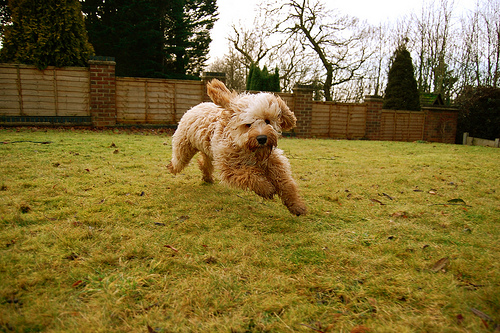

In [126]:
Image.open(test_im)

1/1 [==============================] - 0s 36ms/step
A dog is holding a toy in its mouth .


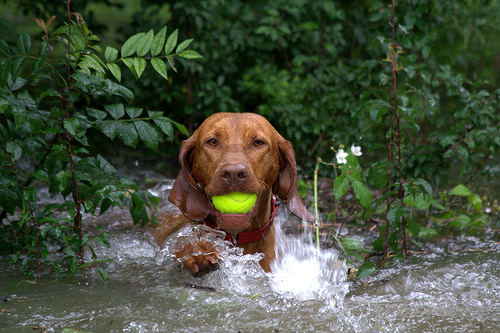

In [128]:
test_im = test_img[111]
print(predict_captions(test_im))
Image.open(test_im)

1/1 [==============================] - 0s 32ms/step
A skateboarder grinding a rail on a rail .


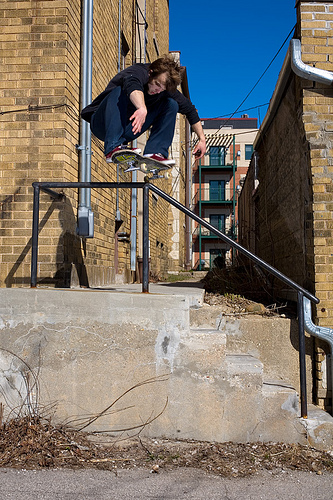

In [141]:
test_im = test_img[21]
print(predict_captions(test_im))
Image.open(test_im)

1/1 [==============================] - 0s 21ms/step
A man is sitting on a rock .


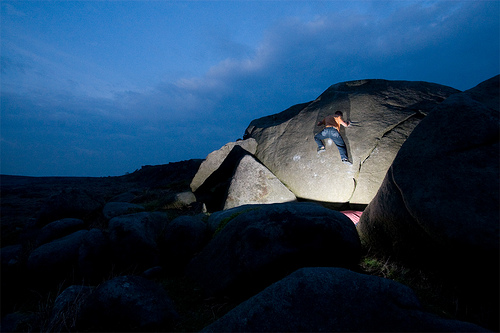

In [132]:
test_im = test_img[171]
print(predict_captions(test_im))
Image.open(test_im)

1/1 [==============================] - 0s 21ms/step
A girl in a bikini is running on the beach .


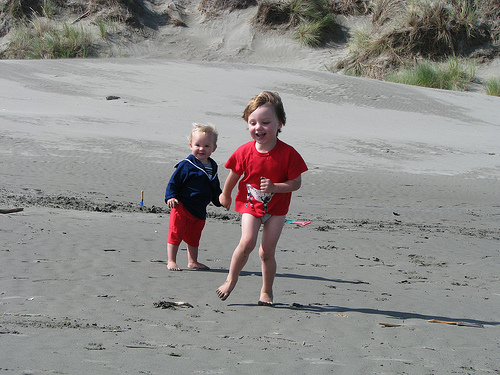

In [134]:
test_im = test_img[91]
print(predict_captions(test_im))
Image.open(test_im)

1/1 [==============================] - 0s 31ms/step
A white dog runs along the beach .


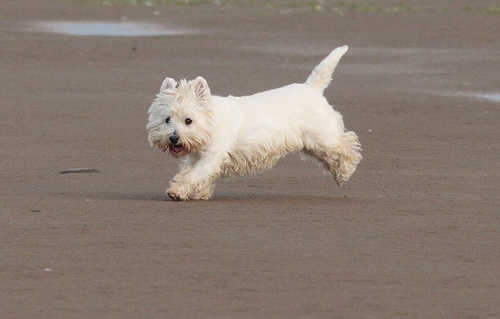

In [138]:
test_im = test_img[501]
print(predict_captions(test_im))
Image.open(test_im)